In [1]:
# magic
%load_ext autoreload
%autoreload 2 
#any changes to the function files will be updated on every run
#%pdb 1 
#where code fails, stops at that breakpoint and allows to examine potential error
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

In [3]:
from numba import vectorize, float64, guvectorize, jit

In [4]:
np.random.seed(6898)

In [5]:
from functions_robust_wasserstein.f_mean_adjust_ss_wasserstein import (alpha_stable, alpha_stable_ss, summary_statistics, mean_adjustment_summary_statistics)

In [6]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

## LOAD DATASET

In [47]:
actual_data = alpha_stable(1.8, 0.5, 1, 0, 200, 1)
actual_data

array([[ 4.23878158e-01, -2.94259252e-01, -3.73524824e+00,
         1.99215130e+00,  3.29583443e-01,  9.00525004e-01,
        -8.90963360e-01, -8.68825319e-01,  1.38977178e-01,
         9.06667886e-01,  1.51981558e+00, -1.09805586e+00,
        -8.18528654e-01, -7.26503333e-01, -1.90468994e+00,
        -4.18156064e+00, -3.52745988e-01, -1.31202203e-01,
        -7.86144226e-01, -2.64098895e+00,  3.57422725e-01,
        -3.16282184e-01, -1.13289325e+00,  1.17618526e+00,
         2.27947634e+00,  2.59373389e-01,  2.64330636e-02,
         1.56984692e+00,  6.86886036e-01, -3.04578346e+00,
         1.59569034e+00,  2.22246989e+00,  2.36433470e+00,
         1.03042389e+00,  1.69307629e+00,  2.50741858e+00,
         7.44558277e-01,  4.30696360e-02, -1.96873946e+00,
        -1.07619215e-01, -3.54709624e-01, -1.98123171e+00,
         1.30755935e+00,  3.89515738e-01,  2.16327735e+00,
        -4.26236529e-01, -6.91108685e-01,  3.14429305e-01,
        -6.42813902e-01, -1.90205687e+00,  3.60233115e-0

In [48]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([1.86190552, 1.46011994, 0.93680502, 0.05748448])

In [9]:
# Using previously simulated data for consistency
# actual_summary_statistics = np.array([ 1.36495524,  0.27388675,  0.78684313, -0.08169088])

In [49]:
num_coeffs = np.shape(actual_summary_statistics)[0]
num_latent = np.shape(actual_summary_statistics)[0]
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [11]:
from multiprocessing import Pool
from functools import partial
pool = Pool(8)

## Training Wasserstein Gaussianing

In [50]:
wass_num_datasets = 3000
wass_n_samples = 30
maxG = 4

In [60]:
# Generating data to train the transform
wass_datasets = alpha_stable(1.8, 0.5, 1, 0, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = np.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])

In [61]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [62]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in np.arange(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-5).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = np.argmin(bic_values) + 1
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-5).fit(data)
    return best_mixture_obj, bestG

In [63]:
def grad_log_density_mixture(data, mixture_obj):
    mean_mixture_obj = mixture_obj.means_
    sigma_mixture_obj = mixture_obj.covariances_
    weights_mixture_obj = mixture_obj.weights_
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ my_inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ my_inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,num_coeffs)) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [64]:
# At current particles, fit mixture normal
mixture_obj, bestG = mixture_model_fit(original_train_summary_statistics, maxG)

In [65]:
# Start training

# Hyperparams
patience_max = 5
patience = 0 
stop = 5000
eps = 0.01
t_w = 10

# Initialize empty chain
mixture_obj_seq = [0] * stop
bestG_seq = [0] * stop
mixture_obj_seq[0] = mixture_obj
bestG_seq[0] = bestG
lb = []
LB_Smoothed = []

In [66]:
for t in range(stop):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_obj)[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_obj)[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_obj = mixture_model_fit(wass_train_summary_statistics, maxG)[0]
    bestG = mixture_model_fit(wass_train_summary_statistics, maxG)[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq[t+1] = mixture_obj
    bestG_seq[t+1] = bestG

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break

LB -3.037111760542092
LB -2.4673581597959
LB -0.4674920267876619
LB 0.015693387836576724
LB 0.252574551601688
LB 0.37386608704046703
LB 0.6109186463557241
LB 0.4396433507260526
LB 0.8389517740609503
LB 0.9580129956417779
LB Smoothed 0.06164562296440834
LB Smoothed 0.4609181664707321
LB Smoothed 0.6474665680057975
LB Smoothed 0.8302856629759012
LB Smoothed 0.9554736130369701
LB Smoothed 1.0703933072769838
LB Smoothed 1.1732059150096796
LB Smoothed 1.3196224592734571
LB Smoothed 1.4102480048330812
LB Smoothed 1.4949673985025813
LB Smoothed 1.5677276524222252
LB Smoothed 1.6448112125004866
LB Smoothed 1.6858245846939808
LB Smoothed 1.7445340161296687
LB Smoothed 1.8105683202614484
LB Smoothed 1.8837478329610395
LB Smoothed 1.9205916146850233
LB Smoothed 1.9748580964198605
LB Smoothed 2.031786590091756
LB Smoothed 2.0793451551953512
LB Smoothed 2.1187647503837805
LB Smoothed 2.143751723745695
LB Smoothed 2.2036796126506566
LB Smoothed 2.256765001856063
LB Smoothed 2.277874654756824
LB Smoo

<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

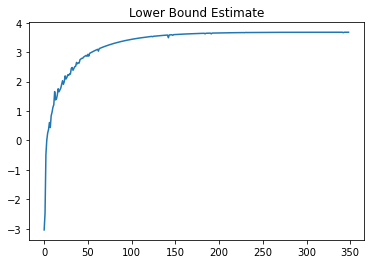

In [67]:
wass_lb_df = pd.DataFrame(np.array(lb))
plt.figure()
wass_lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

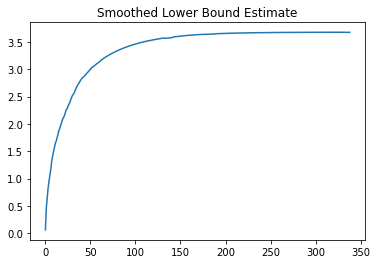

In [68]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

<AxesSubplot:>

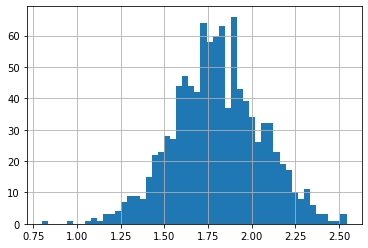

In [69]:
pd.Series(np.random.normal(np.mean(original_train_summary_statistics[:,0]),np.std(original_train_summary_statistics[:,0]), len(original_train_summary_statistics[:,0]))
).hist(bins = 50)

<AxesSubplot:>

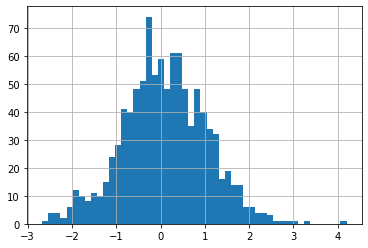

In [70]:
pd.Series(np.random.normal(np.mean(wass_train_summary_statistics[:,0]),np.std(wass_train_summary_statistics[:,0]), len(wass_train_summary_statistics[:,0]))
).hist(bins = 50)

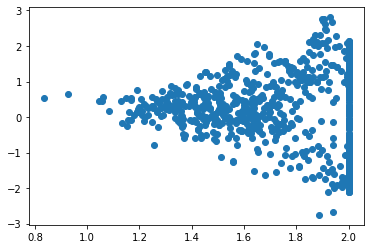

In [71]:
plt.scatter(original_train_summary_statistics[:,0], original_train_summary_statistics[:,1])

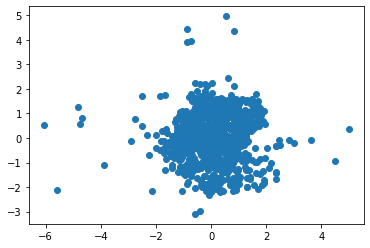

In [72]:
plt.scatter(wass_train_summary_statistics[:,0], wass_train_summary_statistics[:,1])

In [73]:
mixture_obj_seq = [i for i in mixture_obj_seq if i!=0]
mixture_obj_seq = mixture_obj_seq[:-75]
mixture_obj_seq

[GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=2, reg_covar=1e-0

In [74]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [75]:
# Functions must be imported for multiprocessing to work
from functions_robust_wasserstein.f_gradient_lb_mean_wasserstein_nuissance import (fun_gradient_lb)

In [76]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((1.8-1.1)/(2-1.8)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        l_0_inv = my_inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)

                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_samples = n_samples, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [77]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[1.86190552, 1.46011994, 0.93680502, 0.05748448]])

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [78]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)
transformed_summary_statistics[0]

array([ 0.34211858,  0.94329618, -0.2057362 ,  0.16689963])

In [79]:
vb = GVB(400, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 100, 100)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
  0%|          | 1/5000 [01:28<123:05:40, 88.65s/it]

LB -12.505804419080446


  0%|          | 2/5000 [03:11<134:18:16, 96.74s/it]

LB -12.511163151580963


  0%|          | 3/5000 [04:37<127:51:50, 92.12s/it]

LB -12.583999821661745


  0%|          | 4/5000 [6:20:04<12419:17:16, 8949.05s/it]

LB -12.399811945714548


  0%|          | 5/5000 [6:23:12<8033:19:02, 5789.78s/it] 

LB -12.398905246235177


  0%|          | 6/5000 [6:24:46<5345:12:58, 3853.18s/it]

LB -12.338574209514656


  0%|          | 7/5000 [6:25:54<3627:56:53, 2615.78s/it]

LB -12.239501973019147


  0%|          | 8/5000 [6:26:47<2495:42:08, 1799.79s/it]

LB -12.262562007746647


  0%|          | 9/5000 [6:27:41<1738:37:50, 1254.07s/it]

LB -12.284683930966091


  0%|          | 10/5000 [6:28:42<1227:45:32, 885.76s/it]

LB -12.337348457806259


  0%|          | 11/5000 [6:29:48<879:51:20, 634.89s/it] 

LB -12.293400010360099


  0%|          | 12/5000 [6:30:42<634:46:28, 458.14s/it]

LB -12.16400514626463


  0%|          | 13/5000 [6:31:34<464:16:49, 335.15s/it]

LB -12.138632648267041


  0%|          | 14/5000 [6:32:27<346:14:33, 249.99s/it]

LB -12.140462512322333


  0%|          | 15/5000 [6:33:20<264:04:45, 190.71s/it]

LB -12.255823598589508


  0%|          | 16/5000 [6:34:15<207:22:14, 149.79s/it]

LB -12.265241090712662


  0%|          | 17/5000 [6:35:10<167:39:36, 121.13s/it]

LB -12.223712773654457


  0%|          | 18/5000 [6:36:16<144:43:25, 104.58s/it]

LB -12.180081437619306


  0%|          | 19/5000 [6:37:17<126:34:39, 91.48s/it] 

LB -12.076859211992264


  0%|          | 20/5000 [6:38:20<114:51:24, 83.03s/it]

LB -12.108731171854865


  0%|          | 21/5000 [6:39:23<106:34:51, 77.06s/it]

LB -12.11406088391165


  0%|          | 22/5000 [6:40:31<102:49:38, 74.36s/it]

LB -12.030694992016874


  0%|          | 23/5000 [6:41:35<98:11:12, 71.02s/it] 

LB -12.034346313954162


  0%|          | 24/5000 [6:42:37<94:41:34, 68.51s/it]

LB -11.997513527077967


  0%|          | 25/5000 [6:43:37<90:55:51, 65.80s/it]

LB -11.872423124199056


  1%|          | 26/5000 [6:44:37<88:49:09, 64.28s/it]

LB -11.842325399425153


  1%|          | 27/5000 [6:45:39<87:33:48, 63.39s/it]

LB -12.125368968978552


  1%|          | 28/5000 [6:46:39<86:23:48, 62.56s/it]

LB -12.091757378529826


  1%|          | 29/5000 [6:47:46<88:13:58, 63.90s/it]

LB -12.29070233887539


  1%|          | 30/5000 [6:48:51<88:23:22, 64.02s/it]

LB -12.243215311282174


  1%|          | 31/5000 [6:49:55<88:28:12, 64.10s/it]

LB -12.1136221352307


  1%|          | 32/5000 [6:50:53<85:59:17, 62.31s/it]

LB -12.192954860695377


  1%|          | 33/5000 [6:51:48<82:52:32, 60.07s/it]

LB -12.177695632009186


  1%|          | 34/5000 [6:52:47<82:23:24, 59.73s/it]

LB -12.010417869873812


  1%|          | 35/5000 [6:53:48<83:00:50, 60.19s/it]

LB -12.06828836232811


  1%|          | 36/5000 [6:54:54<85:16:47, 61.85s/it]

LB -12.21423142997121


  1%|          | 37/5000 [6:56:01<87:24:18, 63.40s/it]

LB -12.23191988037419


  1%|          | 38/5000 [6:56:57<84:23:59, 61.23s/it]

LB -12.156545498464707


  1%|          | 39/5000 [6:57:57<84:00:31, 60.96s/it]

LB -12.144304123004563


  1%|          | 40/5000 [6:59:11<89:23:48, 64.88s/it]

LB -12.243417665356015


  1%|          | 41/5000 [7:00:09<86:20:47, 62.68s/it]

LB -11.91434836275694


  1%|          | 42/5000 [7:01:25<91:49:05, 66.67s/it]

LB -12.072492741112937


  1%|          | 43/5000 [7:02:37<94:11:35, 68.41s/it]

LB -12.290582350503628


  1%|          | 44/5000 [7:03:38<91:04:10, 66.15s/it]

LB -12.390184249129291


  1%|          | 45/5000 [7:04:43<90:27:31, 65.72s/it]

LB -12.196626699153084


  1%|          | 46/5000 [7:05:45<88:48:26, 64.54s/it]

LB -12.122075703743992


  1%|          | 47/5000 [7:06:41<85:17:29, 61.99s/it]

LB -12.11043837326596


  1%|          | 48/5000 [7:07:44<85:44:29, 62.33s/it]

LB -12.16054752030696


  1%|          | 49/5000 [7:09:05<93:37:15, 68.07s/it]

LB -12.233040729517693


  1%|          | 50/5000 [7:10:05<90:14:34, 65.63s/it]

LB -12.265720339501007


  1%|          | 51/5000 [7:11:12<90:28:43, 65.82s/it]

LB -12.186533718356191


  1%|          | 52/5000 [7:12:20<91:39:17, 66.69s/it]

LB -12.325075416504117


  1%|          | 53/5000 [7:13:24<90:32:02, 65.88s/it]

LB -11.973236738195046


  1%|          | 54/5000 [7:14:32<91:13:38, 66.40s/it]

LB -11.994835474649598


  1%|          | 55/5000 [7:15:55<98:16:26, 71.54s/it]

LB -12.226090371885586


  1%|          | 56/5000 [7:17:00<95:25:13, 69.48s/it]

LB -12.234953964722758


  1%|          | 57/5000 [7:18:15<97:30:53, 71.02s/it]

LB -12.224809583198049


  1%|          | 58/5000 [7:19:16<93:29:59, 68.11s/it]

LB -12.241586905017911


  1%|          | 59/5000 [7:20:23<92:59:17, 67.75s/it]

LB -12.207657035494549


  1%|          | 60/5000 [7:21:25<90:43:34, 66.12s/it]

LB -12.036206149796001


  1%|          | 61/5000 [7:22:27<89:02:43, 64.90s/it]

LB -12.124383510184002


  1%|          | 62/5000 [7:23:28<87:14:33, 63.60s/it]

LB -12.076628629072086


  1%|▏         | 63/5000 [7:24:33<87:39:14, 63.92s/it]

LB -11.994840585486557


  1%|▏         | 64/5000 [7:25:41<89:18:47, 65.14s/it]

LB -12.18753803266219


  1%|▏         | 65/5000 [7:26:38<86:08:57, 62.84s/it]

LB -12.096379176603245


  1%|▏         | 66/5000 [7:27:40<85:44:42, 62.56s/it]

LB -12.012784394489083


  1%|▏         | 67/5000 [7:28:49<88:35:30, 64.65s/it]

LB -12.070940595765935


  1%|▏         | 68/5000 [7:29:52<87:34:29, 63.92s/it]

LB -12.092648550306277


  1%|▏         | 69/5000 [7:30:55<87:09:13, 63.63s/it]

LB -12.011141681692534


  1%|▏         | 70/5000 [7:32:06<90:15:15, 65.91s/it]

LB -12.168824906830453


  1%|▏         | 71/5000 [7:33:11<89:53:42, 65.66s/it]

LB -12.233887685412824


  1%|▏         | 72/5000 [7:34:28<94:37:11, 69.12s/it]

LB -12.1444707204632


  1%|▏         | 73/5000 [7:35:43<96:53:30, 70.80s/it]

LB -11.807686071915306


  1%|▏         | 74/5000 [7:36:55<97:26:13, 71.21s/it]

LB -11.911781612411337


  2%|▏         | 75/5000 [7:38:05<96:54:29, 70.84s/it]

LB -12.031854683924962


  2%|▏         | 76/5000 [7:39:30<102:35:48, 75.01s/it]

LB -12.122549110678754


  2%|▏         | 77/5000 [7:40:52<105:40:24, 77.27s/it]

LB -11.975491226237317


  2%|▏         | 78/5000 [7:42:05<103:48:54, 75.93s/it]

LB -12.136787972581237


  2%|▏         | 79/5000 [7:43:08<98:19:31, 71.93s/it] 

LB -12.066043807535085


  2%|▏         | 80/5000 [7:44:16<96:40:47, 70.74s/it]

LB -12.086679282399125


  2%|▏         | 81/5000 [7:45:21<94:18:50, 69.02s/it]

LB -12.040528244514357


  2%|▏         | 82/5000 [7:46:31<94:52:56, 69.45s/it]

LB -12.23995563482227


  2%|▏         | 83/5000 [7:47:33<91:34:49, 67.05s/it]

LB -12.129654605892384


  2%|▏         | 84/5000 [7:48:37<90:17:24, 66.12s/it]

LB -11.913498512739444


  2%|▏         | 85/5000 [7:49:41<89:42:02, 65.70s/it]

LB -11.80606104704322


  2%|▏         | 86/5000 [7:50:50<90:58:43, 66.65s/it]

LB -11.886714213812303


  2%|▏         | 87/5000 [7:51:52<89:04:06, 65.26s/it]

LB -12.055130577173228


  2%|▏         | 88/5000 [7:52:59<89:36:05, 65.67s/it]

LB -11.939320779966971


  2%|▏         | 89/5000 [7:54:07<90:26:50, 66.30s/it]

LB -11.776129237408961


  2%|▏         | 90/5000 [7:55:28<96:46:46, 70.96s/it]

LB -11.986413271351273


  2%|▏         | 91/5000 [7:56:32<93:38:01, 68.67s/it]

LB -11.819252084630763


  2%|▏         | 92/5000 [7:57:33<90:43:10, 66.54s/it]

LB -12.023100465017798


  2%|▏         | 93/5000 [7:58:50<94:48:18, 69.55s/it]

LB -12.011641372635998


  2%|▏         | 94/5000 [8:00:05<97:00:40, 71.19s/it]

LB -11.842337415455667


  2%|▏         | 95/5000 [8:01:16<96:57:48, 71.17s/it]

LB -12.101462298211485


  2%|▏         | 96/5000 [8:02:18<93:04:30, 68.33s/it]

LB -11.98792501292308


  2%|▏         | 97/5000 [8:03:28<94:05:09, 69.08s/it]

LB -12.080866504263518


  2%|▏         | 98/5000 [8:04:35<93:09:31, 68.42s/it]

LB -12.01304010572612


  2%|▏         | 99/5000 [8:05:38<90:50:46, 66.73s/it]

LB -12.118275822194699


  2%|▏         | 100/5000 [8:06:45<90:53:38, 66.78s/it]

LB -11.96704466186173


  2%|▏         | 101/5000 [8:07:47<88:57:59, 65.38s/it]

LB Smoothed -12.120182248207568


  2%|▏         | 102/5000 [8:08:58<91:01:17, 66.90s/it]

LB Smoothed -12.114943051709881


  2%|▏         | 103/5000 [8:10:02<89:48:00, 66.02s/it]

LB Smoothed -12.107990544506576


  2%|▏         | 104/5000 [8:11:17<93:28:57, 68.74s/it]

LB Smoothed -12.105097386743566


  2%|▏         | 105/5000 [8:12:24<93:05:53, 68.47s/it]

LB Smoothed -12.10115004088015


  2%|▏         | 106/5000 [8:13:33<93:13:42, 68.58s/it]

LB Smoothed -12.098689588481946


  2%|▏         | 107/5000 [8:14:41<92:52:42, 68.33s/it]

LB Smoothed -12.096710558775579


  2%|▏         | 108/5000 [8:15:43<90:11:16, 66.37s/it]

LB Smoothed -12.093209387969143


  2%|▏         | 109/5000 [8:16:48<89:45:52, 66.07s/it]

LB Smoothed -12.08956076083033


  2%|▏         | 110/5000 [8:17:50<87:55:32, 64.73s/it]

LB Smoothed -12.084866852622838


  2%|▏         | 111/5000 [8:18:56<88:38:05, 65.27s/it]

LB Smoothed -12.080371502112289


  2%|▏         | 112/5000 [8:19:58<87:01:46, 64.10s/it]

LB Smoothed -12.078771191926432


  2%|▏         | 113/5000 [8:21:08<89:25:35, 65.88s/it]

LB Smoothed -12.076415089846067


  2%|▏         | 114/5000 [8:22:10<87:55:42, 64.79s/it]

LB Smoothed -12.074993035910452


  2%|▏         | 115/5000 [8:23:14<87:28:12, 64.46s/it]

LB Smoothed -12.072214711634604


  2%|▏         | 116/5000 [8:24:17<87:00:23, 64.13s/it]

LB Smoothed -12.069685818589045


  2%|▏         | 117/5000 [8:25:19<86:13:12, 63.57s/it]

LB Smoothed -12.066690880744828


  2%|▏         | 118/5000 [8:26:20<85:06:51, 62.76s/it]

LB Smoothed -12.06418591621668


  2%|▏         | 119/5000 [8:27:21<84:14:22, 62.13s/it]

LB Smoothed -12.062435066696585


  2%|▏         | 120/5000 [8:28:22<83:54:28, 61.90s/it]

LB Smoothed -12.061179375965422


  2%|▏         | 121/5000 [8:29:25<84:11:03, 62.12s/it]

LB Smoothed -12.059119118545961


  2%|▏         | 122/5000 [8:30:27<84:05:26, 62.06s/it]

LB Smoothed -12.058108928474601


  2%|▏         | 123/5000 [8:31:27<83:26:11, 61.59s/it]

LB Smoothed -12.056930387414688


  2%|▏         | 124/5000 [8:32:34<85:32:23, 63.15s/it]

LB Smoothed -12.056601839030009


  2%|▎         | 125/5000 [8:33:33<83:56:03, 61.98s/it]

LB Smoothed -12.05621522648119


  3%|▎         | 126/5000 [8:34:35<83:57:01, 62.01s/it]

LB Smoothed -12.05575323270609


  3%|▎         | 127/5000 [8:35:51<89:16:33, 65.95s/it]

LB Smoothed -12.05434654352456


  3%|▎         | 128/5000 [8:36:59<90:04:53, 66.56s/it]

LB Smoothed -12.051451708156952


  3%|▎         | 129/5000 [8:38:15<94:12:27, 69.63s/it]

LB Smoothed -12.04706952608994


  3%|▎         | 130/5000 [8:39:23<93:29:39, 69.11s/it]

LB Smoothed -12.042805046693758


  3%|▎         | 131/5000 [8:40:27<91:25:03, 67.59s/it]

LB Smoothed -12.041275935656055


  3%|▎         | 132/5000 [8:41:33<90:33:01, 66.96s/it]

LB Smoothed -12.037390510892685


  3%|▎         | 133/5000 [8:42:38<89:53:51, 66.49s/it]

LB Smoothed -12.034103666477682


  3%|▎         | 134/5000 [8:43:52<92:45:04, 68.62s/it]

LB Smoothed -12.031570873078362


  3%|▎         | 135/5000 [8:45:02<93:35:19, 69.25s/it]

LB Smoothed -12.029164238498277


  3%|▎         | 136/5000 [8:46:04<90:36:15, 67.06s/it]

LB Smoothed -12.027504840957024


  3%|▎         | 137/5000 [8:47:19<93:46:52, 69.42s/it]

LB Smoothed -12.022513088345415


  3%|▎         | 138/5000 [8:48:24<92:01:23, 68.14s/it]

LB Smoothed -12.021051763465675


  3%|▎         | 139/5000 [8:49:40<95:10:31, 70.49s/it]

LB Smoothed -12.018926278261752


  3%|▎         | 140/5000 [8:50:45<92:43:14, 68.68s/it]

LB Smoothed -12.014517149605249


  3%|▎         | 141/5000 [8:52:00<95:21:11, 70.65s/it]

LB Smoothed -12.013097593565975


  3%|▎         | 142/5000 [8:53:09<94:42:53, 70.19s/it]

LB Smoothed -12.010753262589171


  3%|▎         | 143/5000 [8:54:26<97:09:37, 72.02s/it]

LB Smoothed -12.007329051647801


  3%|▎         | 144/5000 [8:55:47<100:50:08, 74.75s/it]

LB Smoothed -12.001339881907073


  3%|▎         | 145/5000 [8:56:50<96:18:06, 71.41s/it] 

LB Smoothed -11.998761725337012


  3%|▎         | 146/5000 [8:57:53<92:39:35, 68.72s/it]

LB Smoothed -11.996244981716234


  3%|▎         | 147/5000 [8:59:08<95:09:43, 70.59s/it]

LB Smoothed -11.995243681112969


  3%|▎         | 148/5000 [9:00:15<93:41:12, 69.51s/it]

LB Smoothed -11.991789726916371


  3%|▎         | 149/5000 [9:01:19<91:28:21, 67.88s/it]

LB Smoothed -11.98816278224583


  3%|▎         | 150/5000 [9:02:32<93:39:38, 69.52s/it]

LB Smoothed -11.983149395810408


  3%|▎         | 151/5000 [9:03:35<91:07:47, 67.66s/it]

LB Smoothed -11.978247719174062


  3%|▎         | 152/5000 [9:04:37<88:41:50, 65.86s/it]

LB Smoothed -11.973262136459025


  3%|▎         | 153/5000 [9:05:43<88:30:41, 65.74s/it]

LB Smoothed -11.971924745090815


  3%|▎         | 154/5000 [9:06:50<89:03:29, 66.16s/it]

LB Smoothed -11.971121370313133


  3%|▎         | 155/5000 [9:08:02<91:38:30, 68.09s/it]

LB Smoothed -11.967633282076354


  3%|▎         | 156/5000 [9:09:07<90:06:37, 66.97s/it]

LB Smoothed -11.962890959962468


  3%|▎         | 157/5000 [9:10:03<85:59:50, 63.93s/it]

LB Smoothed -11.9595359492876


  3%|▎         | 158/5000 [9:11:09<86:47:12, 64.53s/it]

LB Smoothed -11.956683747182899


  3%|▎         | 159/5000 [9:12:24<90:55:52, 67.62s/it]

LB Smoothed -11.952569477199964


  3%|▎         | 160/5000 [9:13:38<93:12:16, 69.33s/it]

LB Smoothed -11.950493269497231


  3%|▎         | 161/5000 [9:14:49<93:57:58, 69.91s/it]

LB Smoothed -11.948364866893073


  3%|▎         | 162/5000 [9:16:00<94:23:56, 70.24s/it]

LB Smoothed -11.947952179050324


  3%|▎         | 163/5000 [9:17:30<102:14:43, 76.10s/it]

LB Smoothed -11.948645315533792


  3%|▎         | 164/5000 [9:19:07<110:55:42, 82.58s/it]

LB Smoothed -11.946654066595016


  3%|▎         | 165/5000 [9:20:16<105:09:37, 78.30s/it]

LB Smoothed -11.946207362795327


  3%|▎         | 166/5000 [9:21:48<110:50:16, 82.54s/it]

LB Smoothed -11.944973754195674


  3%|▎         | 167/5000 [9:23:04<108:20:20, 80.70s/it]

LB Smoothed -11.944288454645823


  3%|▎         | 168/5000 [9:24:16<104:40:23, 77.98s/it]

LB Smoothed -11.942931348914893


  3%|▎         | 169/5000 [9:25:34<104:38:30, 77.98s/it]

LB Smoothed -11.943125008608947


  3%|▎         | 170/5000 [9:27:00<107:50:10, 80.37s/it]

LB Smoothed -11.94144599613356


  3%|▎         | 171/5000 [9:28:02<100:26:57, 74.88s/it]

LB Smoothed -11.938967653121752


  3%|▎         | 172/5000 [9:29:23<103:00:39, 76.81s/it]

LB Smoothed -11.936717679847112


  3%|▎         | 173/5000 [9:30:31<99:13:43, 74.01s/it] 

LB Smoothed -11.938537919635323


  3%|▎         | 174/5000 [9:31:36<95:28:20, 71.22s/it]

LB Smoothed -11.939977599229877


  4%|▎         | 175/5000 [9:32:55<98:32:48, 73.53s/it]

LB Smoothed -11.940441630105685


  4%|▎         | 176/5000 [9:34:03<96:33:40, 72.06s/it]

LB Smoothed -11.937778689591179


  4%|▎         | 177/5000 [9:35:03<91:47:46, 68.52s/it]

LB Smoothed -11.937258454986031


  4%|▎         | 178/5000 [9:36:12<91:49:04, 68.55s/it]

LB Smoothed -11.935523601967873


  4%|▎         | 179/5000 [9:37:22<92:32:17, 69.10s/it]

LB Smoothed -11.932244868068734


  4%|▎         | 180/5000 [9:38:44<97:29:10, 72.81s/it]

LB Smoothed -11.931103768743176


  4%|▎         | 181/5000 [9:39:46<93:10:50, 69.61s/it]

LB Smoothed -11.928877604278311


  4%|▎         | 182/5000 [9:40:44<88:40:41, 66.26s/it]

LB Smoothed -11.923322447374442


  4%|▎         | 183/5000 [9:42:11<96:47:40, 72.34s/it]

LB Smoothed -11.921332033482507


  4%|▎         | 184/5000 [9:43:23<96:42:02, 72.28s/it]

LB Smoothed -11.921159788156562


  4%|▎         | 185/5000 [9:44:35<96:39:47, 72.27s/it]

LB Smoothed -11.922908411104343


  4%|▎         | 186/5000 [9:45:52<98:23:52, 73.58s/it]

LB Smoothed -11.923434017811413


  4%|▎         | 187/5000 [9:46:55<94:01:02, 70.32s/it]

LB Smoothed -11.921214228114023


  4%|▍         | 188/5000 [9:48:05<94:05:08, 70.39s/it]

LB Smoothed -11.920761957290624


  4%|▍         | 189/5000 [9:49:13<92:57:05, 69.55s/it]

LB Smoothed -11.922441529686363


  4%|▍         | 190/5000 [9:50:14<89:39:37, 67.11s/it]

LB Smoothed -11.921770950357256


  4%|▍         | 191/5000 [9:51:25<91:11:30, 68.27s/it]

LB Smoothed -11.922621430812246


  4%|▍         | 192/5000 [9:52:39<93:29:14, 70.00s/it]

LB Smoothed -11.921156518952724


  4%|▍         | 193/5000 [9:53:47<92:22:13, 69.18s/it]

LB Smoothed -11.919805981396953


  4%|▍         | 194/5000 [9:54:49<89:35:28, 67.11s/it]

LB Smoothed -11.920468859831223


  4%|▍         | 195/5000 [9:56:03<92:31:20, 69.32s/it]

LB Smoothed -11.917636971222949


  4%|▍         | 196/5000 [9:57:06<89:51:50, 67.34s/it]

LB Smoothed -11.91522101375494


  4%|▍         | 197/5000 [9:58:28<95:32:44, 71.61s/it]

LB Smoothed -11.911899667314849


  4%|▍         | 198/5000 [10:00:03<105:01:17, 78.73s/it]

LB Smoothed -11.90904427043389


  4%|▍         | 199/5000 [10:01:26<106:32:15, 79.89s/it]

LB Smoothed -11.905474097802985


  4%|▍         | 200/5000 [10:02:27<98:58:58, 74.24s/it] 

LB Smoothed -11.904359651202983


  4%|▍         | 201/5000 [10:03:27<93:15:40, 69.96s/it]

LB Smoothed -11.903238336102952


  4%|▍         | 202/5000 [10:04:30<90:36:02, 67.98s/it]

LB Smoothed -11.90315578639788


  4%|▍         | 203/5000 [10:05:36<89:42:43, 67.33s/it]

LB Smoothed -11.900380383987912


  4%|▍         | 204/5000 [10:06:47<91:22:55, 68.59s/it]

LB Smoothed -11.898703552745184


  4%|▍         | 205/5000 [10:07:49<88:31:19, 66.46s/it]

LB Smoothed -11.895387650067319


  4%|▍         | 206/5000 [10:08:59<90:01:17, 67.60s/it]

LB Smoothed -11.893292375805727


  4%|▍         | 207/5000 [10:10:04<89:08:42, 66.96s/it]

LB Smoothed -11.893454330859674


  4%|▍         | 208/5000 [10:11:24<94:17:49, 70.84s/it]

LB Smoothed -11.891429918107454


  4%|▍         | 209/5000 [10:12:37<94:47:44, 71.23s/it]

LB Smoothed -11.891983522571199


  4%|▍         | 210/5000 [10:13:38<90:58:04, 68.37s/it]

LB Smoothed -11.891388253134338


  4%|▍         | 211/5000 [10:14:50<92:11:49, 69.31s/it]

LB Smoothed -11.890031729826848


  4%|▍         | 212/5000 [10:16:02<93:12:51, 70.09s/it]

LB Smoothed -11.888932947218594


  4%|▍         | 213/5000 [10:17:02<89:19:24, 67.17s/it]

LB Smoothed -11.886005147463628


  4%|▍         | 214/5000 [10:18:18<92:38:56, 69.69s/it]

LB Smoothed -11.884317763486568


  4%|▍         | 215/5000 [10:19:35<95:54:47, 72.16s/it]

LB Smoothed -11.882064021171226


  4%|▍         | 216/5000 [10:20:49<96:27:34, 72.59s/it]

LB Smoothed -11.879733287204079


  4%|▍         | 217/5000 [10:22:01<96:11:10, 72.40s/it]

LB Smoothed -11.878011321400075


  4%|▍         | 218/5000 [10:23:14<96:21:47, 72.54s/it]

LB Smoothed -11.877424896363907


  4%|▍         | 219/5000 [10:24:21<94:01:24, 70.80s/it]

LB Smoothed -11.875622658908265


  4%|▍         | 220/5000 [10:25:28<92:40:19, 69.79s/it]

LB Smoothed -11.873673212318408


  4%|▍         | 221/5000 [10:26:37<92:16:32, 69.51s/it]

LB Smoothed -11.873079212586092


  4%|▍         | 222/5000 [10:27:48<92:49:42, 69.94s/it]

LB Smoothed -11.871488924892917


  4%|▍         | 223/5000 [10:29:16<100:01:57, 75.39s/it]

LB Smoothed -11.868824780479269


  4%|▍         | 224/5000 [10:30:17<94:20:02, 71.11s/it] 

LB Smoothed -11.868447435316082


  4%|▍         | 225/5000 [10:31:19<90:36:47, 68.32s/it]

LB Smoothed -11.868255730135909


  5%|▍         | 226/5000 [10:32:40<95:30:29, 72.02s/it]

LB Smoothed -11.865661923281383


  5%|▍         | 227/5000 [10:33:55<96:42:31, 72.94s/it]

LB Smoothed -11.864896254513017


  5%|▍         | 228/5000 [10:34:55<91:38:44, 69.14s/it]

LB Smoothed -11.863534077995562


  5%|▍         | 229/5000 [10:36:00<90:03:06, 67.95s/it]

LB Smoothed -11.862329925352146


  5%|▍         | 230/5000 [10:37:01<87:16:44, 65.87s/it]

LB Smoothed -11.860282938880374


  5%|▍         | 231/5000 [10:38:10<88:16:56, 66.64s/it]

LB Smoothed -11.859834975355632


  5%|▍         | 232/5000 [10:39:10<85:53:30, 64.85s/it]

LB Smoothed -11.858632615545606


  5%|▍         | 233/5000 [10:40:20<87:43:20, 66.25s/it]

LB Smoothed -11.857760306018987


  5%|▍         | 234/5000 [10:41:22<86:10:40, 65.09s/it]

LB Smoothed -11.856450450058762


  5%|▍         | 235/5000 [10:42:33<88:27:02, 66.83s/it]

LB Smoothed -11.853520683007899


  5%|▍         | 236/5000 [10:43:33<85:48:01, 64.84s/it]

LB Smoothed -11.853424014077627


  5%|▍         | 237/5000 [10:44:43<87:40:47, 66.27s/it]

LB Smoothed -11.8503344204148


  5%|▍         | 238/5000 [10:45:50<88:00:38, 66.53s/it]

LB Smoothed -11.849257714962997


  5%|▍         | 239/5000 [10:47:03<90:27:52, 68.40s/it]

LB Smoothed -11.848661034240482


  5%|▍         | 240/5000 [10:48:11<90:35:10, 68.51s/it]

LB Smoothed -11.849029326906976


  5%|▍         | 241/5000 [10:49:20<90:36:20, 68.54s/it]

LB Smoothed -11.848722518900573


  5%|▍         | 242/5000 [10:50:31<91:24:02, 69.16s/it]

LB Smoothed -11.847154241034307


  5%|▍         | 243/5000 [10:51:31<87:41:09, 66.36s/it]

LB Smoothed -11.848044531352812


  5%|▍         | 244/5000 [10:52:43<89:54:38, 68.06s/it]

LB Smoothed -11.845618183840166


  5%|▍         | 245/5000 [10:53:49<89:08:06, 67.48s/it]

LB Smoothed -11.844688813749311


  5%|▍         | 246/5000 [10:55:08<93:51:07, 71.07s/it]

LB Smoothed -11.84327325132297


  5%|▍         | 247/5000 [10:56:08<89:19:59, 67.66s/it]

LB Smoothed -11.84213061315371


  5%|▍         | 248/5000 [10:57:04<84:50:47, 64.28s/it]

LB Smoothed -11.84160527000137


  5%|▍         | 249/5000 [10:58:15<87:17:18, 66.14s/it]

LB Smoothed -11.843280249661037


  5%|▌         | 250/5000 [10:59:21<87:14:21, 66.12s/it]

LB Smoothed -11.843882406616014


  5%|▌         | 251/5000 [11:00:21<84:53:53, 64.36s/it]

LB Smoothed -11.84208776101229


  5%|▌         | 252/5000 [11:01:40<90:29:25, 68.61s/it]

LB Smoothed -11.841320683120776


  5%|▌         | 253/5000 [11:02:58<94:24:00, 71.59s/it]

LB Smoothed -11.840611872912726


  5%|▌         | 254/5000 [11:04:13<95:33:47, 72.49s/it]

LB Smoothed -11.840588618067203


  5%|▌         | 255/5000 [11:05:18<92:39:11, 70.30s/it]

LB Smoothed -11.83970442765337


  5%|▌         | 256/5000 [11:06:31<93:47:56, 71.18s/it]

LB Smoothed -11.838266573826456


  5%|▌         | 257/5000 [11:07:41<93:14:28, 70.77s/it]

LB Smoothed -11.835253418582969


  5%|▌         | 258/5000 [11:08:51<93:01:28, 70.62s/it]

LB Smoothed -11.834767298338624


  5%|▌         | 259/5000 [11:10:04<93:51:25, 71.27s/it]

LB Smoothed -11.835155263360157


  5%|▌         | 260/5000 [11:11:11<92:05:29, 69.94s/it]

LB Smoothed -11.833627359370634


  5%|▌         | 261/5000 [11:12:30<95:33:59, 72.60s/it]

LB Smoothed -11.829449746400135


  5%|▌         | 262/5000 [11:13:35<92:39:05, 70.40s/it]

LB Smoothed -11.826675670805232


  5%|▌         | 263/5000 [11:14:45<92:41:12, 70.44s/it]

LB Smoothed -11.82468704892993


  5%|▌         | 264/5000 [11:15:46<88:38:51, 67.38s/it]

LB Smoothed -11.82244818517343


  5%|▌         | 265/5000 [11:16:52<88:15:03, 67.10s/it]

LB Smoothed -11.822936725617703


  5%|▌         | 266/5000 [11:17:55<86:32:13, 65.81s/it]

LB Smoothed -11.821495990579717


  5%|▌         | 267/5000 [11:19:10<90:14:45, 68.64s/it]

LB Smoothed -11.819642133616698


  5%|▌         | 268/5000 [11:20:17<89:28:52, 68.08s/it]

LB Smoothed -11.817340582295667


  5%|▌         | 269/5000 [11:21:25<89:26:31, 68.06s/it]

LB Smoothed -11.815426742303883


  5%|▌         | 270/5000 [11:22:24<85:52:29, 65.36s/it]

LB Smoothed -11.812483289962012


  5%|▌         | 271/5000 [11:23:37<88:42:13, 67.53s/it]

LB Smoothed -11.811327880493476


  5%|▌         | 272/5000 [11:25:23<103:50:08, 79.06s/it]

LB Smoothed -11.808444787329885


  5%|▌         | 273/5000 [11:26:34<100:45:18, 76.73s/it]

LB Smoothed -11.804432668585223


  5%|▌         | 274/5000 [11:27:46<98:54:51, 75.35s/it] 

LB Smoothed -11.800170608216234


  6%|▌         | 275/5000 [11:29:00<98:28:24, 75.03s/it]

LB Smoothed -11.797371036129148


  6%|▌         | 276/5000 [11:30:11<96:52:46, 73.83s/it]

LB Smoothed -11.796419979960085


  6%|▌         | 277/5000 [11:31:22<95:35:34, 72.86s/it]

LB Smoothed -11.794172178268512


  6%|▌         | 278/5000 [11:32:32<94:29:17, 72.04s/it]

LB Smoothed -11.793876989004982


  6%|▌         | 279/5000 [11:33:42<93:38:34, 71.41s/it]

LB Smoothed -11.790326384325201


  6%|▌         | 280/5000 [11:34:53<93:39:09, 71.43s/it]

LB Smoothed -11.789559985860722


  6%|▌         | 281/5000 [11:36:03<92:51:59, 70.85s/it]

LB Smoothed -11.788530471799104


  6%|▌         | 282/5000 [11:37:13<92:24:43, 70.51s/it]

LB Smoothed -11.787036587068657


  6%|▌         | 283/5000 [11:38:23<92:09:40, 70.34s/it]

LB Smoothed -11.784731216441685


  6%|▌         | 284/5000 [11:39:35<92:57:29, 70.96s/it]

LB Smoothed -11.781498096153475


  6%|▌         | 285/5000 [11:40:45<92:38:56, 70.74s/it]

LB Smoothed -11.778420427251039


  6%|▌         | 286/5000 [11:41:56<92:31:21, 70.66s/it]

LB Smoothed -11.777011269623294


  6%|▌         | 287/5000 [11:43:06<92:33:25, 70.70s/it]

LB Smoothed -11.775273865899917


  6%|▌         | 288/5000 [11:44:19<93:09:14, 71.17s/it]

LB Smoothed -11.772958265712663


  6%|▌         | 289/5000 [11:45:30<93:01:37, 71.09s/it]

LB Smoothed -11.771160785003923


  6%|▌         | 290/5000 [11:46:40<92:41:03, 70.84s/it]

LB Smoothed -11.767909416574916


  6%|▌         | 291/5000 [11:47:52<93:08:53, 71.21s/it]

LB Smoothed -11.765897268052273


  6%|▌         | 292/5000 [11:49:04<93:15:46, 71.31s/it]

LB Smoothed -11.763895107518115


  6%|▌         | 293/5000 [11:50:14<92:55:48, 71.07s/it]

LB Smoothed -11.761019539445176


  6%|▌         | 294/5000 [11:51:24<92:25:18, 70.70s/it]

LB Smoothed -11.759080223706842


  6%|▌         | 295/5000 [11:52:34<92:19:10, 70.64s/it]

LB Smoothed -11.758630121254303


  6%|▌         | 296/5000 [11:53:44<92:04:21, 70.46s/it]

LB Smoothed -11.759142334524872


  6%|▌         | 297/5000 [11:54:56<92:26:12, 70.76s/it]

LB Smoothed -11.760083931783036


  6%|▌         | 298/5000 [11:56:07<92:37:00, 70.91s/it]

LB Smoothed -11.759823488649673


  6%|▌         | 299/5000 [11:57:17<92:18:51, 70.69s/it]

LB Smoothed -11.758362821630772


  6%|▌         | 300/5000 [11:58:28<92:10:56, 70.61s/it]

LB Smoothed -11.755904434971155


  6%|▌         | 301/5000 [11:59:39<92:20:01, 70.74s/it]

LB Smoothed -11.753553009554912


  6%|▌         | 302/5000 [12:00:49<92:11:00, 70.64s/it]

LB Smoothed -11.75175211878253


  6%|▌         | 303/5000 [12:01:58<91:16:23, 69.96s/it]

LB Smoothed -11.750326709252594


  6%|▌         | 304/5000 [12:03:07<91:03:59, 69.81s/it]

LB Smoothed -11.749506825897669


  6%|▌         | 305/5000 [12:04:17<90:56:39, 69.73s/it]

LB Smoothed -11.748170679032151


  6%|▌         | 306/5000 [12:05:27<91:10:44, 69.93s/it]

LB Smoothed -11.745753601366491


  6%|▌         | 307/5000 [12:06:36<90:41:03, 69.56s/it]

LB Smoothed -11.744024251686422


  6%|▌         | 308/5000 [12:07:45<90:38:55, 69.55s/it]

LB Smoothed -11.741194829831617


  6%|▌         | 309/5000 [12:08:58<91:53:46, 70.52s/it]

LB Smoothed -11.741093665955344


  6%|▌         | 310/5000 [12:10:09<91:56:11, 70.57s/it]

LB Smoothed -11.738460353546733


  6%|▌         | 311/5000 [12:11:19<91:37:58, 70.35s/it]

LB Smoothed -11.73642102269093


  6%|▌         | 312/5000 [12:12:27<91:02:05, 69.91s/it]

LB Smoothed -11.735924388733478


  6%|▋         | 313/5000 [12:13:38<91:21:43, 70.17s/it]

LB Smoothed -11.733331082059342


  6%|▋         | 314/5000 [12:14:51<92:19:05, 70.92s/it]

LB Smoothed -11.73062058982885


  6%|▋         | 315/5000 [12:16:00<91:43:50, 70.49s/it]

LB Smoothed -11.732036165637899


  6%|▋         | 316/5000 [12:17:10<91:31:32, 70.34s/it]

LB Smoothed -11.73200962022856


  6%|▋         | 317/5000 [12:19:08<110:05:39, 84.63s/it]

LB Smoothed -11.729828760384212


  6%|▋         | 318/5000 [12:20:23<106:13:40, 81.68s/it]

LB Smoothed -11.728603842570871


  6%|▋         | 319/5000 [12:21:35<102:24:57, 78.76s/it]

LB Smoothed -11.727367113211892


  6%|▋         | 320/5000 [12:22:44<98:45:31, 75.97s/it] 

LB Smoothed -11.725662793633196


  6%|▋         | 321/5000 [12:23:55<96:42:13, 74.40s/it]

LB Smoothed -11.724742638546221


  6%|▋         | 322/5000 [12:25:06<95:19:39, 73.36s/it]

LB Smoothed -11.725155051022435


  6%|▋         | 323/5000 [12:26:18<94:45:20, 72.94s/it]

LB Smoothed -11.724497092784286


  6%|▋         | 324/5000 [12:27:27<93:16:37, 71.81s/it]

LB Smoothed -11.723828662175244


  6%|▋         | 325/5000 [12:28:37<92:20:55, 71.11s/it]

LB Smoothed -11.724415833554383


  7%|▋         | 326/5000 [12:29:49<92:47:06, 71.46s/it]

LB Smoothed -11.722843234193375


  7%|▋         | 327/5000 [12:31:08<95:51:43, 73.85s/it]

LB Smoothed -11.721949860606921


  7%|▋         | 328/5000 [12:32:19<94:42:01, 72.97s/it]

LB Smoothed -11.721219148101975


  7%|▋         | 329/5000 [12:33:32<94:37:16, 72.93s/it]

LB Smoothed -11.720481325355166


  7%|▋         | 330/5000 [12:34:45<94:34:22, 72.90s/it]

LB Smoothed -11.72006677933194


  7%|▋         | 331/5000 [12:35:55<93:15:00, 71.90s/it]

LB Smoothed -11.720190549330775


  7%|▋         | 332/5000 [12:37:03<92:01:54, 70.98s/it]

LB Smoothed -11.719511631671015


  7%|▋         | 333/5000 [12:38:13<91:32:28, 70.61s/it]

LB Smoothed -11.719022330485798


  7%|▋         | 334/5000 [12:39:23<91:11:33, 70.36s/it]

LB Smoothed -11.71705192384407


  7%|▋         | 335/5000 [12:40:33<91:06:38, 70.31s/it]

LB Smoothed -11.715890784286353


  7%|▋         | 336/5000 [12:41:42<90:24:49, 69.79s/it]

LB Smoothed -11.715875873840506


  7%|▋         | 337/5000 [12:42:52<90:23:29, 69.79s/it]

LB Smoothed -11.714631219816708


  7%|▋         | 338/5000 [12:44:02<90:31:23, 69.90s/it]

LB Smoothed -11.714061466958025


  7%|▋         | 339/5000 [12:45:13<91:02:45, 70.32s/it]

LB Smoothed -11.711267242838112


  7%|▋         | 340/5000 [12:46:23<90:52:09, 70.20s/it]

LB Smoothed -11.710173983556482


  7%|▋         | 341/5000 [12:47:32<90:34:20, 69.99s/it]

LB Smoothed -11.708083887889423


  7%|▋         | 342/5000 [12:49:19<104:36:54, 80.85s/it]

LB Smoothed -11.70714587535836


  7%|▋         | 343/5000 [12:50:30<100:49:26, 77.94s/it]

LB Smoothed -11.707274211439648


  7%|▋         | 344/5000 [12:51:40<97:38:01, 75.49s/it] 

LB Smoothed -11.706500738994498


  7%|▋         | 345/5000 [12:52:49<95:08:08, 73.57s/it]

LB Smoothed -11.703454689179447


  7%|▋         | 346/5000 [12:53:59<93:51:41, 72.60s/it]

LB Smoothed -11.703101875936014


  7%|▋         | 347/5000 [12:55:11<93:32:58, 72.38s/it]

LB Smoothed -11.702979480844299


  7%|▋         | 348/5000 [12:56:20<92:19:23, 71.45s/it]

LB Smoothed -11.699397694858682


  7%|▋         | 349/5000 [12:57:30<91:36:12, 70.90s/it]

LB Smoothed -11.698106241429125


  7%|▋         | 350/5000 [12:58:39<90:58:47, 70.44s/it]

LB Smoothed -11.698178042435888


  7%|▋         | 351/5000 [12:59:52<91:47:41, 71.08s/it]

LB Smoothed -11.69726201601412


  7%|▋         | 352/5000 [13:01:02<91:34:06, 70.92s/it]

LB Smoothed -11.694496436707484


  7%|▋         | 353/5000 [13:02:12<90:56:43, 70.45s/it]

LB Smoothed -11.69147453417931


  7%|▋         | 354/5000 [13:03:21<90:33:33, 70.17s/it]

LB Smoothed -11.692184303273805


  7%|▋         | 355/5000 [13:04:31<90:36:06, 70.22s/it]

LB Smoothed -11.69104521744209


  7%|▋         | 356/5000 [13:05:41<90:20:07, 70.03s/it]

LB Smoothed -11.690824206595034


  7%|▋         | 357/5000 [13:06:52<90:29:57, 70.17s/it]

LB Smoothed -11.69031914251441


  7%|▋         | 358/5000 [13:08:09<93:18:31, 72.36s/it]

LB Smoothed -11.687802456681277


  7%|▋         | 359/5000 [13:09:19<92:30:43, 71.76s/it]

LB Smoothed -11.685600496071432


  7%|▋         | 360/5000 [13:10:30<92:14:07, 71.56s/it]

LB Smoothed -11.685175548098867


  7%|▋         | 361/5000 [13:11:41<91:40:41, 71.14s/it]

LB Smoothed -11.683155165624147


  7%|▋         | 362/5000 [13:12:50<90:50:30, 70.51s/it]

LB Smoothed -11.681327618707426


  7%|▋         | 363/5000 [13:14:01<91:16:06, 70.86s/it]

LB Smoothed -11.679541266002888


  7%|▋         | 364/5000 [13:15:14<92:04:15, 71.50s/it]

LB Smoothed -11.676059691328074


  7%|▋         | 365/5000 [13:16:25<91:33:40, 71.12s/it]

LB Smoothed -11.67272610174673


  7%|▋         | 366/5000 [13:17:34<90:53:02, 70.60s/it]

LB Smoothed -11.671816800025947


  7%|▋         | 367/5000 [13:18:46<91:33:57, 71.15s/it]

LB Smoothed -11.669355937628456


  7%|▋         | 368/5000 [13:19:56<91:07:14, 70.82s/it]

LB Smoothed -11.666761326249226


  7%|▋         | 369/5000 [13:22:04<113:11:54, 88.00s/it]

LB Smoothed -11.66712987472249


  7%|▋         | 370/5000 [13:23:38<115:25:58, 89.75s/it]

LB Smoothed -11.665159402838299


  7%|▋         | 371/5000 [13:24:51<108:40:29, 84.52s/it]

LB Smoothed -11.66322720108628


  7%|▋         | 372/5000 [13:26:03<103:52:41, 80.80s/it]

LB Smoothed -11.662385284026342


  7%|▋         | 373/5000 [13:27:13<99:35:36, 77.49s/it] 

LB Smoothed -11.662235433100648


  7%|▋         | 374/5000 [13:28:23<96:57:39, 75.46s/it]

LB Smoothed -11.66270401708743


  8%|▊         | 375/5000 [13:29:34<95:17:18, 74.17s/it]

LB Smoothed -11.659810150394858


  8%|▊         | 376/5000 [13:30:44<93:20:22, 72.67s/it]

LB Smoothed -11.65838169828548


  8%|▊         | 377/5000 [13:31:53<91:55:36, 71.58s/it]

LB Smoothed -11.657363919016055


  8%|▊         | 378/5000 [13:33:02<91:07:54, 70.98s/it]

LB Smoothed -11.655918385136578


  8%|▊         | 379/5000 [13:34:13<90:54:58, 70.83s/it]

LB Smoothed -11.652427278446877


  8%|▊         | 380/5000 [13:35:22<90:30:04, 70.52s/it]

LB Smoothed -11.652710993884723


  8%|▊         | 381/5000 [13:36:33<90:18:56, 70.39s/it]

LB Smoothed -11.649585195739393


  8%|▊         | 382/5000 [13:37:43<90:22:01, 70.45s/it]

LB Smoothed -11.647551119612228


  8%|▊         | 383/5000 [13:38:55<90:48:40, 70.81s/it]

LB Smoothed -11.645767366335363


  8%|▊         | 384/5000 [13:40:05<90:37:53, 70.68s/it]

LB Smoothed -11.645754821858047


  8%|▊         | 385/5000 [13:41:15<90:25:25, 70.54s/it]

LB Smoothed -11.644792829660673


  8%|▊         | 386/5000 [13:42:25<89:56:18, 70.17s/it]

LB Smoothed -11.643664906201586


  8%|▊         | 387/5000 [13:43:34<89:32:39, 69.88s/it]

LB Smoothed -11.6431739312069


  8%|▊         | 388/5000 [13:44:45<89:53:29, 70.17s/it]

LB Smoothed -11.642523569638866


  8%|▊         | 389/5000 [13:45:55<89:59:51, 70.26s/it]

LB Smoothed -11.642877230350944


  8%|▊         | 390/5000 [13:47:05<89:47:51, 70.12s/it]

LB Smoothed -11.64237577166075


  8%|▊         | 391/5000 [13:48:16<90:17:12, 70.52s/it]

LB Smoothed -11.641926129970193


  8%|▊         | 392/5000 [13:49:28<90:42:11, 70.86s/it]

LB Smoothed -11.641374569661993


  8%|▊         | 393/5000 [13:50:39<90:49:34, 70.97s/it]

LB Smoothed -11.641563507726781


  8%|▊         | 394/5000 [13:51:50<90:30:15, 70.74s/it]

LB Smoothed -11.640854704414744


  8%|▊         | 395/5000 [13:52:59<90:06:55, 70.45s/it]

LB Smoothed -11.63850817622179


  8%|▊         | 396/5000 [13:54:10<90:12:06, 70.53s/it]

LB Smoothed -11.6356675801213


  8%|▊         | 397/5000 [13:55:22<90:33:04, 70.82s/it]

LB Smoothed -11.63298009244906


  8%|▊         | 398/5000 [13:56:32<90:14:52, 70.60s/it]

LB Smoothed -11.63132329663544


  8%|▊         | 399/5000 [13:57:42<89:57:38, 70.39s/it]

LB Smoothed -11.631711559655269


  8%|▊         | 400/5000 [13:58:52<89:57:22, 70.40s/it]

LB Smoothed -11.630881156614317


  8%|▊         | 401/5000 [14:00:02<89:48:57, 70.31s/it]

LB Smoothed -11.631331267298451


  8%|▊         | 402/5000 [14:01:12<89:48:19, 70.31s/it]

LB Smoothed -11.62997300384442


  8%|▊         | 403/5000 [14:02:24<90:11:03, 70.63s/it]

LB Smoothed -11.628350966529538


  8%|▊         | 404/5000 [14:03:34<89:55:52, 70.44s/it]

LB Smoothed -11.626130423792771


  8%|▊         | 405/5000 [14:04:44<89:41:35, 70.27s/it]

LB Smoothed -11.625620112458051


  8%|▊         | 406/5000 [14:05:53<89:27:37, 70.10s/it]

LB Smoothed -11.626035033229044


  8%|▊         | 407/5000 [14:07:04<89:28:05, 70.13s/it]

LB Smoothed -11.625546724643987


  8%|▊         | 408/5000 [14:08:14<89:41:23, 70.31s/it]

LB Smoothed -11.622940346622949


  8%|▊         | 409/5000 [14:09:25<89:56:36, 70.53s/it]

LB Smoothed -11.62253325010906


  8%|▊         | 410/5000 [14:10:35<89:38:43, 70.31s/it]

LB Smoothed -11.62247602764551


  8%|▊         | 411/5000 [14:11:45<89:18:39, 70.06s/it]

LB Smoothed -11.623429719806657


  8%|▊         | 412/5000 [14:12:54<88:55:38, 69.78s/it]

LB Smoothed -11.62314381025027


  8%|▊         | 413/5000 [14:14:06<89:45:23, 70.44s/it]

LB Smoothed -11.62184342184498


  8%|▊         | 414/5000 [14:15:19<90:51:01, 71.32s/it]

LB Smoothed -11.619137707254852


  8%|▊         | 415/5000 [14:16:29<90:11:19, 70.81s/it]

LB Smoothed -11.61595443962783


  8%|▊         | 416/5000 [14:17:38<89:44:53, 70.48s/it]

LB Smoothed -11.615497747564719


  8%|▊         | 417/5000 [14:18:51<90:29:59, 71.09s/it]

LB Smoothed -11.61369856967794


  8%|▊         | 418/5000 [14:20:01<90:12:00, 70.87s/it]

LB Smoothed -11.611803339221886


  8%|▊         | 419/5000 [14:21:38<100:13:55, 78.77s/it]

LB Smoothed -11.610859729411155


  8%|▊         | 420/5000 [14:22:49<96:56:55, 76.20s/it] 

LB Smoothed -11.610200860367826


  8%|▊         | 421/5000 [14:24:33<107:46:35, 84.73s/it]

LB Smoothed -11.607532760304139


  8%|▊         | 422/5000 [14:25:44<102:21:57, 80.50s/it]

LB Smoothed -11.604005745138577


  8%|▊         | 423/5000 [14:26:55<98:52:05, 77.76s/it] 

LB Smoothed -11.601845015406624


  8%|▊         | 424/5000 [14:28:07<96:26:49, 75.88s/it]

LB Smoothed -11.597823745479161


  8%|▊         | 425/5000 [14:29:18<94:28:21, 74.34s/it]

LB Smoothed -11.597934671509774


  9%|▊         | 426/5000 [14:30:28<93:09:14, 73.32s/it]

LB Smoothed -11.597376255642123


  9%|▊         | 427/5000 [14:31:39<92:01:53, 72.45s/it]

LB Smoothed -11.595848040493603


  9%|▊         | 428/5000 [14:32:48<90:54:18, 71.58s/it]

LB Smoothed -11.59491610461193


  9%|▊         | 429/5000 [14:33:59<90:24:53, 71.21s/it]

LB Smoothed -11.593198645354601


  9%|▊         | 430/5000 [14:35:09<90:01:27, 70.92s/it]

LB Smoothed -11.590903270603137


  9%|▊         | 431/5000 [14:36:19<89:35:44, 70.59s/it]

LB Smoothed -11.588989979483728


  9%|▊         | 432/5000 [14:37:34<91:26:32, 72.06s/it]

LB Smoothed -11.587241027428085


  9%|▊         | 433/5000 [14:38:46<91:25:59, 72.07s/it]

LB Smoothed -11.586963787801128


  9%|▊         | 434/5000 [14:39:57<90:55:22, 71.69s/it]

LB Smoothed -11.586092670897319


  9%|▊         | 435/5000 [14:41:07<90:16:37, 71.19s/it]

LB Smoothed -11.583709634491763


  9%|▊         | 436/5000 [14:42:17<89:33:58, 70.65s/it]

LB Smoothed -11.58129586294644


  9%|▊         | 437/5000 [14:43:27<89:14:56, 70.41s/it]

LB Smoothed -11.578744712262017


  9%|▉         | 438/5000 [14:44:40<90:31:08, 71.43s/it]

LB Smoothed -11.57719142005024


  9%|▉         | 439/5000 [14:45:50<90:00:44, 71.05s/it]

LB Smoothed -11.574777612782631


  9%|▉         | 440/5000 [14:47:01<89:54:41, 70.98s/it]

LB Smoothed -11.57168946713618


  9%|▉         | 441/5000 [14:48:11<89:24:33, 70.60s/it]

LB Smoothed -11.568453395355165


  9%|▉         | 442/5000 [14:49:24<90:09:38, 71.21s/it]

LB Smoothed -11.56501002235718


  9%|▉         | 443/5000 [14:50:34<89:59:02, 71.09s/it]

LB Smoothed -11.561976499189344


  9%|▉         | 444/5000 [14:51:44<89:19:39, 70.58s/it]

LB Smoothed -11.560133388968975


  9%|▉         | 445/5000 [14:52:55<89:34:18, 70.79s/it]

LB Smoothed -11.558153854015435


  9%|▉         | 446/5000 [14:54:05<89:09:33, 70.48s/it]

LB Smoothed -11.554367721385288


  9%|▉         | 447/5000 [14:55:15<89:03:58, 70.42s/it]

LB Smoothed -11.55117713861886


  9%|▉         | 448/5000 [14:56:27<89:30:46, 70.79s/it]

LB Smoothed -11.548570154078845


  9%|▉         | 449/5000 [14:57:38<89:30:31, 70.80s/it]

LB Smoothed -11.545542621187511


  9%|▉         | 450/5000 [14:58:49<89:39:11, 70.93s/it]

LB Smoothed -11.543404373168075


  9%|▉         | 451/5000 [15:00:00<89:33:14, 70.87s/it]

LB Smoothed -11.541018329656247


  9%|▉         | 452/5000 [15:01:10<89:30:25, 70.85s/it]

LB Smoothed -11.53948493522192


  9%|▉         | 453/5000 [15:02:20<88:55:17, 70.40s/it]

LB Smoothed -11.536361875161582


  9%|▉         | 454/5000 [15:03:30<88:42:12, 70.24s/it]

LB Smoothed -11.534785083225746


  9%|▉         | 455/5000 [15:04:40<88:36:52, 70.19s/it]

LB Smoothed -11.533211010679391


  9%|▉         | 456/5000 [15:05:50<88:40:55, 70.26s/it]

LB Smoothed -11.53129935176193


  9%|▉         | 457/5000 [15:07:00<88:22:41, 70.03s/it]

LB Smoothed -11.530350641527736


  9%|▉         | 458/5000 [15:08:11<89:02:14, 70.57s/it]

LB Smoothed -11.528554159195226


  9%|▉         | 459/5000 [15:09:22<88:59:12, 70.55s/it]

LB Smoothed -11.528202379435994


  9%|▉         | 460/5000 [15:10:33<89:10:00, 70.70s/it]

LB Smoothed -11.527218482023384


  9%|▉         | 461/5000 [15:11:42<88:22:16, 70.09s/it]

LB Smoothed -11.52609465025977


  9%|▉         | 462/5000 [15:12:57<90:13:04, 71.57s/it]

LB Smoothed -11.523497110537669


  9%|▉         | 463/5000 [15:14:08<90:07:21, 71.51s/it]

LB Smoothed -11.521779321290799


  9%|▉         | 464/5000 [15:15:21<90:27:38, 71.79s/it]

LB Smoothed -11.520841163145226


  9%|▉         | 465/5000 [15:16:30<89:40:55, 71.19s/it]

LB Smoothed -11.519312430802225


  9%|▉         | 466/5000 [15:17:40<89:16:03, 70.88s/it]

LB Smoothed -11.51758529548428


  9%|▉         | 467/5000 [15:18:53<89:56:46, 71.43s/it]

LB Smoothed -11.51640595572199


  9%|▉         | 468/5000 [15:20:03<89:22:18, 70.99s/it]

LB Smoothed -11.513153262685142


  9%|▉         | 469/5000 [15:21:16<89:57:06, 71.47s/it]

LB Smoothed -11.510780483393544


  9%|▉         | 470/5000 [15:22:26<89:27:34, 71.09s/it]

LB Smoothed -11.510394857236836


  9%|▉         | 471/5000 [15:23:36<88:54:02, 70.67s/it]

LB Smoothed -11.508578142310752


  9%|▉         | 472/5000 [15:24:46<88:49:04, 70.62s/it]

LB Smoothed -11.505755784900346


  9%|▉         | 473/5000 [15:25:57<88:45:59, 70.59s/it]

LB Smoothed -11.503286756493464


  9%|▉         | 474/5000 [15:27:07<88:42:08, 70.55s/it]

LB Smoothed -11.502016903066895


 10%|▉         | 475/5000 [15:28:18<88:45:24, 70.61s/it]

LB Smoothed -11.500465055163154


 10%|▉         | 476/5000 [15:29:29<88:49:54, 70.69s/it]

LB Smoothed -11.497644865663837


 10%|▉         | 477/5000 [15:30:39<88:45:21, 70.64s/it]

LB Smoothed -11.496487225777047


 10%|▉         | 478/5000 [15:31:50<88:45:56, 70.67s/it]

LB Smoothed -11.495796989603548


 10%|▉         | 479/5000 [15:33:00<88:25:06, 70.41s/it]

LB Smoothed -11.494021722168055


 10%|▉         | 480/5000 [15:34:10<88:24:30, 70.41s/it]

LB Smoothed -11.491108217050144


 10%|▉         | 481/5000 [15:35:21<88:33:36, 70.55s/it]

LB Smoothed -11.490632009074604


 10%|▉         | 482/5000 [15:36:34<89:17:30, 71.15s/it]

LB Smoothed -11.48991143287011


 10%|▉         | 483/5000 [15:37:43<88:43:45, 70.72s/it]

LB Smoothed -11.486998619821682


 10%|▉         | 484/5000 [15:38:55<89:08:42, 71.06s/it]

LB Smoothed -11.48509021481215


 10%|▉         | 485/5000 [15:40:06<89:01:21, 70.98s/it]

LB Smoothed -11.483024014452754


 10%|▉         | 486/5000 [15:41:16<88:40:54, 70.73s/it]

LB Smoothed -11.479258348321277


 10%|▉         | 487/5000 [15:42:27<88:37:52, 70.70s/it]

LB Smoothed -11.475029856932537


 10%|▉         | 488/5000 [15:43:38<88:47:43, 70.85s/it]

LB Smoothed -11.472470370986258


 10%|▉         | 489/5000 [15:44:50<89:13:26, 71.21s/it]

LB Smoothed -11.469332285624919


 10%|▉         | 490/5000 [15:46:00<88:52:32, 70.94s/it]

LB Smoothed -11.466077099551308


 10%|▉         | 491/5000 [15:47:11<88:50:42, 70.93s/it]

LB Smoothed -11.46499000340484


 10%|▉         | 492/5000 [15:48:22<88:53:38, 70.99s/it]

LB Smoothed -11.462706445594764


 10%|▉         | 493/5000 [15:49:35<89:36:37, 71.58s/it]

LB Smoothed -11.45888201246352


 10%|▉         | 494/5000 [15:50:46<89:14:48, 71.30s/it]

LB Smoothed -11.45654565933238


 10%|▉         | 495/5000 [15:51:56<88:41:00, 70.87s/it]

LB Smoothed -11.45439691420481


 10%|▉         | 496/5000 [15:53:07<88:36:00, 70.82s/it]

LB Smoothed -11.453466065856887


 10%|▉         | 497/5000 [15:54:17<88:21:23, 70.64s/it]

LB Smoothed -11.452089831909067


 10%|▉         | 498/5000 [15:55:28<88:33:23, 70.81s/it]

LB Smoothed -11.449406521086694


 10%|▉         | 499/5000 [15:56:39<88:26:14, 70.73s/it]

LB Smoothed -11.448732917348204


 10%|█         | 500/5000 [15:57:50<88:33:41, 70.85s/it]

LB Smoothed -11.445376174845814


 10%|█         | 501/5000 [15:59:01<88:42:05, 70.98s/it]

LB Smoothed -11.442643704854023


 10%|█         | 502/5000 [16:00:12<88:40:13, 70.97s/it]

LB Smoothed -11.44138822878307


 10%|█         | 503/5000 [16:01:22<88:11:26, 70.60s/it]

LB Smoothed -11.439219741328968


 10%|█         | 504/5000 [16:02:33<88:19:19, 70.72s/it]

LB Smoothed -11.437124874321075


 10%|█         | 505/5000 [16:03:43<88:02:21, 70.51s/it]

LB Smoothed -11.434314540450332


 10%|█         | 506/5000 [16:04:55<88:36:56, 70.99s/it]

LB Smoothed -11.432169220896277


 10%|█         | 507/5000 [16:06:04<88:05:06, 70.58s/it]

LB Smoothed -11.431507057621822


 10%|█         | 508/5000 [16:07:14<87:45:10, 70.33s/it]

LB Smoothed -11.429837994975609


 10%|█         | 509/5000 [16:08:26<88:13:04, 70.72s/it]

LB Smoothed -11.427518389805103


 10%|█         | 510/5000 [16:09:38<88:48:23, 71.20s/it]

LB Smoothed -11.423775674802126


 10%|█         | 511/5000 [16:10:49<88:48:56, 71.23s/it]

LB Smoothed -11.422243614752572


 10%|█         | 512/5000 [16:12:00<88:38:09, 71.10s/it]

LB Smoothed -11.422667709496613


 10%|█         | 513/5000 [16:13:11<88:33:17, 71.05s/it]

LB Smoothed -11.420774290694231


 10%|█         | 514/5000 [16:14:23<88:49:31, 71.28s/it]

LB Smoothed -11.419439646760479


 10%|█         | 515/5000 [16:15:35<89:14:09, 71.63s/it]

LB Smoothed -11.417677622932247


 10%|█         | 516/5000 [16:16:45<88:30:34, 71.06s/it]

LB Smoothed -11.416539408268513


 10%|█         | 517/5000 [16:17:55<87:53:23, 70.58s/it]

LB Smoothed -11.416299760281413


 10%|█         | 518/5000 [16:19:08<88:52:22, 71.38s/it]

LB Smoothed -11.412988747852404


 10%|█         | 519/5000 [16:20:20<89:05:44, 71.58s/it]

LB Smoothed -11.410859954920774


 10%|█         | 520/5000 [16:21:34<89:59:25, 72.31s/it]

LB Smoothed -11.408533702935221


 10%|█         | 521/5000 [16:22:45<89:41:11, 72.09s/it]

LB Smoothed -11.407589161128355


 10%|█         | 522/5000 [16:23:55<88:51:42, 71.44s/it]

LB Smoothed -11.406939717719162


 10%|█         | 523/5000 [16:25:05<88:08:46, 70.88s/it]

LB Smoothed -11.407033087048726


 10%|█         | 524/5000 [16:26:16<88:16:03, 70.99s/it]

LB Smoothed -11.40405489710944


 10%|█         | 525/5000 [16:27:59<100:02:39, 80.48s/it]

LB Smoothed -11.400567279626014


 11%|█         | 526/5000 [16:29:10<96:36:09, 77.73s/it] 

LB Smoothed -11.400184769002442


 11%|█         | 527/5000 [16:30:21<93:54:14, 75.58s/it]

LB Smoothed -11.39770785075026


 11%|█         | 528/5000 [16:31:30<91:39:28, 73.79s/it]

LB Smoothed -11.396491901868666


 11%|█         | 529/5000 [16:32:40<89:57:08, 72.43s/it]

LB Smoothed -11.395154864730197


 11%|█         | 530/5000 [16:33:52<89:51:34, 72.37s/it]

LB Smoothed -11.39414585450014


 11%|█         | 531/5000 [16:35:04<89:52:01, 72.39s/it]

LB Smoothed -11.3922595826983


 11%|█         | 532/5000 [16:36:14<88:54:49, 71.64s/it]

LB Smoothed -11.389179806215234


 11%|█         | 533/5000 [16:37:24<88:13:36, 71.10s/it]

LB Smoothed -11.386419882595144


 11%|█         | 534/5000 [16:38:34<87:48:00, 70.77s/it]

LB Smoothed -11.385549635346367


 11%|█         | 535/5000 [16:39:45<87:49:48, 70.81s/it]

LB Smoothed -11.383366687438874


 11%|█         | 536/5000 [16:40:55<87:33:00, 70.60s/it]

LB Smoothed -11.38140411202425


 11%|█         | 537/5000 [16:42:05<87:07:56, 70.28s/it]

LB Smoothed -11.381367539256857


 11%|█         | 538/5000 [16:43:14<86:58:46, 70.18s/it]

LB Smoothed -11.380684998515164


 11%|█         | 539/5000 [16:44:26<87:33:03, 70.65s/it]

LB Smoothed -11.381939582148052


 11%|█         | 540/5000 [16:45:36<87:12:33, 70.39s/it]

LB Smoothed -11.381153382600235


 11%|█         | 541/5000 [16:46:46<87:12:29, 70.41s/it]

LB Smoothed -11.380722396562689


 11%|█         | 542/5000 [16:47:57<87:22:17, 70.56s/it]

LB Smoothed -11.38014921055629


 11%|█         | 543/5000 [16:49:08<87:28:55, 70.66s/it]

LB Smoothed -11.378485360407982


 11%|█         | 544/5000 [16:50:20<87:47:49, 70.93s/it]

LB Smoothed -11.375745485922591


 11%|█         | 545/5000 [16:51:31<87:43:06, 70.88s/it]

LB Smoothed -11.374780601417248


 11%|█         | 546/5000 [16:52:41<87:26:11, 70.67s/it]

LB Smoothed -11.37525734624078


 11%|█         | 547/5000 [16:53:51<87:18:35, 70.59s/it]

LB Smoothed -11.375210028962476


 11%|█         | 548/5000 [16:55:02<87:15:13, 70.56s/it]

LB Smoothed -11.374887135242645


 11%|█         | 549/5000 [16:56:12<87:01:40, 70.39s/it]

LB Smoothed -11.374104672621774


 11%|█         | 550/5000 [16:57:21<86:43:11, 70.16s/it]

LB Smoothed -11.372974136468168


 11%|█         | 551/5000 [16:58:32<86:55:26, 70.34s/it]

LB Smoothed -11.372568634719993


 11%|█         | 552/5000 [16:59:44<87:40:23, 70.96s/it]

LB Smoothed -11.371478682479468


 11%|█         | 553/5000 [17:00:55<87:39:16, 70.96s/it]

LB Smoothed -11.370984620486714


 11%|█         | 554/5000 [17:02:05<87:18:01, 70.69s/it]

LB Smoothed -11.368324429642417


 11%|█         | 555/5000 [17:03:17<87:26:38, 70.82s/it]

LB Smoothed -11.366150119691902


 11%|█         | 556/5000 [17:04:28<87:36:50, 70.97s/it]

LB Smoothed -11.363891479454656


 11%|█         | 557/5000 [17:05:38<87:10:32, 70.64s/it]

LB Smoothed -11.361926690198421


 11%|█         | 558/5000 [17:06:47<86:44:53, 70.30s/it]

LB Smoothed -11.359512295635074


 11%|█         | 559/5000 [17:08:01<88:01:59, 71.36s/it]

LB Smoothed -11.35706394645976


 11%|█         | 560/5000 [17:09:12<87:59:07, 71.34s/it]

LB Smoothed -11.354363836938733


 11%|█         | 561/5000 [17:10:22<87:18:00, 70.80s/it]

LB Smoothed -11.353878833304037


 11%|█         | 562/5000 [17:11:33<87:25:22, 70.92s/it]

LB Smoothed -11.352679369521473


 11%|█▏        | 563/5000 [17:12:44<87:20:29, 70.87s/it]

LB Smoothed -11.349959912513812


 11%|█▏        | 564/5000 [17:13:56<87:41:28, 71.17s/it]

LB Smoothed -11.347255522962016


 11%|█▏        | 565/5000 [17:15:07<87:47:26, 71.26s/it]

LB Smoothed -11.345847822125865


 11%|█▏        | 566/5000 [17:16:17<87:16:45, 70.86s/it]

LB Smoothed -11.343729488524687


 11%|█▏        | 567/5000 [17:17:27<86:48:45, 70.50s/it]

LB Smoothed -11.341539030719892


 11%|█▏        | 568/5000 [17:18:37<86:31:36, 70.28s/it]

LB Smoothed -11.34091923506266


 11%|█▏        | 569/5000 [17:19:50<87:46:55, 71.32s/it]

LB Smoothed -11.337652552770171


 11%|█▏        | 570/5000 [17:21:33<99:26:23, 80.81s/it]

LB Smoothed -11.334298325739038


 11%|█▏        | 571/5000 [17:22:44<95:51:06, 77.91s/it]

LB Smoothed -11.333880532722867


 11%|█▏        | 572/5000 [17:23:55<92:59:14, 75.60s/it]

LB Smoothed -11.333010660144346


 11%|█▏        | 573/5000 [17:25:16<95:16:49, 77.48s/it]

LB Smoothed -11.332172746254379


 11%|█▏        | 574/5000 [17:26:27<92:48:59, 75.49s/it]

LB Smoothed -11.330536099979405


 12%|█▏        | 575/5000 [17:27:38<90:51:02, 73.91s/it]

LB Smoothed -11.330987778975299


 12%|█▏        | 576/5000 [17:28:51<90:30:10, 73.65s/it]

LB Smoothed -11.329814128201475


 12%|█▏        | 577/5000 [17:30:01<89:25:23, 72.78s/it]

LB Smoothed -11.328272550575406


 12%|█▏        | 578/5000 [17:31:12<88:40:48, 72.20s/it]

LB Smoothed -11.325603855620503


 12%|█▏        | 579/5000 [17:32:22<87:49:54, 71.52s/it]

LB Smoothed -11.32599201350909


 12%|█▏        | 580/5000 [17:33:32<87:08:40, 70.98s/it]

LB Smoothed -11.323903374859194


 12%|█▏        | 581/5000 [17:34:44<87:35:36, 71.36s/it]

LB Smoothed -11.321708497940305


 12%|█▏        | 582/5000 [17:35:56<87:46:18, 71.52s/it]

LB Smoothed -11.319978075753795


 12%|█▏        | 583/5000 [17:37:07<87:32:54, 71.35s/it]

LB Smoothed -11.317201012720261


 12%|█▏        | 584/5000 [17:38:17<87:01:14, 70.94s/it]

LB Smoothed -11.314698119140408


 12%|█▏        | 585/5000 [17:39:30<87:41:44, 71.51s/it]

LB Smoothed -11.313814555469307


 12%|█▏        | 586/5000 [17:40:47<89:57:43, 73.37s/it]

LB Smoothed -11.313753291931736


 12%|█▏        | 587/5000 [17:42:06<91:51:32, 74.94s/it]

LB Smoothed -11.312177267918207


 12%|█▏        | 588/5000 [17:43:07<86:41:03, 70.73s/it]

LB Smoothed -11.311814479627817


 12%|█▏        | 589/5000 [17:44:08<83:09:29, 67.87s/it]

LB Smoothed -11.311932294130068


 12%|█▏        | 590/5000 [17:45:13<82:01:46, 66.96s/it]

LB Smoothed -11.309625150540294


 12%|█▏        | 591/5000 [17:46:22<82:41:25, 67.52s/it]

LB Smoothed -11.30735238495109


 12%|█▏        | 592/5000 [17:47:30<82:59:45, 67.78s/it]

LB Smoothed -11.307029763936818


 12%|█▏        | 593/5000 [17:48:39<83:15:46, 68.02s/it]

LB Smoothed -11.305447092173328


 12%|█▏        | 594/5000 [17:49:51<84:40:52, 69.19s/it]

LB Smoothed -11.305600805922024


 12%|█▏        | 595/5000 [17:50:59<84:23:23, 68.97s/it]

LB Smoothed -11.304095773301531


 12%|█▏        | 596/5000 [17:52:07<83:54:15, 68.59s/it]

LB Smoothed -11.301033089837448


 12%|█▏        | 597/5000 [17:53:15<83:37:34, 68.37s/it]

LB Smoothed -11.2996893827679


 12%|█▏        | 598/5000 [17:54:23<83:35:18, 68.36s/it]

LB Smoothed -11.294499323960958


 12%|█▏        | 599/5000 [17:55:31<83:34:02, 68.36s/it]

LB Smoothed -11.294023207906744


 12%|█▏        | 600/5000 [17:56:39<83:13:05, 68.09s/it]

LB Smoothed -11.29393277725659


 12%|█▏        | 601/5000 [17:57:46<82:41:45, 67.68s/it]

LB Smoothed -11.291779023897679


 12%|█▏        | 602/5000 [17:58:54<82:57:43, 67.91s/it]

LB Smoothed -11.290304548077765


 12%|█▏        | 603/5000 [18:00:02<83:00:34, 67.96s/it]

LB Smoothed -11.286752215147262


 12%|█▏        | 604/5000 [18:01:10<82:49:41, 67.83s/it]

LB Smoothed -11.284951574850476


 12%|█▏        | 605/5000 [18:02:16<82:20:15, 67.44s/it]

LB Smoothed -11.283786799072983


 12%|█▏        | 606/5000 [18:03:23<82:11:46, 67.34s/it]

LB Smoothed -11.280286608494668


 12%|█▏        | 607/5000 [18:04:32<82:44:11, 67.80s/it]

LB Smoothed -11.27826622796832


 12%|█▏        | 608/5000 [18:05:41<83:14:19, 68.23s/it]

LB Smoothed -11.2759818335227


 12%|█▏        | 609/5000 [18:06:50<83:19:08, 68.31s/it]

LB Smoothed -11.273875296399988


 12%|█▏        | 610/5000 [18:08:03<84:59:05, 69.69s/it]

LB Smoothed -11.272765404877468


 12%|█▏        | 611/5000 [18:09:11<84:13:49, 69.09s/it]

LB Smoothed -11.271830872829712


 12%|█▏        | 612/5000 [18:10:18<83:33:56, 68.56s/it]

LB Smoothed -11.270823866054357


 12%|█▏        | 613/5000 [18:11:25<83:08:30, 68.23s/it]

LB Smoothed -11.270678525291057


 12%|█▏        | 614/5000 [18:12:33<83:03:14, 68.17s/it]

LB Smoothed -11.269772419383596


 12%|█▏        | 615/5000 [18:13:41<82:53:19, 68.05s/it]

LB Smoothed -11.266780019969387


 12%|█▏        | 616/5000 [18:14:54<84:27:57, 69.36s/it]

LB Smoothed -11.264134968602374


 12%|█▏        | 617/5000 [18:16:02<84:06:03, 69.08s/it]

LB Smoothed -11.264758905252819


 12%|█▏        | 618/5000 [18:17:10<83:34:56, 68.67s/it]

LB Smoothed -11.262333752370633


 12%|█▏        | 619/5000 [18:18:18<83:27:41, 68.58s/it]

LB Smoothed -11.262281182963738


 12%|█▏        | 620/5000 [18:19:28<84:00:50, 69.05s/it]

LB Smoothed -11.2608185000062


 12%|█▏        | 621/5000 [18:20:57<91:18:35, 75.07s/it]

LB Smoothed -11.258024287767865


 12%|█▏        | 622/5000 [18:22:19<93:39:56, 77.02s/it]

LB Smoothed -11.256034174477257


 12%|█▏        | 623/5000 [18:23:27<90:23:33, 74.35s/it]

LB Smoothed -11.256347053053176


 12%|█▏        | 624/5000 [18:24:37<88:37:23, 72.91s/it]

LB Smoothed -11.255522736544304


 12%|█▎        | 625/5000 [18:25:45<86:52:12, 71.48s/it]

LB Smoothed -11.252681696381089


 13%|█▎        | 626/5000 [18:26:51<85:06:06, 70.04s/it]

LB Smoothed -11.252428897840556


 13%|█▎        | 627/5000 [18:28:00<84:31:27, 69.58s/it]

LB Smoothed -11.249600522385371


 13%|█▎        | 628/5000 [18:29:09<84:28:03, 69.55s/it]

LB Smoothed -11.24882769693313


 13%|█▎        | 629/5000 [18:30:17<83:40:02, 68.91s/it]

LB Smoothed -11.247898617290769


 13%|█▎        | 630/5000 [18:31:24<82:57:11, 68.34s/it]

LB Smoothed -11.246129648242437


 13%|█▎        | 631/5000 [18:32:33<83:07:10, 68.49s/it]

LB Smoothed -11.246227385294937


 13%|█▎        | 632/5000 [18:33:39<82:24:25, 67.92s/it]

LB Smoothed -11.244483263263712


 13%|█▎        | 633/5000 [18:34:47<82:20:04, 67.87s/it]

LB Smoothed -11.242883160206649


 13%|█▎        | 634/5000 [18:35:55<82:22:01, 67.92s/it]

LB Smoothed -11.24172193386318


 13%|█▎        | 635/5000 [18:37:02<81:53:32, 67.54s/it]

LB Smoothed -11.241588274834182


 13%|█▎        | 636/5000 [18:38:09<81:56:25, 67.60s/it]

LB Smoothed -11.23960121495775


 13%|█▎        | 637/5000 [18:39:17<81:51:24, 67.54s/it]

LB Smoothed -11.237964149857135


 13%|█▎        | 638/5000 [18:40:25<82:11:02, 67.83s/it]

LB Smoothed -11.235101255111891


 13%|█▎        | 639/5000 [18:41:34<82:29:06, 68.09s/it]

LB Smoothed -11.2331982897332


 13%|█▎        | 640/5000 [18:42:42<82:36:52, 68.21s/it]

LB Smoothed -11.230891115113891


 13%|█▎        | 641/5000 [18:43:51<82:41:28, 68.29s/it]

LB Smoothed -11.229774945138168


 13%|█▎        | 642/5000 [18:45:02<83:33:22, 69.02s/it]

LB Smoothed -11.229107628426743


 13%|█▎        | 643/5000 [18:46:09<83:05:43, 68.66s/it]

LB Smoothed -11.229540082943727


 13%|█▎        | 644/5000 [18:47:16<82:20:23, 68.05s/it]

LB Smoothed -11.228606290744375


 13%|█▎        | 645/5000 [18:48:24<82:17:20, 68.02s/it]

LB Smoothed -11.227526074959242


 13%|█▎        | 646/5000 [18:49:34<83:00:16, 68.63s/it]

LB Smoothed -11.22612608493375


 13%|█▎        | 647/5000 [18:50:42<82:50:22, 68.51s/it]

LB Smoothed -11.224657997064824


 13%|█▎        | 648/5000 [18:51:50<82:37:10, 68.34s/it]

LB Smoothed -11.222200854528404


 13%|█▎        | 649/5000 [18:52:59<82:33:55, 68.31s/it]

LB Smoothed -11.221560305860871


 13%|█▎        | 650/5000 [18:54:08<82:50:53, 68.56s/it]

LB Smoothed -11.219679486198475


 13%|█▎        | 651/5000 [18:55:16<82:36:34, 68.38s/it]

LB Smoothed -11.21705788414721


 13%|█▎        | 652/5000 [18:56:24<82:38:06, 68.42s/it]

LB Smoothed -11.214450099206866


 13%|█▎        | 653/5000 [18:57:33<82:49:09, 68.59s/it]

LB Smoothed -11.213157877309357


 13%|█▎        | 654/5000 [18:58:41<82:36:20, 68.43s/it]

LB Smoothed -11.209393497298498


 13%|█▎        | 655/5000 [18:59:50<82:44:07, 68.55s/it]

LB Smoothed -11.208069120187583


 13%|█▎        | 656/5000 [19:01:00<83:05:18, 68.86s/it]

LB Smoothed -11.207818155982928


 13%|█▎        | 657/5000 [19:02:07<82:36:31, 68.48s/it]

LB Smoothed -11.207243441703493


 13%|█▎        | 658/5000 [19:03:15<82:30:24, 68.41s/it]

LB Smoothed -11.205886517680318


 13%|█▎        | 659/5000 [19:04:24<82:33:04, 68.46s/it]

LB Smoothed -11.20463825800204


 13%|█▎        | 660/5000 [19:05:33<82:49:35, 68.70s/it]

LB Smoothed -11.201287303840223


 13%|█▎        | 661/5000 [19:06:42<82:53:35, 68.78s/it]

LB Smoothed -11.199122342984719


 13%|█▎        | 662/5000 [19:07:50<82:33:05, 68.51s/it]

LB Smoothed -11.199016802200251


 13%|█▎        | 663/5000 [19:09:00<83:06:09, 68.98s/it]

LB Smoothed -11.196881621120838


 13%|█▎        | 664/5000 [19:10:09<83:04:56, 68.98s/it]

LB Smoothed -11.195291963253174


 13%|█▎        | 665/5000 [19:11:17<82:30:20, 68.52s/it]

LB Smoothed -11.193816708748855


 13%|█▎        | 666/5000 [19:12:24<81:56:40, 68.07s/it]

LB Smoothed -11.192179609699716


 13%|█▎        | 667/5000 [19:13:33<82:16:16, 68.35s/it]

LB Smoothed -11.189469453614494


 13%|█▎        | 668/5000 [19:14:41<82:20:31, 68.43s/it]

LB Smoothed -11.189046274993363


 13%|█▎        | 669/5000 [19:15:52<83:10:24, 69.14s/it]

LB Smoothed -11.190553891755554


 13%|█▎        | 670/5000 [19:17:00<82:43:25, 68.78s/it]

LB Smoothed -11.186962208465935


 13%|█▎        | 671/5000 [19:18:09<82:40:09, 68.75s/it]

LB Smoothed -11.18521118847911


 13%|█▎        | 672/5000 [19:19:18<82:45:58, 68.84s/it]

LB Smoothed -11.183779188164701


 13%|█▎        | 673/5000 [19:20:39<87:08:05, 72.49s/it]

LB Smoothed -11.182041926033005


 13%|█▎        | 674/5000 [19:22:07<92:54:56, 77.32s/it]

LB Smoothed -11.178888882107469


 14%|█▎        | 675/5000 [19:23:14<89:02:07, 74.11s/it]

LB Smoothed -11.176917244664914


 14%|█▎        | 676/5000 [19:24:20<86:11:48, 71.76s/it]

LB Smoothed -11.176913343010254


 14%|█▎        | 677/5000 [19:25:26<84:00:41, 69.96s/it]

LB Smoothed -11.176308706024955


 14%|█▎        | 678/5000 [19:26:33<82:56:09, 69.08s/it]

LB Smoothed -11.175526457549983


 14%|█▎        | 679/5000 [19:27:45<84:06:27, 70.07s/it]

LB Smoothed -11.174296534222622


 14%|█▎        | 680/5000 [19:28:53<83:02:29, 69.20s/it]

LB Smoothed -11.173265306613674


 14%|█▎        | 681/5000 [19:30:00<82:28:05, 68.74s/it]

LB Smoothed -11.173292322373785


 14%|█▎        | 682/5000 [19:31:09<82:16:57, 68.60s/it]

LB Smoothed -11.172888798728302


 14%|█▎        | 683/5000 [19:32:17<82:21:54, 68.69s/it]

LB Smoothed -11.17283126558255


 14%|█▎        | 684/5000 [19:33:29<83:19:13, 69.50s/it]

LB Smoothed -11.170028844748542


 14%|█▎        | 685/5000 [19:34:45<85:51:51, 71.64s/it]

LB Smoothed -11.167468775406164


 14%|█▎        | 686/5000 [19:35:53<84:21:58, 70.40s/it]

LB Smoothed -11.165843518276711


 14%|█▎        | 687/5000 [19:37:01<83:23:19, 69.60s/it]

LB Smoothed -11.163747228296927


 14%|█▍        | 688/5000 [19:38:09<82:55:48, 69.24s/it]

LB Smoothed -11.164070115769878


 14%|█▍        | 689/5000 [19:39:25<85:10:58, 71.13s/it]

LB Smoothed -11.163877749473572


 14%|█▍        | 690/5000 [19:40:36<85:14:43, 71.20s/it]

LB Smoothed -11.162573080148633


 14%|█▍        | 691/5000 [19:41:57<88:45:15, 74.15s/it]

LB Smoothed -11.161155535709849


 14%|█▍        | 692/5000 [19:43:15<89:59:09, 75.20s/it]

LB Smoothed -11.160048802508932


 14%|█▍        | 693/5000 [19:44:44<94:58:13, 79.38s/it]

LB Smoothed -11.157995448132512


 14%|█▍        | 694/5000 [19:45:57<92:44:31, 77.54s/it]

LB Smoothed -11.156154387606414


 14%|█▍        | 695/5000 [19:47:05<89:20:45, 74.71s/it]

LB Smoothed -11.154360818344506


 14%|█▍        | 696/5000 [19:48:09<85:28:03, 71.49s/it]

LB Smoothed -11.1525748084979


 14%|█▍        | 697/5000 [19:49:10<81:44:46, 68.39s/it]

LB Smoothed -11.153546032218102


 14%|█▍        | 698/5000 [19:50:23<83:24:00, 69.79s/it]

LB Smoothed -11.150725784254337


 14%|█▍        | 699/5000 [19:51:23<79:53:54, 66.88s/it]

LB Smoothed -11.148814572993016


 14%|█▍        | 700/5000 [19:52:24<77:31:23, 64.90s/it]

LB Smoothed -11.146905382914714


 14%|█▍        | 701/5000 [19:53:23<75:33:36, 63.27s/it]

LB Smoothed -11.146888186226763


 14%|█▍        | 702/5000 [19:54:23<74:15:49, 62.20s/it]

LB Smoothed -11.146135666862293


 14%|█▍        | 703/5000 [19:55:23<73:24:26, 61.50s/it]

LB Smoothed -11.1433847575268


 14%|█▍        | 704/5000 [19:56:23<73:01:42, 61.20s/it]

LB Smoothed -11.140792885560357


 14%|█▍        | 705/5000 [19:57:23<72:26:31, 60.72s/it]

LB Smoothed -11.13859689785686


 14%|█▍        | 706/5000 [19:58:22<71:54:40, 60.29s/it]

LB Smoothed -11.136009790396141


 14%|█▍        | 707/5000 [19:59:23<72:02:11, 60.41s/it]

LB Smoothed -11.135540868601666


 14%|█▍        | 708/5000 [20:00:23<72:06:33, 60.48s/it]

LB Smoothed -11.13369206257159


 14%|█▍        | 709/5000 [20:01:23<71:46:56, 60.22s/it]

LB Smoothed -11.13177215915122


 14%|█▍        | 710/5000 [20:02:22<71:24:21, 59.92s/it]

LB Smoothed -11.128059787534593


 14%|█▍        | 711/5000 [20:03:22<71:13:19, 59.78s/it]

LB Smoothed -11.125275349630574


 14%|█▍        | 712/5000 [20:04:22<71:28:18, 60.00s/it]

LB Smoothed -11.12202730310049


 14%|█▍        | 713/5000 [20:05:24<71:55:34, 60.40s/it]

LB Smoothed -11.119312196444385


 14%|█▍        | 714/5000 [20:06:23<71:32:38, 60.09s/it]

LB Smoothed -11.116776764964856


 14%|█▍        | 715/5000 [20:07:23<71:24:08, 59.99s/it]

LB Smoothed -11.113834154662372


 14%|█▍        | 716/5000 [20:08:24<71:44:34, 60.29s/it]

LB Smoothed -11.109210319862429


 14%|█▍        | 717/5000 [20:09:26<72:16:38, 60.75s/it]

LB Smoothed -11.10855764090532


 14%|█▍        | 718/5000 [20:10:28<72:51:29, 61.25s/it]

LB Smoothed -11.105847603377063


 14%|█▍        | 719/5000 [20:11:29<72:54:50, 61.32s/it]

LB Smoothed -11.10548219090447


 14%|█▍        | 720/5000 [20:12:32<73:10:39, 61.55s/it]

LB Smoothed -11.104496009814431


 14%|█▍        | 721/5000 [20:13:32<72:54:29, 61.34s/it]

LB Smoothed -11.10173451793714


 14%|█▍        | 722/5000 [20:14:34<73:09:55, 61.57s/it]

LB Smoothed -11.097143474286653


 14%|█▍        | 723/5000 [20:15:39<74:02:51, 62.33s/it]

LB Smoothed -11.09492722489541


 14%|█▍        | 724/5000 [20:16:40<73:35:30, 61.96s/it]

LB Smoothed -11.093268146236158


 14%|█▍        | 725/5000 [20:17:42<73:33:34, 61.94s/it]

LB Smoothed -11.090090334034054


 15%|█▍        | 726/5000 [20:18:43<73:18:10, 61.74s/it]

LB Smoothed -11.088863288211536


 15%|█▍        | 727/5000 [20:19:46<73:39:41, 62.06s/it]

LB Smoothed -11.08558179926631


 15%|█▍        | 728/5000 [20:21:37<91:11:26, 76.85s/it]

LB Smoothed -11.083084421084111


 15%|█▍        | 729/5000 [20:23:24<101:49:43, 85.83s/it]

LB Smoothed -11.083112672380683


 15%|█▍        | 730/5000 [20:24:43<99:20:19, 83.75s/it] 

LB Smoothed -11.079725857125322


 15%|█▍        | 731/5000 [20:25:59<96:45:04, 81.59s/it]

LB Smoothed -11.076893357958822


 15%|█▍        | 732/5000 [20:27:17<95:19:55, 80.41s/it]

LB Smoothed -11.075593993151124


 15%|█▍        | 733/5000 [20:28:19<88:46:34, 74.90s/it]

LB Smoothed -11.074358561553028


 15%|█▍        | 734/5000 [20:29:12<80:52:03, 68.24s/it]

LB Smoothed -11.072390530170198


 15%|█▍        | 735/5000 [20:30:19<80:34:52, 68.02s/it]

LB Smoothed -11.071504666495489


 15%|█▍        | 736/5000 [20:31:21<78:26:15, 66.22s/it]

LB Smoothed -11.069933558173117


 15%|█▍        | 737/5000 [20:32:20<75:56:20, 64.13s/it]

LB Smoothed -11.068753496866425


 15%|█▍        | 738/5000 [20:33:13<71:39:22, 60.53s/it]

LB Smoothed -11.06721366091183


 15%|█▍        | 739/5000 [20:34:08<69:49:31, 58.99s/it]

LB Smoothed -11.065438271595697


 15%|█▍        | 740/5000 [20:35:01<67:48:13, 57.30s/it]

LB Smoothed -11.062940635278748


 15%|█▍        | 741/5000 [20:35:55<66:38:00, 56.32s/it]

LB Smoothed -11.06117317914441


 15%|█▍        | 742/5000 [20:36:50<66:05:03, 55.87s/it]

LB Smoothed -11.05861811882168


 15%|█▍        | 743/5000 [20:37:57<69:50:21, 59.06s/it]

LB Smoothed -11.055598349837434


 15%|█▍        | 744/5000 [20:39:07<73:53:23, 62.50s/it]

LB Smoothed -11.05351217883418


 15%|█▍        | 745/5000 [20:40:09<73:38:12, 62.30s/it]

LB Smoothed -11.051952341802181


 15%|█▍        | 746/5000 [20:41:04<71:02:17, 60.12s/it]

LB Smoothed -11.049419565107915


 15%|█▍        | 747/5000 [20:41:58<68:47:15, 58.23s/it]

LB Smoothed -11.046892113557005


 15%|█▍        | 748/5000 [20:42:51<67:05:07, 56.80s/it]

LB Smoothed -11.044640188210906


 15%|█▍        | 749/5000 [20:43:45<65:47:05, 55.71s/it]

LB Smoothed -11.042567597099465


 15%|█▌        | 750/5000 [20:44:40<65:36:46, 55.58s/it]

LB Smoothed -11.042494985729741


 15%|█▌        | 751/5000 [20:45:40<67:24:54, 57.12s/it]

LB Smoothed -11.041528372887186


 15%|█▌        | 752/5000 [20:46:41<68:27:23, 58.01s/it]

LB Smoothed -11.039580611385654


 15%|█▌        | 753/5000 [20:47:40<69:05:23, 58.56s/it]

LB Smoothed -11.039157612004537


 15%|█▌        | 754/5000 [20:48:37<68:16:45, 57.89s/it]

LB Smoothed -11.036518045157333


 15%|█▌        | 755/5000 [20:49:39<69:44:54, 59.15s/it]

LB Smoothed -11.03436179812766


 15%|█▌        | 756/5000 [20:50:39<70:09:07, 59.51s/it]

LB Smoothed -11.032103128276596


 15%|█▌        | 757/5000 [20:51:33<68:01:17, 57.71s/it]

LB Smoothed -11.03044646256843


 15%|█▌        | 758/5000 [20:52:26<66:19:51, 56.29s/it]

LB Smoothed -11.02899389479872


 15%|█▌        | 759/5000 [20:53:19<65:12:05, 55.35s/it]

LB Smoothed -11.028235664577668


 15%|█▌        | 760/5000 [20:54:13<64:48:39, 55.03s/it]

LB Smoothed -11.027820932138114


 15%|█▌        | 761/5000 [20:55:10<65:18:57, 55.47s/it]

LB Smoothed -11.026854685908136


 15%|█▌        | 762/5000 [20:56:03<64:38:24, 54.91s/it]

LB Smoothed -11.026601852182104


 15%|█▌        | 763/5000 [20:56:57<64:20:02, 54.66s/it]

LB Smoothed -11.02429325647403


 15%|█▌        | 764/5000 [20:57:50<63:45:01, 54.18s/it]

LB Smoothed -11.023266241433864


 15%|█▌        | 765/5000 [20:58:43<63:11:34, 53.72s/it]

LB Smoothed -11.02379474728843


 15%|█▌        | 766/5000 [20:59:46<66:35:20, 56.62s/it]

LB Smoothed -11.022840442192255


 15%|█▌        | 767/5000 [21:00:57<71:20:24, 60.67s/it]

LB Smoothed -11.021586399512282


 15%|█▌        | 768/5000 [21:01:51<69:03:31, 58.75s/it]

LB Smoothed -11.02046842655798


 15%|█▌        | 769/5000 [21:02:51<69:25:21, 59.07s/it]

LB Smoothed -11.019392882250846


 15%|█▌        | 770/5000 [21:03:47<68:19:36, 58.15s/it]

LB Smoothed -11.018154142123255


 15%|█▌        | 771/5000 [21:04:40<66:46:23, 56.84s/it]

LB Smoothed -11.013807022067503


 15%|█▌        | 772/5000 [21:05:40<67:49:36, 57.75s/it]

LB Smoothed -11.012860052554695


 15%|█▌        | 773/5000 [21:06:42<69:04:16, 58.83s/it]

LB Smoothed -11.014202645656631


 15%|█▌        | 774/5000 [21:07:56<74:33:26, 63.51s/it]

LB Smoothed -11.01216751907667


 16%|█▌        | 775/5000 [21:09:01<74:55:41, 63.84s/it]

LB Smoothed -11.010207869337414


 16%|█▌        | 776/5000 [21:10:18<79:36:31, 67.85s/it]

LB Smoothed -11.008843503049173


 16%|█▌        | 777/5000 [21:11:27<79:59:31, 68.19s/it]

LB Smoothed -11.008185133650196


 16%|█▌        | 778/5000 [21:12:37<80:44:52, 68.85s/it]

LB Smoothed -11.007284280742626


 16%|█▌        | 779/5000 [21:13:44<79:50:06, 68.09s/it]

LB Smoothed -11.005892470361273


 16%|█▌        | 780/5000 [21:15:03<83:53:16, 71.56s/it]

LB Smoothed -11.00199934804394


 16%|█▌        | 781/5000 [21:16:15<83:59:17, 71.67s/it]

LB Smoothed -11.000800998872466


 16%|█▌        | 782/5000 [21:17:26<83:51:25, 71.57s/it]

LB Smoothed -10.998866634592417


 16%|█▌        | 783/5000 [21:18:37<83:26:45, 71.24s/it]

LB Smoothed -11.00054032693025


 16%|█▌        | 784/5000 [21:19:50<84:13:18, 71.92s/it]

LB Smoothed -11.001338544576933


 16%|█▌        | 785/5000 [21:21:55<102:44:28, 87.75s/it]

LB Smoothed -10.999793092979944


 16%|█▌        | 786/5000 [21:23:06<96:41:16, 82.60s/it] 

LB Smoothed -10.99928688228483


 16%|█▌        | 787/5000 [21:24:19<93:14:53, 79.68s/it]

LB Smoothed -10.994978310418476


 16%|█▌        | 788/5000 [21:25:30<90:14:07, 77.12s/it]

LB Smoothed -10.992381238567539


 16%|█▌        | 789/5000 [21:26:41<88:07:24, 75.34s/it]

LB Smoothed -10.991390977012637


 16%|█▌        | 790/5000 [21:27:52<86:46:35, 74.20s/it]

LB Smoothed -10.990140299683112


 16%|█▌        | 791/5000 [21:29:05<86:15:14, 73.77s/it]

LB Smoothed -10.988897027340881


 16%|█▌        | 792/5000 [21:30:46<95:32:51, 81.74s/it]

LB Smoothed -10.987713956836677


 16%|█▌        | 793/5000 [21:32:02<93:30:04, 80.01s/it]

LB Smoothed -10.986742190543755


 16%|█▌        | 794/5000 [21:33:13<90:37:51, 77.57s/it]

LB Smoothed -10.986230771708618


 16%|█▌        | 795/5000 [21:34:25<88:26:53, 75.72s/it]

LB Smoothed -10.984233988849265


 16%|█▌        | 796/5000 [21:35:37<87:02:11, 74.53s/it]

LB Smoothed -10.98393832060656


 16%|█▌        | 797/5000 [21:36:49<86:09:45, 73.80s/it]

LB Smoothed -10.98205289210444


 16%|█▌        | 798/5000 [21:38:01<85:46:55, 73.49s/it]

LB Smoothed -10.981500540397963


 16%|█▌        | 799/5000 [21:39:16<85:58:16, 73.67s/it]

LB Smoothed -10.979255897162204


 16%|█▌        | 800/5000 [21:40:27<85:19:08, 73.13s/it]

LB Smoothed -10.976156283463714


 16%|█▌        | 801/5000 [21:41:39<84:45:58, 72.67s/it]

LB Smoothed -10.975136940510547


 16%|█▌        | 802/5000 [21:42:50<84:19:20, 72.31s/it]

LB Smoothed -10.975252058124193


 16%|█▌        | 803/5000 [21:44:02<84:08:24, 72.17s/it]

LB Smoothed -10.973303367877202


 16%|█▌        | 804/5000 [21:45:14<83:47:16, 71.89s/it]

LB Smoothed -10.973597700132832


 16%|█▌        | 805/5000 [21:46:25<83:29:00, 71.64s/it]

LB Smoothed -10.972965822251627


 16%|█▌        | 806/5000 [21:47:36<83:11:45, 71.41s/it]

LB Smoothed -10.971381721346294


 16%|█▌        | 807/5000 [21:48:48<83:42:32, 71.87s/it]

LB Smoothed -10.971002453776675


 16%|█▌        | 808/5000 [21:50:00<83:35:17, 71.78s/it]

LB Smoothed -10.971174993340831


 16%|█▌        | 809/5000 [21:51:12<83:48:32, 71.99s/it]

LB Smoothed -10.970974475950072


 16%|█▌        | 810/5000 [21:52:23<83:12:13, 71.49s/it]

LB Smoothed -10.970719143975694


 16%|█▌        | 811/5000 [21:53:32<82:30:46, 70.91s/it]

LB Smoothed -10.970540690282368


 16%|█▌        | 812/5000 [21:54:45<83:12:03, 71.52s/it]

LB Smoothed -10.969096436176816


 16%|█▋        | 813/5000 [21:55:56<83:01:23, 71.38s/it]

LB Smoothed -10.970564905986471


 16%|█▋        | 814/5000 [21:57:08<83:09:13, 71.51s/it]

LB Smoothed -10.971761383432986


 16%|█▋        | 815/5000 [21:58:19<83:02:12, 71.43s/it]

LB Smoothed -10.972176781241302


 16%|█▋        | 816/5000 [21:59:32<83:16:30, 71.65s/it]

LB Smoothed -10.970703230805343


 16%|█▋        | 817/5000 [22:00:43<83:10:54, 71.59s/it]

LB Smoothed -10.968605807668387


 16%|█▋        | 818/5000 [22:01:54<83:01:37, 71.47s/it]

LB Smoothed -10.967065013584207


 16%|█▋        | 819/5000 [22:03:06<83:01:41, 71.49s/it]

LB Smoothed -10.965044517384058


 16%|█▋        | 820/5000 [22:04:18<83:16:55, 71.73s/it]

LB Smoothed -10.964627243628376


 16%|█▋        | 821/5000 [22:05:30<83:11:20, 71.66s/it]

LB Smoothed -10.964614511196887


 16%|█▋        | 822/5000 [22:06:41<82:55:20, 71.45s/it]

LB Smoothed -10.965823137095937


 16%|█▋        | 823/5000 [22:07:52<82:57:48, 71.50s/it]

LB Smoothed -10.96592146953444


 16%|█▋        | 824/5000 [22:09:11<85:19:49, 73.56s/it]

LB Smoothed -10.965698401305675


 16%|█▋        | 825/5000 [22:10:22<84:34:47, 72.93s/it]

LB Smoothed -10.964195720752379


 17%|█▋        | 826/5000 [22:11:35<84:30:14, 72.88s/it]

LB Smoothed -10.963289662003241


 17%|█▋        | 827/5000 [22:12:46<83:47:35, 72.29s/it]

LB Smoothed -10.96208124228821


 17%|█▋        | 828/5000 [22:13:59<83:59:13, 72.47s/it]

LB Smoothed -10.959167278050007


 17%|█▋        | 829/5000 [22:15:12<84:21:36, 72.81s/it]

LB Smoothed -10.957918715064329


 17%|█▋        | 830/5000 [22:16:24<83:58:35, 72.50s/it]

LB Smoothed -10.959629646869834


 17%|█▋        | 831/5000 [22:17:35<83:23:01, 72.00s/it]

LB Smoothed -10.956083850904674


 17%|█▋        | 832/5000 [22:18:46<83:15:19, 71.91s/it]

LB Smoothed -10.954737198006036


 17%|█▋        | 833/5000 [22:19:58<83:15:52, 71.93s/it]

LB Smoothed -10.952562460241108


 17%|█▋        | 834/5000 [22:21:14<84:22:15, 72.91s/it]

LB Smoothed -10.95121825627653


 17%|█▋        | 835/5000 [22:22:26<84:05:18, 72.68s/it]

LB Smoothed -10.948900326196291


 17%|█▋        | 836/5000 [22:23:38<84:03:22, 72.67s/it]

LB Smoothed -10.947123508146191


 17%|█▋        | 837/5000 [22:24:50<83:41:53, 72.38s/it]

LB Smoothed -10.94431043115593


 17%|█▋        | 838/5000 [22:26:02<83:20:21, 72.09s/it]

LB Smoothed -10.944038115901806


 17%|█▋        | 839/5000 [22:27:13<83:01:08, 71.83s/it]

LB Smoothed -10.942365798645486


 17%|█▋        | 840/5000 [22:28:24<82:56:51, 71.78s/it]

LB Smoothed -10.940700382473755


 17%|█▋        | 841/5000 [22:29:36<83:00:09, 71.85s/it]

LB Smoothed -10.938818395596122


 17%|█▋        | 842/5000 [22:30:48<82:46:48, 71.67s/it]

LB Smoothed -10.937302707147005


 17%|█▋        | 843/5000 [22:32:00<82:58:37, 71.86s/it]

LB Smoothed -10.934008889586996


 17%|█▋        | 844/5000 [22:33:11<82:35:30, 71.54s/it]

LB Smoothed -10.930710036210467


 17%|█▋        | 845/5000 [22:34:26<84:00:10, 72.78s/it]

LB Smoothed -10.929061049453605


 17%|█▋        | 846/5000 [22:35:39<83:56:06, 72.74s/it]

LB Smoothed -10.928941806347156


 17%|█▋        | 847/5000 [22:36:50<83:11:32, 72.11s/it]

LB Smoothed -10.926769461756857


 17%|█▋        | 848/5000 [22:38:01<83:01:12, 71.98s/it]

LB Smoothed -10.9261693058102


 17%|█▋        | 849/5000 [22:39:14<83:08:34, 72.11s/it]

LB Smoothed -10.922709544246253


 17%|█▋        | 850/5000 [22:40:26<83:12:07, 72.18s/it]

LB Smoothed -10.918123131330809


 17%|█▋        | 851/5000 [22:41:37<82:46:34, 71.82s/it]

LB Smoothed -10.91716506669085


 17%|█▋        | 852/5000 [22:42:48<82:29:17, 71.59s/it]

LB Smoothed -10.915651617895925


 17%|█▋        | 853/5000 [22:44:01<82:49:36, 71.90s/it]

LB Smoothed -10.915628199057087


 17%|█▋        | 854/5000 [22:45:14<83:09:58, 72.21s/it]

LB Smoothed -10.914808336442954


 17%|█▋        | 855/5000 [22:46:24<82:30:21, 71.66s/it]

LB Smoothed -10.912891414649161


 17%|█▋        | 856/5000 [22:47:36<82:33:42, 71.72s/it]

LB Smoothed -10.911943414532304


 17%|█▋        | 857/5000 [22:48:49<82:56:06, 72.07s/it]

LB Smoothed -10.910439350595755


 17%|█▋        | 858/5000 [22:50:01<82:49:59, 71.99s/it]

LB Smoothed -10.908882022464466


 17%|█▋        | 859/5000 [22:51:12<82:27:21, 71.68s/it]

LB Smoothed -10.906571276854995


 17%|█▋        | 860/5000 [22:52:25<82:51:27, 72.05s/it]

LB Smoothed -10.903736054257228


 17%|█▋        | 861/5000 [22:53:36<82:31:12, 71.77s/it]

LB Smoothed -10.901960970521742


 17%|█▋        | 862/5000 [22:54:50<83:15:32, 72.43s/it]

LB Smoothed -10.901603303796279


 17%|█▋        | 863/5000 [22:56:05<84:21:28, 73.41s/it]

LB Smoothed -10.899071626041497


 17%|█▋        | 864/5000 [22:57:19<84:29:59, 73.55s/it]

LB Smoothed -10.894787318884903


 17%|█▋        | 865/5000 [22:58:21<80:34:43, 70.15s/it]

LB Smoothed -10.894744592647909


 17%|█▋        | 866/5000 [22:59:24<78:00:57, 67.94s/it]

LB Smoothed -10.894051643236544


 17%|█▋        | 867/5000 [23:00:45<82:33:25, 71.91s/it]

LB Smoothed -10.890541250452612


 17%|█▋        | 868/5000 [23:01:50<79:55:48, 69.64s/it]

LB Smoothed -10.889750408670446


 17%|█▋        | 869/5000 [23:02:52<77:28:42, 67.52s/it]

LB Smoothed -10.88774726416819


 17%|█▋        | 870/5000 [23:03:52<74:43:09, 65.13s/it]

LB Smoothed -10.886713318884103


 17%|█▋        | 871/5000 [23:05:08<78:20:31, 68.31s/it]

LB Smoothed -10.883331701813562


 17%|█▋        | 872/5000 [23:06:19<79:16:53, 69.14s/it]

LB Smoothed -10.878316534054827


 17%|█▋        | 873/5000 [23:07:20<76:26:22, 66.68s/it]

LB Smoothed -10.879416437950887


 17%|█▋        | 874/5000 [23:08:42<81:50:48, 71.41s/it]

LB Smoothed -10.876063790201451


 18%|█▊        | 875/5000 [23:09:59<83:40:17, 73.02s/it]

LB Smoothed -10.87413611524998


 18%|█▊        | 876/5000 [23:11:17<85:23:50, 74.55s/it]

LB Smoothed -10.871257944990568


 18%|█▊        | 877/5000 [23:12:28<84:10:24, 73.50s/it]

LB Smoothed -10.86952720764832


 18%|█▊        | 878/5000 [23:13:31<80:36:17, 70.40s/it]

LB Smoothed -10.867735745645506


 18%|█▊        | 879/5000 [23:14:48<82:41:43, 72.24s/it]

LB Smoothed -10.866899376309958


 18%|█▊        | 880/5000 [23:15:58<81:57:17, 71.61s/it]

LB Smoothed -10.864432705004688


 18%|█▊        | 881/5000 [23:16:58<77:55:11, 68.10s/it]

LB Smoothed -10.861574648745764


 18%|█▊        | 882/5000 [23:17:58<75:10:25, 65.72s/it]

LB Smoothed -10.859481767189012


 18%|█▊        | 883/5000 [23:18:58<73:08:26, 63.96s/it]

LB Smoothed -10.857640414140313


 18%|█▊        | 884/5000 [23:19:58<71:44:19, 62.75s/it]

LB Smoothed -10.857155409496572


 18%|█▊        | 885/5000 [23:21:17<77:15:51, 67.59s/it]

LB Smoothed -10.853453714266655


 18%|█▊        | 886/5000 [23:22:17<74:52:00, 65.51s/it]

LB Smoothed -10.851399939527257


 18%|█▊        | 887/5000 [23:23:26<75:52:17, 66.41s/it]

LB Smoothed -10.848371799969417


 18%|█▊        | 888/5000 [23:24:35<76:55:03, 67.34s/it]

LB Smoothed -10.845283931876477


 18%|█▊        | 889/5000 [23:25:48<78:43:43, 68.94s/it]

LB Smoothed -10.843765711537479


 18%|█▊        | 890/5000 [23:26:54<77:47:24, 68.14s/it]

LB Smoothed -10.842150359177158


 18%|█▊        | 891/5000 [23:28:01<77:20:49, 67.77s/it]

LB Smoothed -10.84026721901774


 18%|█▊        | 892/5000 [23:29:07<76:50:14, 67.34s/it]

LB Smoothed -10.837922499879392


 18%|█▊        | 893/5000 [23:30:14<76:24:57, 66.98s/it]

LB Smoothed -10.836462719625818


 18%|█▊        | 894/5000 [23:31:20<76:04:25, 66.70s/it]

LB Smoothed -10.835594255045903


 18%|█▊        | 895/5000 [23:32:27<76:20:44, 66.95s/it]

LB Smoothed -10.833724963227702


 18%|█▊        | 896/5000 [23:33:34<76:06:49, 66.77s/it]

LB Smoothed -10.833680401563306


 18%|█▊        | 897/5000 [23:34:43<76:51:35, 67.44s/it]

LB Smoothed -10.83055654074948


 18%|█▊        | 898/5000 [23:35:49<76:23:56, 67.05s/it]

LB Smoothed -10.831190658308365


 18%|█▊        | 899/5000 [23:36:54<75:47:33, 66.53s/it]

LB Smoothed -10.830535043189595


 18%|█▊        | 900/5000 [23:38:00<75:26:44, 66.25s/it]

LB Smoothed -10.82919649314219


 18%|█▊        | 901/5000 [23:39:06<75:21:00, 66.18s/it]

LB Smoothed -10.828898121037378


 18%|█▊        | 902/5000 [23:40:12<75:19:50, 66.18s/it]

LB Smoothed -10.82819679194141


 18%|█▊        | 903/5000 [23:41:18<75:13:43, 66.10s/it]

LB Smoothed -10.825720985298599


 18%|█▊        | 904/5000 [23:42:24<75:18:11, 66.18s/it]

LB Smoothed -10.82506675353877


 18%|█▊        | 905/5000 [23:43:30<75:15:25, 66.16s/it]

LB Smoothed -10.823892684651222


 18%|█▊        | 906/5000 [23:44:37<75:30:19, 66.39s/it]

LB Smoothed -10.821005186975404


 18%|█▊        | 907/5000 [23:45:41<74:47:40, 65.79s/it]

LB Smoothed -10.817084093941489


 18%|█▊        | 908/5000 [23:46:47<74:50:21, 65.84s/it]

LB Smoothed -10.81504409567336


 18%|█▊        | 909/5000 [23:47:53<74:47:19, 65.81s/it]

LB Smoothed -10.81135214353323


 18%|█▊        | 910/5000 [23:49:01<75:17:04, 66.27s/it]

LB Smoothed -10.809306361501488


 18%|█▊        | 911/5000 [23:50:06<74:51:28, 65.91s/it]

LB Smoothed -10.807094685560978


 18%|█▊        | 912/5000 [23:51:11<74:39:38, 65.75s/it]

LB Smoothed -10.80387433084441


 18%|█▊        | 913/5000 [23:52:17<74:41:59, 65.80s/it]

LB Smoothed -10.801711196413185


 18%|█▊        | 914/5000 [23:53:23<74:49:50, 65.93s/it]

LB Smoothed -10.800116923137852


 18%|█▊        | 915/5000 [23:54:29<74:46:48, 65.90s/it]

LB Smoothed -10.796432025643952


 18%|█▊        | 916/5000 [23:55:34<74:28:01, 65.64s/it]

LB Smoothed -10.794925224362613


 18%|█▊        | 917/5000 [23:56:40<74:26:56, 65.64s/it]

LB Smoothed -10.793450396908188


 18%|█▊        | 918/5000 [23:57:46<74:46:53, 65.95s/it]

LB Smoothed -10.793439462120299


 18%|█▊        | 919/5000 [23:58:53<75:00:56, 66.17s/it]

LB Smoothed -10.790548820106261


 18%|█▊        | 920/5000 [23:59:59<75:00:01, 66.18s/it]

LB Smoothed -10.789042808598627


 18%|█▊        | 921/5000 [24:01:05<74:44:31, 65.97s/it]

LB Smoothed -10.785690696611457


 18%|█▊        | 922/5000 [24:02:09<74:20:35, 65.63s/it]

LB Smoothed -10.783989636601628


 18%|█▊        | 923/5000 [24:03:16<74:34:31, 65.85s/it]

LB Smoothed -10.783064667412145


 18%|█▊        | 924/5000 [24:04:22<74:43:27, 66.00s/it]

LB Smoothed -10.781522675495076


 18%|█▊        | 925/5000 [24:05:29<74:59:12, 66.25s/it]

LB Smoothed -10.7786030338339


 19%|█▊        | 926/5000 [24:06:34<74:39:05, 65.97s/it]

LB Smoothed -10.778017363151424


 19%|█▊        | 927/5000 [24:07:41<74:49:42, 66.14s/it]

LB Smoothed -10.776614199046511


 19%|█▊        | 928/5000 [24:09:24<87:31:28, 77.38s/it]

LB Smoothed -10.775734698558782


 19%|█▊        | 929/5000 [24:10:30<83:19:49, 73.69s/it]

LB Smoothed -10.773430966797783


 19%|█▊        | 930/5000 [24:11:35<80:21:31, 71.08s/it]

LB Smoothed -10.77255332556426


 19%|█▊        | 931/5000 [24:12:41<78:49:15, 69.74s/it]

LB Smoothed -10.770060529486043


 19%|█▊        | 932/5000 [24:13:47<77:20:42, 68.45s/it]

LB Smoothed -10.769896264468052


 19%|█▊        | 933/5000 [24:14:55<77:24:15, 68.52s/it]

LB Smoothed -10.768790222383785


 19%|█▊        | 934/5000 [24:16:00<76:13:23, 67.49s/it]

LB Smoothed -10.767749764255178


 19%|█▊        | 935/5000 [24:17:06<75:36:41, 66.96s/it]

LB Smoothed -10.766200204942855


 19%|█▊        | 936/5000 [24:18:11<74:59:17, 66.43s/it]

LB Smoothed -10.765725876684266


 19%|█▊        | 937/5000 [24:19:16<74:26:04, 65.95s/it]

LB Smoothed -10.762813265692955


 19%|█▉        | 938/5000 [24:20:22<74:13:48, 65.79s/it]

LB Smoothed -10.761115233340282


 19%|█▉        | 939/5000 [24:21:31<75:21:12, 66.80s/it]

LB Smoothed -10.760950132412095


 19%|█▉        | 940/5000 [24:22:40<76:13:26, 67.59s/it]

LB Smoothed -10.761208336036681


 19%|█▉        | 941/5000 [24:24:01<80:50:09, 71.69s/it]

LB Smoothed -10.760305998227379


 19%|█▉        | 942/5000 [24:25:07<78:38:01, 69.76s/it]

LB Smoothed -10.762011868018691


 19%|█▉        | 943/5000 [24:26:12<77:15:49, 68.56s/it]

LB Smoothed -10.761409982422924


 19%|█▉        | 944/5000 [24:27:18<76:23:52, 67.81s/it]

LB Smoothed -10.760602826543138


 19%|█▉        | 945/5000 [24:28:24<75:36:42, 67.13s/it]

LB Smoothed -10.759002482011672


 19%|█▉        | 946/5000 [24:29:31<75:35:26, 67.13s/it]

LB Smoothed -10.758609329873627


 19%|█▉        | 947/5000 [24:30:36<74:49:11, 66.46s/it]

LB Smoothed -10.75590947402684


 19%|█▉        | 948/5000 [24:31:42<74:31:34, 66.21s/it]

LB Smoothed -10.754894617455374


 19%|█▉        | 949/5000 [24:32:48<74:36:49, 66.31s/it]

LB Smoothed -10.755788701726306


 19%|█▉        | 950/5000 [24:33:54<74:35:29, 66.30s/it]

LB Smoothed -10.754858163315186


 19%|█▉        | 951/5000 [24:35:00<74:20:56, 66.10s/it]

LB Smoothed -10.754455038221794


 19%|█▉        | 952/5000 [24:36:06<74:14:29, 66.03s/it]

LB Smoothed -10.751044396923941


 19%|█▉        | 953/5000 [24:37:12<74:13:13, 66.02s/it]

LB Smoothed -10.748179106536329


 19%|█▉        | 954/5000 [24:38:21<75:06:04, 66.82s/it]

LB Smoothed -10.747715572463235


 19%|█▉        | 955/5000 [24:39:27<74:52:57, 66.64s/it]

LB Smoothed -10.74586473417892


 19%|█▉        | 956/5000 [24:40:33<74:35:39, 66.40s/it]

LB Smoothed -10.743723079041546


 19%|█▉        | 957/5000 [24:41:37<73:59:44, 65.89s/it]

LB Smoothed -10.741904007307161


 19%|█▉        | 958/5000 [24:42:44<74:16:36, 66.15s/it]

LB Smoothed -10.739219811384496


 19%|█▉        | 959/5000 [24:43:50<74:14:55, 66.15s/it]

LB Smoothed -10.737807114323406


 19%|█▉        | 960/5000 [24:44:57<74:16:15, 66.18s/it]

LB Smoothed -10.736522019231689


 19%|█▉        | 961/5000 [24:46:02<74:06:12, 66.05s/it]

LB Smoothed -10.73446070884352


 19%|█▉        | 962/5000 [24:47:08<73:57:34, 65.94s/it]

LB Smoothed -10.734962063737512


 19%|█▉        | 963/5000 [24:48:14<73:50:38, 65.85s/it]

LB Smoothed -10.734206451385766


 19%|█▉        | 964/5000 [24:49:20<73:56:55, 65.96s/it]

LB Smoothed -10.731697037253818


 19%|█▉        | 965/5000 [24:50:25<73:48:53, 65.86s/it]

LB Smoothed -10.728894172657247


 19%|█▉        | 966/5000 [24:51:30<73:29:34, 65.59s/it]

LB Smoothed -10.7268527978259


 19%|█▉        | 967/5000 [24:52:35<73:04:17, 65.23s/it]

LB Smoothed -10.724428018083762


 19%|█▉        | 968/5000 [24:53:42<73:47:39, 65.89s/it]

LB Smoothed -10.722887125782334


 19%|█▉        | 969/5000 [24:54:50<74:26:25, 66.48s/it]

LB Smoothed -10.72315521233645


 19%|█▉        | 970/5000 [24:55:56<74:11:35, 66.28s/it]

LB Smoothed -10.722918309268245


 19%|█▉        | 971/5000 [24:57:01<73:41:55, 65.85s/it]

LB Smoothed -10.721844599316118


 19%|█▉        | 972/5000 [24:58:06<73:34:28, 65.76s/it]

LB Smoothed -10.717474413953182


 19%|█▉        | 973/5000 [24:59:12<73:35:27, 65.79s/it]

LB Smoothed -10.71738976138432


 19%|█▉        | 974/5000 [25:00:18<73:35:04, 65.80s/it]

LB Smoothed -10.715171056283086


 20%|█▉        | 975/5000 [25:01:23<73:18:23, 65.57s/it]

LB Smoothed -10.71310306917679


 20%|█▉        | 976/5000 [25:02:29<73:24:04, 65.67s/it]

LB Smoothed -10.71156292584549


 20%|█▉        | 977/5000 [25:03:34<73:12:49, 65.52s/it]

LB Smoothed -10.710087618076749


 20%|█▉        | 978/5000 [25:04:41<73:30:59, 65.80s/it]

LB Smoothed -10.709444772608105


 20%|█▉        | 979/5000 [25:05:45<73:10:17, 65.51s/it]

LB Smoothed -10.70750814071266


 20%|█▉        | 980/5000 [25:06:52<73:22:15, 65.71s/it]

LB Smoothed -10.705862434219789


 20%|█▉        | 981/5000 [25:07:59<73:52:56, 66.18s/it]

LB Smoothed -10.702754752379452


 20%|█▉        | 982/5000 [25:09:05<74:01:24, 66.32s/it]

LB Smoothed -10.700663686628998


 20%|█▉        | 983/5000 [25:10:11<73:44:39, 66.09s/it]

LB Smoothed -10.697636212331487


 20%|█▉        | 984/5000 [25:11:17<73:35:07, 65.96s/it]

LB Smoothed -10.697175534911647


 20%|█▉        | 985/5000 [25:12:23<73:43:29, 66.10s/it]

LB Smoothed -10.695855860184878


 20%|█▉        | 986/5000 [25:13:29<73:31:53, 65.95s/it]

LB Smoothed -10.694922709215295


 20%|█▉        | 987/5000 [25:14:35<73:36:59, 66.04s/it]

LB Smoothed -10.694657558411425


 20%|█▉        | 988/5000 [25:15:43<74:16:44, 66.65s/it]

LB Smoothed -10.691266919420132


 20%|█▉        | 989/5000 [25:16:49<74:06:25, 66.51s/it]

LB Smoothed -10.688616048455758


 20%|█▉        | 990/5000 [25:17:55<73:40:19, 66.14s/it]

LB Smoothed -10.68615077208169


 20%|█▉        | 991/5000 [25:19:00<73:34:02, 66.06s/it]

LB Smoothed -10.68409365258357


 20%|█▉        | 992/5000 [25:20:07<73:39:49, 66.17s/it]

LB Smoothed -10.682582143898612


 20%|█▉        | 993/5000 [25:22:02<90:02:00, 80.89s/it]

LB Smoothed -10.679945499322239


 20%|█▉        | 994/5000 [25:23:09<85:28:36, 76.81s/it]

LB Smoothed -10.677050708423693


 20%|█▉        | 995/5000 [25:24:18<82:50:02, 74.46s/it]

LB Smoothed -10.674392420264374


 20%|█▉        | 996/5000 [25:25:25<80:11:18, 72.10s/it]

LB Smoothed -10.673780047980864


 20%|█▉        | 997/5000 [25:26:31<78:06:42, 70.25s/it]

LB Smoothed -10.670567895610723


 20%|█▉        | 998/5000 [25:27:38<77:01:20, 69.29s/it]

LB Smoothed -10.668926650476326


 20%|█▉        | 999/5000 [25:28:43<75:45:04, 68.16s/it]

LB Smoothed -10.668278387768536


 20%|██        | 1000/5000 [25:29:50<75:08:17, 67.62s/it]

LB Smoothed -10.66511559566434


 20%|██        | 1001/5000 [25:30:55<74:10:18, 66.77s/it]

LB Smoothed -10.663386697273403


 20%|██        | 1002/5000 [25:32:00<73:36:35, 66.28s/it]

LB Smoothed -10.662939997510774


 20%|██        | 1003/5000 [25:33:08<74:13:38, 66.85s/it]

LB Smoothed -10.660931797182705


 20%|██        | 1004/5000 [25:34:14<74:00:38, 66.68s/it]

LB Smoothed -10.657942994975603


 20%|██        | 1005/5000 [25:35:19<73:29:58, 66.23s/it]

LB Smoothed -10.656205076646536


 20%|██        | 1006/5000 [25:36:26<73:36:49, 66.35s/it]

LB Smoothed -10.65585697491361


 20%|██        | 1007/5000 [25:37:32<73:36:17, 66.36s/it]

LB Smoothed -10.654726686043


 20%|██        | 1008/5000 [25:38:37<73:09:41, 65.98s/it]

LB Smoothed -10.655438385864828


 20%|██        | 1009/5000 [25:39:44<73:16:46, 66.10s/it]

LB Smoothed -10.652857686390124


 20%|██        | 1010/5000 [25:40:50<73:08:22, 65.99s/it]

LB Smoothed -10.652712248453007


 20%|██        | 1011/5000 [25:41:55<72:54:30, 65.80s/it]

LB Smoothed -10.651461870808623


 20%|██        | 1012/5000 [25:43:01<72:52:13, 65.78s/it]

LB Smoothed -10.648718093441813


 20%|██        | 1013/5000 [25:44:07<73:03:26, 65.97s/it]

LB Smoothed -10.645506691720437


 20%|██        | 1014/5000 [25:45:13<73:10:36, 66.09s/it]

LB Smoothed -10.64583965425737


 20%|██        | 1015/5000 [25:46:19<72:49:22, 65.79s/it]

LB Smoothed -10.644351846841866


 20%|██        | 1016/5000 [25:47:23<72:27:01, 65.47s/it]

LB Smoothed -10.641064267014091


 20%|██        | 1017/5000 [25:48:30<72:44:45, 65.75s/it]

LB Smoothed -10.637569964047287


 20%|██        | 1018/5000 [25:49:36<73:03:58, 66.06s/it]

LB Smoothed -10.636466924886228


 20%|██        | 1019/5000 [25:50:42<72:59:05, 66.00s/it]

LB Smoothed -10.63391611996087


 20%|██        | 1020/5000 [25:51:48<72:47:19, 65.84s/it]

LB Smoothed -10.632494543938153


 20%|██        | 1021/5000 [25:52:53<72:42:56, 65.79s/it]

LB Smoothed -10.629626240344674


 20%|██        | 1022/5000 [25:54:01<73:24:26, 66.43s/it]

LB Smoothed -10.624061890442462


 20%|██        | 1023/5000 [25:55:06<72:53:17, 65.98s/it]

LB Smoothed -10.621207158381663


 20%|██        | 1024/5000 [25:56:12<72:40:40, 65.81s/it]

LB Smoothed -10.619284895273347


 20%|██        | 1025/5000 [25:57:17<72:34:46, 65.73s/it]

LB Smoothed -10.615764228219582


 21%|██        | 1026/5000 [25:58:23<72:29:17, 65.67s/it]

LB Smoothed -10.613734973674827


 21%|██        | 1027/5000 [25:59:30<72:53:00, 66.04s/it]

LB Smoothed -10.611686639243228


 21%|██        | 1028/5000 [26:00:36<72:56:19, 66.11s/it]

LB Smoothed -10.609437086360428


 21%|██        | 1029/5000 [26:01:42<72:59:32, 66.17s/it]

LB Smoothed -10.608277359048405


 21%|██        | 1030/5000 [26:02:48<72:59:18, 66.19s/it]

LB Smoothed -10.606970675677253


 21%|██        | 1031/5000 [26:03:54<72:49:01, 66.05s/it]

LB Smoothed -10.602876303565528


 21%|██        | 1032/5000 [26:05:00<72:43:58, 65.99s/it]

LB Smoothed -10.600450368152531


 21%|██        | 1033/5000 [26:06:06<72:38:28, 65.92s/it]

LB Smoothed -10.59862595869282


 21%|██        | 1034/5000 [26:07:12<72:42:34, 66.00s/it]

LB Smoothed -10.59654531631903


 21%|██        | 1035/5000 [26:08:34<77:58:58, 70.80s/it]

LB Smoothed -10.59438069481508


 21%|██        | 1036/5000 [26:09:41<76:38:00, 69.60s/it]

LB Smoothed -10.593735097726661


 21%|██        | 1037/5000 [26:10:47<75:35:59, 68.68s/it]

LB Smoothed -10.592456722972468


 21%|██        | 1038/5000 [26:11:52<74:24:12, 67.61s/it]

LB Smoothed -10.590233968023076


 21%|██        | 1039/5000 [26:12:58<73:34:43, 66.87s/it]

LB Smoothed -10.586703610254867


 21%|██        | 1040/5000 [26:14:05<73:37:40, 66.93s/it]

LB Smoothed -10.5850454169636


 21%|██        | 1041/5000 [26:15:13<74:09:52, 67.44s/it]

LB Smoothed -10.5816201594386


 21%|██        | 1042/5000 [26:16:19<73:28:49, 66.83s/it]

LB Smoothed -10.580079131467127


 21%|██        | 1043/5000 [26:17:25<73:19:56, 66.72s/it]

LB Smoothed -10.577974251522901


 21%|██        | 1044/5000 [26:18:32<73:12:07, 66.61s/it]

LB Smoothed -10.574018531903645


 21%|██        | 1045/5000 [26:19:37<72:56:45, 66.40s/it]

LB Smoothed -10.57179001788908


 21%|██        | 1046/5000 [26:20:45<73:17:28, 66.73s/it]

LB Smoothed -10.569302850972809


 21%|██        | 1047/5000 [26:21:50<72:47:26, 66.29s/it]

LB Smoothed -10.568152091205992


 21%|██        | 1048/5000 [26:22:55<72:26:55, 66.00s/it]

LB Smoothed -10.565241207391983


 21%|██        | 1049/5000 [26:24:05<73:26:16, 66.91s/it]

LB Smoothed -10.563557285303204


 21%|██        | 1050/5000 [26:25:11<73:15:58, 66.77s/it]

LB Smoothed -10.5623353377665


 21%|██        | 1051/5000 [26:26:17<73:03:29, 66.60s/it]

LB Smoothed -10.562557147540492


 21%|██        | 1052/5000 [26:27:23<72:46:59, 66.37s/it]

LB Smoothed -10.561232071657523


 21%|██        | 1053/5000 [26:28:29<72:45:26, 66.36s/it]

LB Smoothed -10.557066057154742


 21%|██        | 1054/5000 [26:29:36<72:59:11, 66.59s/it]

LB Smoothed -10.554641870011881


 21%|██        | 1055/5000 [26:31:01<78:52:36, 71.98s/it]

LB Smoothed -10.553687853170217


 21%|██        | 1056/5000 [26:32:09<77:28:05, 70.71s/it]

LB Smoothed -10.551719750421547


 21%|██        | 1057/5000 [26:33:52<87:59:50, 80.34s/it]

LB Smoothed -10.552238491310419


 21%|██        | 1058/5000 [26:35:33<94:54:23, 86.67s/it]

LB Smoothed -10.549816682116896


 21%|██        | 1059/5000 [26:36:42<89:13:04, 81.50s/it]

LB Smoothed -10.546977092980391


 21%|██        | 1060/5000 [26:37:51<85:05:03, 77.74s/it]

LB Smoothed -10.54669387921784


 21%|██        | 1061/5000 [26:39:00<82:10:08, 75.10s/it]

LB Smoothed -10.543503574539557


 21%|██        | 1062/5000 [26:40:09<80:00:05, 73.14s/it]

LB Smoothed -10.54158364427751


 21%|██▏       | 1063/5000 [26:41:17<78:21:02, 71.64s/it]

LB Smoothed -10.538655214825155


 21%|██▏       | 1064/5000 [26:42:24<76:54:24, 70.34s/it]

LB Smoothed -10.53686369439958


 21%|██▏       | 1065/5000 [26:43:32<75:53:22, 69.43s/it]

LB Smoothed -10.536472446067307


 21%|██▏       | 1066/5000 [26:44:41<75:40:18, 69.25s/it]

LB Smoothed -10.535324888092745


 21%|██▏       | 1067/5000 [26:45:50<75:45:44, 69.35s/it]

LB Smoothed -10.534516951384


 21%|██▏       | 1068/5000 [26:47:11<79:25:11, 72.71s/it]

LB Smoothed -10.5316274450588


 21%|██▏       | 1069/5000 [26:48:21<78:34:38, 71.96s/it]

LB Smoothed -10.528227046063886


 21%|██▏       | 1070/5000 [26:49:31<78:07:12, 71.56s/it]

LB Smoothed -10.527838501721487


 21%|██▏       | 1071/5000 [26:50:41<77:28:08, 70.98s/it]

LB Smoothed -10.52755690320932


 21%|██▏       | 1072/5000 [26:51:50<76:44:03, 70.33s/it]

LB Smoothed -10.52462824546279


 21%|██▏       | 1073/5000 [26:53:00<76:38:36, 70.26s/it]

LB Smoothed -10.52304031023379


 21%|██▏       | 1074/5000 [26:54:11<76:44:44, 70.37s/it]

LB Smoothed -10.522011947933517


 22%|██▏       | 1075/5000 [26:55:19<75:58:37, 69.69s/it]

LB Smoothed -10.51951495251761


 22%|██▏       | 1076/5000 [26:56:28<75:44:51, 69.49s/it]

LB Smoothed -10.517235407319818


 22%|██▏       | 1077/5000 [26:57:42<77:11:46, 70.84s/it]

LB Smoothed -10.515489075404156


 22%|██▏       | 1078/5000 [26:58:51<76:38:58, 70.36s/it]

LB Smoothed -10.515816997267148


 22%|██▏       | 1079/5000 [27:00:00<76:03:28, 69.83s/it]

LB Smoothed -10.514681115735216


 22%|██▏       | 1080/5000 [27:01:09<75:47:32, 69.61s/it]

LB Smoothed -10.513650781852995


 22%|██▏       | 1081/5000 [27:02:17<75:16:36, 69.15s/it]

LB Smoothed -10.510843432302641


 22%|██▏       | 1082/5000 [27:03:25<75:06:40, 69.01s/it]

LB Smoothed -10.510233534471054


 22%|██▏       | 1083/5000 [27:04:34<75:05:31, 69.01s/it]

LB Smoothed -10.508991942382371


 22%|██▏       | 1084/5000 [27:05:43<74:53:43, 68.85s/it]

LB Smoothed -10.50705614785757


 22%|██▏       | 1085/5000 [27:06:51<74:37:07, 68.61s/it]

LB Smoothed -10.504792385567614


 22%|██▏       | 1086/5000 [27:08:03<75:33:46, 69.50s/it]

LB Smoothed -10.502436461393621


 22%|██▏       | 1087/5000 [27:09:11<75:07:21, 69.11s/it]

LB Smoothed -10.500425021977795


 22%|██▏       | 1088/5000 [27:10:19<74:46:38, 68.81s/it]

LB Smoothed -10.498262376909679


 22%|██▏       | 1089/5000 [27:11:27<74:36:58, 68.68s/it]

LB Smoothed -10.496188598160092


 22%|██▏       | 1090/5000 [27:12:35<74:20:59, 68.46s/it]

LB Smoothed -10.494841035068381


 22%|██▏       | 1091/5000 [27:13:44<74:32:55, 68.66s/it]

LB Smoothed -10.493637565653332


 22%|██▏       | 1092/5000 [27:14:56<75:23:33, 69.45s/it]

LB Smoothed -10.491576977259292


 22%|██▏       | 1093/5000 [27:16:04<75:00:15, 69.11s/it]

LB Smoothed -10.490803967814632


 22%|██▏       | 1094/5000 [27:17:12<74:30:56, 68.68s/it]

LB Smoothed -10.489582622270994


 22%|██▏       | 1095/5000 [27:18:21<74:36:18, 68.78s/it]

LB Smoothed -10.48742233400507


 22%|██▏       | 1096/5000 [27:19:31<75:01:22, 69.18s/it]

LB Smoothed -10.487077194239099


 22%|██▏       | 1097/5000 [27:20:40<75:04:49, 69.25s/it]

LB Smoothed -10.48565863228441


 22%|██▏       | 1098/5000 [27:21:50<75:21:58, 69.53s/it]

LB Smoothed -10.483290374504147


 22%|██▏       | 1099/5000 [27:23:00<75:29:55, 69.67s/it]

LB Smoothed -10.482596138503046


 22%|██▏       | 1100/5000 [27:24:09<75:12:50, 69.43s/it]

LB Smoothed -10.480568529373809


 22%|██▏       | 1101/5000 [27:25:18<75:00:09, 69.25s/it]

LB Smoothed -10.47905522850965


 22%|██▏       | 1102/5000 [27:26:27<74:48:07, 69.08s/it]

LB Smoothed -10.476448135964702


 22%|██▏       | 1103/5000 [27:27:36<74:42:32, 69.02s/it]

LB Smoothed -10.475382886481611


 22%|██▏       | 1104/5000 [27:28:44<74:21:08, 68.70s/it]

LB Smoothed -10.474810346634554


 22%|██▏       | 1105/5000 [27:29:53<74:30:29, 68.87s/it]

LB Smoothed -10.472175460451462


 22%|██▏       | 1106/5000 [27:31:01<74:16:54, 68.67s/it]

LB Smoothed -10.471398231529873


 22%|██▏       | 1107/5000 [27:32:09<73:59:19, 68.42s/it]

LB Smoothed -10.468429852975937


 22%|██▏       | 1108/5000 [27:33:17<73:45:22, 68.22s/it]

LB Smoothed -10.468487285918977


 22%|██▏       | 1109/5000 [27:34:27<74:19:15, 68.76s/it]

LB Smoothed -10.465949957387307


 22%|██▏       | 1110/5000 [27:35:36<74:30:38, 68.96s/it]

LB Smoothed -10.466106943529853


 22%|██▏       | 1111/5000 [27:36:45<74:20:45, 68.82s/it]

LB Smoothed -10.46608843108982


 22%|██▏       | 1112/5000 [27:37:54<74:33:52, 69.04s/it]

LB Smoothed -10.46409108961797


 22%|██▏       | 1113/5000 [27:39:04<74:39:56, 69.15s/it]

LB Smoothed -10.462236155186853


 22%|██▏       | 1114/5000 [27:40:13<74:45:04, 69.25s/it]

LB Smoothed -10.462656694326764


 22%|██▏       | 1115/5000 [27:41:21<74:16:12, 68.82s/it]

LB Smoothed -10.461713597211457


 22%|██▏       | 1116/5000 [27:42:30<74:14:08, 68.81s/it]

LB Smoothed -10.462111948258435


 22%|██▏       | 1117/5000 [27:43:39<74:26:10, 69.01s/it]

LB Smoothed -10.460779158900843


 22%|██▏       | 1118/5000 [27:44:48<74:29:38, 69.08s/it]

LB Smoothed -10.460461706230234


 22%|██▏       | 1119/5000 [27:45:57<74:13:59, 68.86s/it]

LB Smoothed -10.457498968168089


 22%|██▏       | 1120/5000 [27:47:05<74:04:21, 68.73s/it]

LB Smoothed -10.457395605148804


 22%|██▏       | 1121/5000 [27:48:13<73:50:58, 68.54s/it]

LB Smoothed -10.45680032300639


 22%|██▏       | 1122/5000 [27:49:22<73:52:33, 68.58s/it]

LB Smoothed -10.456812087534544


 22%|██▏       | 1123/5000 [27:50:30<73:40:00, 68.40s/it]

LB Smoothed -10.456430587690091


 22%|██▏       | 1124/5000 [27:51:39<73:55:29, 68.66s/it]

LB Smoothed -10.45632479247155


 22%|██▎       | 1125/5000 [27:52:47<73:33:50, 68.34s/it]

LB Smoothed -10.45591920728082


 23%|██▎       | 1126/5000 [27:53:57<74:10:12, 68.92s/it]

LB Smoothed -10.454474543955573


 23%|██▎       | 1127/5000 [27:55:05<73:55:28, 68.71s/it]

LB Smoothed -10.453441145282577


 23%|██▎       | 1128/5000 [27:56:14<73:46:06, 68.59s/it]

LB Smoothed -10.452510868900736


 23%|██▎       | 1129/5000 [27:57:23<73:52:54, 68.71s/it]

LB Smoothed -10.451560597316757


 23%|██▎       | 1130/5000 [27:58:30<73:31:48, 68.40s/it]

LB Smoothed -10.452465530227844


 23%|██▎       | 1131/5000 [27:59:40<73:48:17, 68.67s/it]

LB Smoothed -10.450222103746245


 23%|██▎       | 1132/5000 [28:00:49<74:00:00, 68.87s/it]

LB Smoothed -10.448366357523874


 23%|██▎       | 1133/5000 [28:01:57<73:36:11, 68.52s/it]

LB Smoothed -10.446642868040666


 23%|██▎       | 1134/5000 [28:03:06<73:44:12, 68.66s/it]

LB Smoothed -10.445364232946623


 23%|██▎       | 1135/5000 [28:04:16<74:26:03, 69.33s/it]

LB Smoothed -10.443571778282696


 23%|██▎       | 1136/5000 [28:05:26<74:26:26, 69.35s/it]

LB Smoothed -10.440593733904892


 23%|██▎       | 1137/5000 [28:06:35<74:13:59, 69.18s/it]

LB Smoothed -10.438015020014994


 23%|██▎       | 1138/5000 [28:07:42<73:43:58, 68.73s/it]

LB Smoothed -10.438100582672938


 23%|██▎       | 1139/5000 [28:08:54<74:42:58, 69.67s/it]

LB Smoothed -10.435218710896786


 23%|██▎       | 1140/5000 [28:10:03<74:27:11, 69.44s/it]

LB Smoothed -10.434278845559195


 23%|██▎       | 1141/5000 [28:11:12<74:20:54, 69.36s/it]

LB Smoothed -10.433657829387725


 23%|██▎       | 1142/5000 [28:12:21<74:07:21, 69.17s/it]

LB Smoothed -10.433601094534971


 23%|██▎       | 1143/5000 [28:13:29<73:44:53, 68.83s/it]

LB Smoothed -10.433800581570594


 23%|██▎       | 1144/5000 [28:14:38<73:43:21, 68.83s/it]

LB Smoothed -10.433417085831637


 23%|██▎       | 1145/5000 [28:15:48<74:10:00, 69.26s/it]

LB Smoothed -10.433318866714837


 23%|██▎       | 1146/5000 [28:16:57<73:58:40, 69.10s/it]

LB Smoothed -10.43124247222439


 23%|██▎       | 1147/5000 [28:18:05<73:40:38, 68.84s/it]

LB Smoothed -10.43143953268508


 23%|██▎       | 1148/5000 [28:19:15<73:51:36, 69.03s/it]

LB Smoothed -10.430974818724446


 23%|██▎       | 1149/5000 [28:20:23<73:48:44, 69.00s/it]

LB Smoothed -10.428410595236711


 23%|██▎       | 1150/5000 [28:21:35<74:27:02, 69.62s/it]

LB Smoothed -10.42611182179538


 23%|██▎       | 1151/5000 [28:22:43<74:06:50, 69.32s/it]

LB Smoothed -10.424504986646514


 23%|██▎       | 1152/5000 [28:23:53<74:24:57, 69.62s/it]

LB Smoothed -10.42548131024633


 23%|██▎       | 1153/5000 [28:25:25<81:27:47, 76.23s/it]

LB Smoothed -10.423331060300647


 23%|██▎       | 1154/5000 [28:26:33<78:55:03, 73.87s/it]

LB Smoothed -10.420943684605744


 23%|██▎       | 1155/5000 [28:27:41<76:58:05, 72.06s/it]

LB Smoothed -10.41929003269562


 23%|██▎       | 1156/5000 [28:28:51<76:01:52, 71.21s/it]

LB Smoothed -10.416071014871736


 23%|██▎       | 1157/5000 [28:29:59<75:11:02, 70.43s/it]

LB Smoothed -10.414634583264514


 23%|██▎       | 1158/5000 [28:31:08<74:35:52, 69.90s/it]

LB Smoothed -10.413958177072054


 23%|██▎       | 1159/5000 [28:32:17<74:23:43, 69.73s/it]

LB Smoothed -10.411544214895276


 23%|██▎       | 1160/5000 [28:33:28<74:49:14, 70.14s/it]

LB Smoothed -10.410189190924555


 23%|██▎       | 1161/5000 [28:34:38<74:44:57, 70.10s/it]

LB Smoothed -10.40835434716218


 23%|██▎       | 1162/5000 [28:35:48<74:36:44, 69.99s/it]

LB Smoothed -10.40773743775402


 23%|██▎       | 1163/5000 [28:36:56<73:57:33, 69.39s/it]

LB Smoothed -10.407007262714153


 23%|██▎       | 1164/5000 [28:38:05<73:46:36, 69.24s/it]

LB Smoothed -10.405161750852823


 23%|██▎       | 1165/5000 [28:39:14<73:45:35, 69.24s/it]

LB Smoothed -10.404292016598355


 23%|██▎       | 1166/5000 [28:40:22<73:12:50, 68.75s/it]

LB Smoothed -10.401498343573294


 23%|██▎       | 1167/5000 [28:41:30<72:59:29, 68.55s/it]

LB Smoothed -10.4006965496895


 23%|██▎       | 1168/5000 [28:42:38<72:59:59, 68.58s/it]

LB Smoothed -10.401852713983349


 23%|██▎       | 1169/5000 [28:43:47<72:59:28, 68.59s/it]

LB Smoothed -10.401603311981793


 23%|██▎       | 1170/5000 [28:44:55<72:47:04, 68.41s/it]

LB Smoothed -10.398984575675875


 23%|██▎       | 1171/5000 [28:46:02<72:25:43, 68.10s/it]

LB Smoothed -10.398642716221602


 23%|██▎       | 1172/5000 [28:47:11<72:34:51, 68.26s/it]

LB Smoothed -10.39668671189309


 23%|██▎       | 1173/5000 [28:48:19<72:27:45, 68.16s/it]

LB Smoothed -10.395294367808503


 23%|██▎       | 1174/5000 [28:49:28<72:48:05, 68.50s/it]

LB Smoothed -10.393822901998362


 24%|██▎       | 1175/5000 [28:50:37<72:55:36, 68.64s/it]

LB Smoothed -10.39446693173883


 24%|██▎       | 1176/5000 [28:51:45<72:46:58, 68.52s/it]

LB Smoothed -10.39264026193716


 24%|██▎       | 1177/5000 [28:52:53<72:32:16, 68.31s/it]

LB Smoothed -10.389879484079557


 24%|██▎       | 1178/5000 [28:54:05<73:35:48, 69.32s/it]

LB Smoothed -10.388907619551503


 24%|██▎       | 1179/5000 [28:55:14<73:38:19, 69.38s/it]

LB Smoothed -10.38736264087233


 24%|██▎       | 1180/5000 [28:56:22<72:59:15, 68.78s/it]

LB Smoothed -10.385880490965674


 24%|██▎       | 1181/5000 [28:57:31<72:56:52, 68.76s/it]

LB Smoothed -10.384427658204515


 24%|██▎       | 1182/5000 [28:58:39<72:43:38, 68.57s/it]

LB Smoothed -10.380967154664939


 24%|██▎       | 1183/5000 [28:59:48<72:52:00, 68.72s/it]

LB Smoothed -10.38014069448168


 24%|██▎       | 1184/5000 [29:00:55<72:21:54, 68.27s/it]

LB Smoothed -10.380651682660737


 24%|██▎       | 1185/5000 [29:02:02<72:00:55, 67.96s/it]

LB Smoothed -10.378994569917001


 24%|██▎       | 1186/5000 [29:03:11<72:11:38, 68.14s/it]

LB Smoothed -10.379191252834257


 24%|██▎       | 1187/5000 [29:04:20<72:25:40, 68.38s/it]

LB Smoothed -10.379845317774308


 24%|██▍       | 1188/5000 [29:05:27<72:02:11, 68.03s/it]

LB Smoothed -10.37848139316859


 24%|██▍       | 1189/5000 [29:06:35<72:03:08, 68.06s/it]

LB Smoothed -10.377857364584623


 24%|██▍       | 1190/5000 [29:07:44<72:17:50, 68.31s/it]

LB Smoothed -10.376109121473903


 24%|██▍       | 1191/5000 [29:08:54<72:51:53, 68.87s/it]

LB Smoothed -10.375993481792438


 24%|██▍       | 1192/5000 [29:10:02<72:33:41, 68.60s/it]

LB Smoothed -10.373485182905553


 24%|██▍       | 1193/5000 [29:11:11<72:30:59, 68.57s/it]

LB Smoothed -10.37280343604956


 24%|██▍       | 1194/5000 [29:12:19<72:26:32, 68.52s/it]

LB Smoothed -10.372235722400807


 24%|██▍       | 1195/5000 [29:13:27<72:20:31, 68.44s/it]

LB Smoothed -10.369036809635165


 24%|██▍       | 1196/5000 [29:14:36<72:29:51, 68.61s/it]

LB Smoothed -10.366392540699152


 24%|██▍       | 1197/5000 [29:15:47<73:15:37, 69.35s/it]

LB Smoothed -10.36373002999148


 24%|██▍       | 1198/5000 [29:16:57<73:13:03, 69.33s/it]

LB Smoothed -10.362463813124787


 24%|██▍       | 1199/5000 [29:18:05<72:58:19, 69.11s/it]

LB Smoothed -10.361325408220411


 24%|██▍       | 1200/5000 [29:19:14<72:54:09, 69.07s/it]

LB Smoothed -10.359951958729692


 24%|██▍       | 1201/5000 [29:20:23<72:43:35, 68.92s/it]

LB Smoothed -10.358705006081266


 24%|██▍       | 1202/5000 [29:22:28<90:31:40, 85.81s/it]

LB Smoothed -10.357315970611829


 24%|██▍       | 1203/5000 [29:23:39<85:52:09, 81.41s/it]

LB Smoothed -10.35492041308285


 24%|██▍       | 1204/5000 [29:24:48<81:58:03, 77.74s/it]

LB Smoothed -10.352924217172113


 24%|██▍       | 1205/5000 [29:26:04<81:24:45, 77.23s/it]

LB Smoothed -10.349615900842199


 24%|██▍       | 1206/5000 [29:27:12<78:23:04, 74.38s/it]

LB Smoothed -10.348692163364765


 24%|██▍       | 1207/5000 [29:28:21<76:36:18, 72.71s/it]

LB Smoothed -10.346930560513472


 24%|██▍       | 1208/5000 [29:29:30<75:22:39, 71.56s/it]

LB Smoothed -10.345457879407006


 24%|██▍       | 1209/5000 [29:30:39<74:40:40, 70.92s/it]

LB Smoothed -10.342629476437013


 24%|██▍       | 1210/5000 [29:31:46<73:26:07, 69.75s/it]

LB Smoothed -10.340749289262707


 24%|██▍       | 1211/5000 [29:32:54<72:40:05, 69.04s/it]

LB Smoothed -10.341635411977633


 24%|██▍       | 1212/5000 [29:34:03<72:41:13, 69.08s/it]

LB Smoothed -10.339438688036637


 24%|██▍       | 1213/5000 [29:35:12<72:38:24, 69.05s/it]

LB Smoothed -10.336810797011493


 24%|██▍       | 1214/5000 [29:36:19<72:02:29, 68.50s/it]

LB Smoothed -10.335321328163126


 24%|██▍       | 1215/5000 [29:37:27<71:46:23, 68.27s/it]

LB Smoothed -10.331990740500366


 24%|██▍       | 1216/5000 [29:38:35<71:38:06, 68.15s/it]

LB Smoothed -10.329592406589871


 24%|██▍       | 1217/5000 [29:39:43<71:36:32, 68.14s/it]

LB Smoothed -10.327277681220433


 24%|██▍       | 1218/5000 [29:40:50<71:24:06, 67.97s/it]

LB Smoothed -10.326563238803741


 24%|██▍       | 1219/5000 [29:41:59<71:29:48, 68.07s/it]

LB Smoothed -10.324550658828358


 24%|██▍       | 1220/5000 [29:43:07<71:26:33, 68.04s/it]

LB Smoothed -10.32507336454551


 24%|██▍       | 1221/5000 [29:44:16<71:51:53, 68.46s/it]

LB Smoothed -10.323392124797422


 24%|██▍       | 1222/5000 [29:45:26<72:10:26, 68.77s/it]

LB Smoothed -10.321316104422516


 24%|██▍       | 1223/5000 [29:46:33<71:40:06, 68.31s/it]

LB Smoothed -10.320146183370861


 24%|██▍       | 1224/5000 [29:47:40<71:19:17, 68.00s/it]

LB Smoothed -10.317941724696734


 24%|██▍       | 1225/5000 [29:48:48<71:24:07, 68.09s/it]

LB Smoothed -10.317190163008357


 25%|██▍       | 1226/5000 [29:49:57<71:30:07, 68.21s/it]

LB Smoothed -10.317369634930412


 25%|██▍       | 1227/5000 [29:51:06<71:40:32, 68.39s/it]

LB Smoothed -10.315484444207486


 25%|██▍       | 1228/5000 [29:52:13<71:25:54, 68.17s/it]

LB Smoothed -10.31392113269716


 25%|██▍       | 1229/5000 [29:53:23<72:00:08, 68.74s/it]

LB Smoothed -10.311933502275927


 25%|██▍       | 1230/5000 [29:54:32<71:51:56, 68.63s/it]

LB Smoothed -10.310144951948836


 25%|██▍       | 1231/5000 [29:55:40<71:47:28, 68.57s/it]

LB Smoothed -10.309539898422386


 25%|██▍       | 1232/5000 [29:56:49<71:50:29, 68.64s/it]

LB Smoothed -10.308505601824702


 25%|██▍       | 1233/5000 [29:57:57<71:44:50, 68.57s/it]

LB Smoothed -10.306593072610461


 25%|██▍       | 1234/5000 [29:59:06<71:50:22, 68.67s/it]

LB Smoothed -10.305570430010311


 25%|██▍       | 1235/5000 [30:00:14<71:30:17, 68.37s/it]

LB Smoothed -10.30679985326951


 25%|██▍       | 1236/5000 [30:01:21<71:13:21, 68.12s/it]

LB Smoothed -10.306379354461251


 25%|██▍       | 1237/5000 [30:02:29<71:08:56, 68.07s/it]

LB Smoothed -10.30393547878589


 25%|██▍       | 1238/5000 [30:03:38<71:09:11, 68.09s/it]

LB Smoothed -10.303801889697127


 25%|██▍       | 1239/5000 [30:04:47<71:35:35, 68.53s/it]

LB Smoothed -10.300656968062855


 25%|██▍       | 1240/5000 [30:05:55<71:29:35, 68.45s/it]

LB Smoothed -10.29811321865551


 25%|██▍       | 1241/5000 [30:07:03<71:17:56, 68.28s/it]

LB Smoothed -10.296928626978335


 25%|██▍       | 1242/5000 [30:08:23<74:54:51, 71.76s/it]

LB Smoothed -10.294764126692812


 25%|██▍       | 1243/5000 [30:09:33<74:09:05, 71.05s/it]

LB Smoothed -10.292346881331534


 25%|██▍       | 1244/5000 [30:10:41<73:15:16, 70.21s/it]

LB Smoothed -10.29137764745974


 25%|██▍       | 1245/5000 [30:11:49<72:31:54, 69.54s/it]

LB Smoothed -10.291255110207906


 25%|██▍       | 1246/5000 [30:12:56<71:55:54, 68.98s/it]

LB Smoothed -10.288060611856388


 25%|██▍       | 1247/5000 [30:14:05<71:49:18, 68.89s/it]

LB Smoothed -10.286331682764501


 25%|██▍       | 1248/5000 [30:15:16<72:32:46, 69.61s/it]

LB Smoothed -10.286081457260787


 25%|██▍       | 1249/5000 [30:16:23<71:42:29, 68.82s/it]

LB Smoothed -10.285090140183733


 25%|██▌       | 1250/5000 [30:17:32<71:35:33, 68.73s/it]

LB Smoothed -10.284061491740744


 25%|██▌       | 1251/5000 [30:18:41<71:37:23, 68.78s/it]

LB Smoothed -10.281774479333952


 25%|██▌       | 1252/5000 [30:19:50<71:48:33, 68.97s/it]

LB Smoothed -10.28040290212592


 25%|██▌       | 1253/5000 [30:21:00<72:10:27, 69.34s/it]

LB Smoothed -10.278050049756805


 25%|██▌       | 1254/5000 [30:22:08<71:34:44, 68.79s/it]

LB Smoothed -10.27714277349216


 25%|██▌       | 1255/5000 [30:23:16<71:19:37, 68.57s/it]

LB Smoothed -10.276650656803284


 25%|██▌       | 1256/5000 [30:24:26<71:46:29, 69.01s/it]

LB Smoothed -10.275395506297594


 25%|██▌       | 1257/5000 [30:25:56<78:19:46, 75.34s/it]

LB Smoothed -10.273746095273157


 25%|██▌       | 1258/5000 [30:27:03<75:42:03, 72.83s/it]

LB Smoothed -10.27171398820966


 25%|██▌       | 1259/5000 [30:28:42<83:49:11, 80.66s/it]

LB Smoothed -10.26944348195745


 25%|██▌       | 1260/5000 [30:29:50<79:50:13, 76.85s/it]

LB Smoothed -10.26899777603114


 25%|██▌       | 1261/5000 [30:30:59<77:18:22, 74.43s/it]

LB Smoothed -10.265887125038764


 25%|██▌       | 1262/5000 [30:32:07<75:18:39, 72.53s/it]

LB Smoothed -10.264028599953322


 25%|██▌       | 1263/5000 [30:33:16<74:08:21, 71.42s/it]

LB Smoothed -10.262591691421132


 25%|██▌       | 1264/5000 [30:34:25<73:17:46, 70.63s/it]

LB Smoothed -10.261218414193685


 25%|██▌       | 1265/5000 [30:35:35<73:09:19, 70.51s/it]

LB Smoothed -10.259353445029214


 25%|██▌       | 1266/5000 [30:36:43<72:32:30, 69.94s/it]

LB Smoothed -10.257417713954489


 25%|██▌       | 1267/5000 [30:37:51<71:51:32, 69.30s/it]

LB Smoothed -10.253811573697893


 25%|██▌       | 1268/5000 [30:38:59<71:31:40, 69.00s/it]

LB Smoothed -10.249576042226009


 25%|██▌       | 1269/5000 [30:40:08<71:20:11, 68.83s/it]

LB Smoothed -10.24823763233272


 25%|██▌       | 1270/5000 [30:41:17<71:15:52, 68.78s/it]

LB Smoothed -10.246355869013033


 25%|██▌       | 1271/5000 [30:42:25<71:06:39, 68.65s/it]

LB Smoothed -10.246113083832038


 25%|██▌       | 1272/5000 [30:43:32<70:44:53, 68.32s/it]

LB Smoothed -10.24417539005354


 25%|██▌       | 1273/5000 [30:44:41<70:48:45, 68.40s/it]

LB Smoothed -10.243413302100363


 25%|██▌       | 1274/5000 [30:45:49<70:42:18, 68.31s/it]

LB Smoothed -10.240182098066736


 26%|██▌       | 1275/5000 [30:46:57<70:34:09, 68.20s/it]

LB Smoothed -10.238222225562975


 26%|██▌       | 1276/5000 [30:48:05<70:23:42, 68.05s/it]

LB Smoothed -10.237345075502889


 26%|██▌       | 1277/5000 [30:49:14<70:41:46, 68.36s/it]

LB Smoothed -10.235768584336093


 26%|██▌       | 1278/5000 [30:50:22<70:31:46, 68.22s/it]

LB Smoothed -10.234045739291025


 26%|██▌       | 1279/5000 [30:51:30<70:32:10, 68.24s/it]

LB Smoothed -10.232434910851934


 26%|██▌       | 1280/5000 [30:52:38<70:26:06, 68.16s/it]

LB Smoothed -10.228998950731986


 26%|██▌       | 1281/5000 [30:54:09<77:27:35, 74.98s/it]

LB Smoothed -10.23076153163575


 26%|██▌       | 1282/5000 [30:55:17<75:12:29, 72.82s/it]

LB Smoothed -10.228480434279403


 26%|██▌       | 1283/5000 [30:56:24<73:36:38, 71.29s/it]

LB Smoothed -10.225024681502871


 26%|██▌       | 1284/5000 [30:57:49<77:42:53, 75.29s/it]

LB Smoothed -10.223927801281523


 26%|██▌       | 1285/5000 [30:59:05<77:58:27, 75.56s/it]

LB Smoothed -10.221534725452944


 26%|██▌       | 1286/5000 [31:00:22<78:28:35, 76.07s/it]

LB Smoothed -10.21868622853534


 26%|██▌       | 1287/5000 [31:01:32<76:20:42, 74.02s/it]

LB Smoothed -10.218092990825754


 26%|██▌       | 1288/5000 [31:02:41<74:50:17, 72.58s/it]

LB Smoothed -10.215629961453004


 26%|██▌       | 1289/5000 [31:03:50<73:38:11, 71.43s/it]

LB Smoothed -10.214670091602446


 26%|██▌       | 1290/5000 [31:04:59<72:56:33, 70.78s/it]

LB Smoothed -10.211398386830613


 26%|██▌       | 1291/5000 [31:06:09<72:42:10, 70.57s/it]

LB Smoothed -10.210922847129503


 26%|██▌       | 1292/5000 [31:07:23<73:36:58, 71.47s/it]

LB Smoothed -10.2076816050117


 26%|██▌       | 1293/5000 [31:09:12<85:11:25, 82.73s/it]

LB Smoothed -10.204295209802357


 26%|██▌       | 1294/5000 [31:10:28<83:19:42, 80.94s/it]

LB Smoothed -10.20402550125804


 26%|██▌       | 1295/5000 [31:12:04<87:55:00, 85.43s/it]

LB Smoothed -10.203235961144367


 26%|██▌       | 1296/5000 [31:13:35<89:40:55, 87.16s/it]

LB Smoothed -10.202954098757607


 26%|██▌       | 1297/5000 [31:15:13<92:55:58, 90.35s/it]

LB Smoothed -10.200583629039668


 26%|██▌       | 1298/5000 [31:16:39<91:23:37, 88.88s/it]

LB Smoothed -10.19764109675636


 26%|██▌       | 1299/5000 [31:18:05<90:36:55, 88.14s/it]

LB Smoothed -10.19435364907755


 26%|██▌       | 1300/5000 [31:19:22<86:58:00, 84.62s/it]

LB Smoothed -10.19302662108881


 26%|██▌       | 1301/5000 [31:20:34<83:16:17, 81.04s/it]

LB Smoothed -10.192857040962052


 26%|██▌       | 1302/5000 [31:21:43<79:25:11, 77.32s/it]

LB Smoothed -10.191510972027032


 26%|██▌       | 1303/5000 [31:22:54<77:21:44, 75.33s/it]

LB Smoothed -10.190551112053022


 26%|██▌       | 1304/5000 [31:24:23<81:32:05, 79.42s/it]

LB Smoothed -10.187820537613408


 26%|██▌       | 1305/5000 [31:25:26<76:38:19, 74.67s/it]

LB Smoothed -10.18417772267266


 26%|██▌       | 1306/5000 [31:26:29<73:04:29, 71.22s/it]

LB Smoothed -10.182256171840152


 26%|██▌       | 1307/5000 [31:27:46<74:46:40, 72.89s/it]

LB Smoothed -10.181970036520108


 26%|██▌       | 1308/5000 [31:28:57<74:01:18, 72.18s/it]

LB Smoothed -10.178730968636076


 26%|██▌       | 1309/5000 [31:29:55<69:47:17, 68.07s/it]

LB Smoothed -10.177804621910727


 26%|██▌       | 1310/5000 [31:30:58<68:19:40, 66.66s/it]

LB Smoothed -10.174617577960001


 26%|██▌       | 1311/5000 [31:31:59<66:27:03, 64.85s/it]

LB Smoothed -10.172708659429047


 26%|██▌       | 1312/5000 [31:33:07<67:14:37, 65.64s/it]

LB Smoothed -10.172305015615947


 26%|██▋       | 1313/5000 [31:34:24<70:57:45, 69.29s/it]

LB Smoothed -10.17033819606093


 26%|██▋       | 1314/5000 [31:36:08<81:35:12, 79.68s/it]

LB Smoothed -10.167922998953179


 26%|██▋       | 1315/5000 [31:38:40<103:45:31, 101.37s/it]

LB Smoothed -10.168024048753226


 26%|██▋       | 1316/5000 [31:40:38<108:50:28, 106.36s/it]

LB Smoothed -10.166700300146891


 26%|██▋       | 1317/5000 [31:42:36<112:11:15, 109.66s/it]

LB Smoothed -10.165502240330431


 26%|██▋       | 1318/5000 [31:44:25<112:10:33, 109.68s/it]

LB Smoothed -10.163588284612445


 26%|██▋       | 1319/5000 [31:46:32<117:27:01, 114.87s/it]

LB Smoothed -10.15942149700087


 26%|██▋       | 1320/5000 [31:48:32<118:56:38, 116.36s/it]

LB Smoothed -10.157565206448911


 26%|██▋       | 1321/5000 [31:50:27<118:31:55, 115.99s/it]

LB Smoothed -10.155697965219888


 26%|██▋       | 1322/5000 [31:52:17<116:41:34, 114.22s/it]

LB Smoothed -10.154084447485488


 26%|██▋       | 1323/5000 [31:54:12<116:39:44, 114.22s/it]

LB Smoothed -10.152551865369055


 26%|██▋       | 1324/5000 [31:56:04<116:00:32, 113.61s/it]

LB Smoothed -10.150213047863105


 26%|██▋       | 1325/5000 [31:57:56<115:34:57, 113.22s/it]

LB Smoothed -10.145777842390068


 27%|██▋       | 1326/5000 [31:59:46<114:32:25, 112.23s/it]

LB Smoothed -10.143890861409183


 27%|██▋       | 1327/5000 [32:01:39<114:47:41, 112.51s/it]

LB Smoothed -10.140169784501701


 27%|██▋       | 1328/5000 [32:03:32<114:50:35, 112.59s/it]

LB Smoothed -10.138339142582847


 27%|██▋       | 1329/5000 [32:05:31<116:46:29, 114.52s/it]

LB Smoothed -10.136508596754494


 27%|██▋       | 1330/5000 [32:06:31<100:12:33, 98.30s/it] 

LB Smoothed -10.133610823904673


 27%|██▋       | 1331/5000 [32:07:38<90:23:45, 88.70s/it] 

LB Smoothed -10.132868592004598


 27%|██▋       | 1332/5000 [32:08:43<83:18:16, 81.76s/it]

LB Smoothed -10.13142473031577


 27%|██▋       | 1333/5000 [32:09:46<77:33:37, 76.14s/it]

LB Smoothed -10.129402513698318


 27%|██▋       | 1334/5000 [32:10:50<73:35:45, 72.27s/it]

LB Smoothed -10.126672454266137


 27%|██▋       | 1335/5000 [32:11:53<70:56:09, 69.68s/it]

LB Smoothed -10.123645196539885


 27%|██▋       | 1336/5000 [32:12:57<69:06:21, 67.90s/it]

LB Smoothed -10.121173921682


 27%|██▋       | 1337/5000 [32:14:00<67:44:47, 66.58s/it]

LB Smoothed -10.118337418614901


 27%|██▋       | 1338/5000 [32:15:06<67:16:54, 66.14s/it]

LB Smoothed -10.117565050966128


 27%|██▋       | 1339/5000 [32:16:08<66:10:45, 65.08s/it]

LB Smoothed -10.115465611588368


 27%|██▋       | 1340/5000 [32:17:11<65:19:59, 64.26s/it]

LB Smoothed -10.112599126546188


 27%|██▋       | 1341/5000 [32:18:14<64:56:03, 63.89s/it]

LB Smoothed -10.112060029261006


 27%|██▋       | 1342/5000 [32:19:17<64:43:37, 63.70s/it]

LB Smoothed -10.110270526960981


 27%|██▋       | 1343/5000 [32:20:19<64:23:42, 63.39s/it]

LB Smoothed -10.10675419613015


 27%|██▋       | 1344/5000 [32:21:25<64:58:16, 63.98s/it]

LB Smoothed -10.103694387988002


 27%|██▋       | 1345/5000 [32:22:27<64:27:53, 63.49s/it]

LB Smoothed -10.102589142076495


 27%|██▋       | 1346/5000 [32:23:34<65:28:45, 64.51s/it]

LB Smoothed -10.098459573313566


 27%|██▋       | 1347/5000 [32:24:38<65:22:11, 64.42s/it]

LB Smoothed -10.095802222136081


 27%|██▋       | 1348/5000 [32:25:42<65:05:29, 64.16s/it]

LB Smoothed -10.093449198798341


 27%|██▋       | 1349/5000 [32:26:44<64:22:15, 63.47s/it]

LB Smoothed -10.091131559393796


 27%|██▋       | 1350/5000 [32:27:53<66:08:16, 65.23s/it]

LB Smoothed -10.088760208556886


 27%|██▋       | 1351/5000 [32:29:03<67:41:19, 66.78s/it]

LB Smoothed -10.087939625193519


 27%|██▋       | 1352/5000 [32:30:13<68:40:09, 67.77s/it]

LB Smoothed -10.087566429542308


 27%|██▋       | 1353/5000 [32:31:23<69:11:40, 68.30s/it]

LB Smoothed -10.085718903141201


 27%|██▋       | 1354/5000 [32:32:33<69:36:58, 68.74s/it]

LB Smoothed -10.082939069151596


 27%|██▋       | 1355/5000 [32:33:43<70:06:51, 69.25s/it]

LB Smoothed -10.081012551445836


 27%|██▋       | 1356/5000 [32:34:53<70:13:27, 69.38s/it]

LB Smoothed -10.077876148391823


 27%|██▋       | 1357/5000 [32:36:02<70:07:51, 69.30s/it]

LB Smoothed -10.075999120504381


 27%|██▋       | 1358/5000 [32:37:10<69:47:51, 68.99s/it]

LB Smoothed -10.07458617626131


 27%|██▋       | 1359/5000 [32:38:20<69:56:34, 69.16s/it]

LB Smoothed -10.072187335464172


 27%|██▋       | 1360/5000 [32:39:30<70:06:46, 69.34s/it]

LB Smoothed -10.0716259268782


 27%|██▋       | 1361/5000 [32:40:40<70:23:34, 69.64s/it]

LB Smoothed -10.069381783047714


 27%|██▋       | 1362/5000 [32:41:48<69:46:53, 69.05s/it]

LB Smoothed -10.068169156700332


 27%|██▋       | 1363/5000 [32:42:57<69:56:27, 69.23s/it]

LB Smoothed -10.066065081438252


 27%|██▋       | 1364/5000 [32:44:08<70:14:24, 69.54s/it]

LB Smoothed -10.063415383216118


 27%|██▋       | 1365/5000 [32:45:22<71:44:26, 71.05s/it]

LB Smoothed -10.062759111769152


 27%|██▋       | 1366/5000 [32:46:23<68:41:59, 68.06s/it]

LB Smoothed -10.060310672228708


 27%|██▋       | 1367/5000 [32:47:25<66:44:21, 66.13s/it]

LB Smoothed -10.057573077690567


 27%|██▋       | 1368/5000 [32:48:26<65:06:39, 64.54s/it]

LB Smoothed -10.0555747727562


 27%|██▋       | 1369/5000 [32:49:26<63:54:07, 63.36s/it]

LB Smoothed -10.05287695429141


 27%|██▋       | 1370/5000 [32:50:27<63:07:13, 62.60s/it]

LB Smoothed -10.051105677672702


 27%|██▋       | 1371/5000 [32:51:27<62:22:36, 61.88s/it]

LB Smoothed -10.04959108944637


 27%|██▋       | 1372/5000 [32:52:29<62:27:26, 61.98s/it]

LB Smoothed -10.047286183434855


 27%|██▋       | 1373/5000 [32:53:34<63:13:28, 62.75s/it]

LB Smoothed -10.045925306737612


 27%|██▋       | 1374/5000 [32:54:35<62:46:26, 62.32s/it]

LB Smoothed -10.044765268945353


 28%|██▊       | 1375/5000 [32:55:37<62:35:27, 62.16s/it]

LB Smoothed -10.042446402126192


 28%|██▊       | 1376/5000 [32:56:39<62:22:17, 61.96s/it]

LB Smoothed -10.041130052266487


 28%|██▊       | 1377/5000 [32:57:40<62:11:30, 61.80s/it]

LB Smoothed -10.03917939716807


 28%|██▊       | 1378/5000 [32:58:42<62:04:22, 61.70s/it]

LB Smoothed -10.038319334614956


 28%|██▊       | 1379/5000 [32:59:51<64:24:40, 64.04s/it]

LB Smoothed -10.037737720790197


 28%|██▊       | 1380/5000 [33:00:49<62:38:14, 62.29s/it]

LB Smoothed -10.033869749450693


 28%|██▊       | 1381/5000 [33:02:00<65:13:51, 64.89s/it]

LB Smoothed -10.032455429062944


 28%|██▊       | 1382/5000 [33:03:01<63:54:44, 63.59s/it]

LB Smoothed -10.030839363633174


 28%|██▊       | 1383/5000 [33:04:02<63:19:42, 63.03s/it]

LB Smoothed -10.030483569097271


 28%|██▊       | 1384/5000 [33:05:03<62:42:25, 62.43s/it]

LB Smoothed -10.02959756789891


 28%|██▊       | 1385/5000 [33:06:04<62:04:39, 61.82s/it]

LB Smoothed -10.02920206339875


 28%|██▊       | 1386/5000 [33:07:04<61:37:43, 61.39s/it]

LB Smoothed -10.02408184989705


 28%|██▊       | 1387/5000 [33:08:14<64:07:43, 63.90s/it]

LB Smoothed -10.022740529219549


 28%|██▊       | 1388/5000 [33:09:20<64:47:19, 64.57s/it]

LB Smoothed -10.019319395668406


 28%|██▊       | 1389/5000 [33:10:25<64:45:01, 64.55s/it]

LB Smoothed -10.018069367367085


 28%|██▊       | 1390/5000 [33:11:25<63:29:13, 63.31s/it]

LB Smoothed -10.015753431314996


 28%|██▊       | 1391/5000 [33:12:26<62:41:20, 62.53s/it]

LB Smoothed -10.01389616334357


 28%|██▊       | 1392/5000 [33:13:27<62:14:23, 62.10s/it]

LB Smoothed -10.011367983010071


 28%|██▊       | 1393/5000 [33:14:38<65:03:47, 64.94s/it]

LB Smoothed -10.008562502793888


 28%|██▊       | 1394/5000 [33:15:47<66:06:41, 66.00s/it]

LB Smoothed -10.007427048965264


 28%|██▊       | 1395/5000 [33:16:54<66:23:14, 66.30s/it]

LB Smoothed -10.0051656650411


 28%|██▊       | 1396/5000 [33:17:49<62:59:26, 62.92s/it]

LB Smoothed -10.004938431827792


 28%|██▊       | 1397/5000 [33:18:44<60:28:15, 60.42s/it]

LB Smoothed -10.003859483271818


 28%|██▊       | 1398/5000 [33:19:40<59:07:46, 59.10s/it]

LB Smoothed -10.003136806553476


 28%|██▊       | 1399/5000 [33:21:54<81:44:41, 81.72s/it]

LB Smoothed -10.00139097338454


 28%|██▊       | 1400/5000 [33:25:10<116:01:59, 116.03s/it]

LB Smoothed -9.998239000288736


 28%|██▊       | 1401/5000 [33:28:05<133:44:31, 133.78s/it]

LB Smoothed -9.997606874833727


 28%|██▊       | 1402/5000 [33:31:15<150:20:21, 150.42s/it]

LB Smoothed -9.995495661729624


 28%|██▊       | 1403/5000 [33:34:20<160:47:25, 160.92s/it]

LB Smoothed -9.99440251556795


 28%|██▊       | 1404/5000 [33:37:27<168:24:26, 168.59s/it]

LB Smoothed -9.994384629108053


 28%|██▊       | 1405/5000 [33:40:39<175:28:50, 175.72s/it]

LB Smoothed -9.992079572194648


 28%|██▊       | 1406/5000 [33:44:35<193:36:35, 193.93s/it]

LB Smoothed -9.989057445557531


 28%|██▊       | 1407/5000 [33:48:14<200:51:41, 201.25s/it]

LB Smoothed -9.987053404425705


 28%|██▊       | 1408/5000 [33:51:34<200:36:09, 201.05s/it]

LB Smoothed -9.98527268375398


 28%|██▊       | 1409/5000 [33:52:57<165:12:52, 165.63s/it]

LB Smoothed -9.982676216013763


 28%|██▊       | 1410/5000 [33:54:23<141:09:51, 141.56s/it]

LB Smoothed -9.982574950833063


 28%|██▊       | 1411/5000 [33:55:45<123:21:42, 123.74s/it]

LB Smoothed -9.981299026457268


 28%|██▊       | 1412/5000 [33:57:15<113:11:14, 113.57s/it]

LB Smoothed -9.980668855763358


 28%|██▊       | 1413/5000 [33:58:32<102:22:50, 102.75s/it]

LB Smoothed -9.979891856906159


 28%|██▊       | 1414/5000 [33:59:51<95:22:04, 95.74s/it]  

LB Smoothed -9.977245480011947


 28%|██▊       | 1415/5000 [34:01:17<92:18:45, 92.70s/it]

LB Smoothed -9.975414825005902


 28%|██▊       | 1416/5000 [34:02:34<87:33:38, 87.95s/it]

LB Smoothed -9.973016999223987


 28%|██▊       | 1417/5000 [34:03:53<84:50:12, 85.24s/it]

LB Smoothed -9.971057348638247


 28%|██▊       | 1418/5000 [34:05:11<82:47:32, 83.21s/it]

LB Smoothed -9.970887769785598


 28%|██▊       | 1419/5000 [34:06:30<81:28:33, 81.91s/it]

LB Smoothed -9.967506340647288


 28%|██▊       | 1420/5000 [34:08:49<98:28:10, 99.02s/it]

LB Smoothed -9.96595236452734


 28%|██▊       | 1421/5000 [34:09:57<89:14:30, 89.77s/it]

LB Smoothed -9.963949167641726


 28%|██▊       | 1422/5000 [34:11:04<82:28:24, 82.98s/it]

LB Smoothed -9.960332747420498


 28%|██▊       | 1423/5000 [34:12:12<77:41:21, 78.19s/it]

LB Smoothed -9.959325429555223


 28%|██▊       | 1424/5000 [34:13:19<74:30:05, 75.00s/it]

LB Smoothed -9.958035813551747


 28%|██▊       | 1425/5000 [34:14:27<72:27:17, 72.96s/it]

LB Smoothed -9.955394343732205


 29%|██▊       | 1426/5000 [34:15:36<71:10:26, 71.69s/it]

LB Smoothed -9.95501560728371


 29%|██▊       | 1427/5000 [34:16:44<70:01:30, 70.55s/it]

LB Smoothed -9.953522445285893


 29%|██▊       | 1428/5000 [34:17:53<69:31:02, 70.06s/it]

LB Smoothed -9.95185170870227


 29%|██▊       | 1429/5000 [34:19:02<69:08:06, 69.70s/it]

LB Smoothed -9.950340352372915


 29%|██▊       | 1430/5000 [34:20:09<68:27:45, 69.04s/it]

LB Smoothed -9.947229401360687


 29%|██▊       | 1431/5000 [34:21:20<68:52:33, 69.47s/it]

LB Smoothed -9.944646912639728


 29%|██▊       | 1432/5000 [34:22:28<68:30:57, 69.13s/it]

LB Smoothed -9.94280364041119


 29%|██▊       | 1433/5000 [34:23:37<68:26:56, 69.08s/it]

LB Smoothed -9.94142119659658


 29%|██▊       | 1434/5000 [34:24:46<68:19:14, 68.97s/it]

LB Smoothed -9.940195473014862


 29%|██▊       | 1435/5000 [34:25:54<68:08:59, 68.82s/it]

LB Smoothed -9.93988942388685


 29%|██▊       | 1436/5000 [34:27:03<68:03:04, 68.74s/it]

LB Smoothed -9.937836370250075


 29%|██▊       | 1437/5000 [34:28:09<67:26:29, 68.14s/it]

LB Smoothed -9.937287474842421


 29%|██▉       | 1438/5000 [34:29:17<67:22:47, 68.10s/it]

LB Smoothed -9.935890755916471


 29%|██▉       | 1439/5000 [34:30:25<67:12:45, 67.95s/it]

LB Smoothed -9.933228105440694


 29%|██▉       | 1440/5000 [34:31:33<67:21:01, 68.11s/it]

LB Smoothed -9.931544586375898


 29%|██▉       | 1441/5000 [34:32:42<67:22:41, 68.15s/it]

LB Smoothed -9.929896803534772


 29%|██▉       | 1442/5000 [34:33:51<67:37:10, 68.42s/it]

LB Smoothed -9.927161807421516


 29%|██▉       | 1443/5000 [34:35:00<67:47:08, 68.61s/it]

LB Smoothed -9.925346262516898


 29%|██▉       | 1444/5000 [34:36:06<67:02:52, 67.88s/it]

LB Smoothed -9.92346506326138


 29%|██▉       | 1445/5000 [34:37:14<66:58:42, 67.83s/it]

LB Smoothed -9.923073457252283


 29%|██▉       | 1446/5000 [34:38:23<67:26:53, 68.32s/it]

LB Smoothed -9.9202585238904


 29%|██▉       | 1447/5000 [34:39:32<67:26:40, 68.34s/it]

LB Smoothed -9.917308021080094


 29%|██▉       | 1448/5000 [34:40:39<67:13:22, 68.13s/it]

LB Smoothed -9.917186555135636


 29%|██▉       | 1449/5000 [34:41:46<66:47:39, 67.72s/it]

LB Smoothed -9.915721019788355


 29%|██▉       | 1450/5000 [34:42:53<66:34:21, 67.51s/it]

LB Smoothed -9.91386712040839


 29%|██▉       | 1451/5000 [34:44:00<66:26:54, 67.40s/it]

LB Smoothed -9.91177904430938


 29%|██▉       | 1452/5000 [34:45:08<66:34:12, 67.55s/it]

LB Smoothed -9.909602171864394


 29%|██▉       | 1453/5000 [34:46:16<66:48:14, 67.80s/it]

LB Smoothed -9.907417908801602


 29%|██▉       | 1454/5000 [34:47:24<66:45:33, 67.78s/it]

LB Smoothed -9.906176994297882


 29%|██▉       | 1455/5000 [34:48:31<66:27:04, 67.48s/it]

LB Smoothed -9.904367683988129


 29%|██▉       | 1456/5000 [34:49:40<66:52:24, 67.93s/it]

LB Smoothed -9.902578827745133


 29%|██▉       | 1457/5000 [34:50:48<66:46:57, 67.86s/it]

LB Smoothed -9.902003135223616


 29%|██▉       | 1458/5000 [34:51:55<66:31:52, 67.62s/it]

LB Smoothed -9.901322490943109


 29%|██▉       | 1459/5000 [34:53:03<66:34:36, 67.69s/it]

LB Smoothed -9.898951930305106


 29%|██▉       | 1460/5000 [34:54:28<71:39:47, 72.88s/it]

LB Smoothed -9.89754817665858


 29%|██▉       | 1461/5000 [34:55:37<70:38:11, 71.85s/it]

LB Smoothed -9.894937836340587


 29%|██▉       | 1462/5000 [34:56:44<69:16:24, 70.49s/it]

LB Smoothed -9.892251120716525


 29%|██▉       | 1463/5000 [34:57:51<68:16:50, 69.50s/it]

LB Smoothed -9.891075713420678


 29%|██▉       | 1464/5000 [34:58:59<67:41:05, 68.91s/it]

LB Smoothed -9.887834302364606


 29%|██▉       | 1465/5000 [35:00:06<67:10:12, 68.41s/it]

LB Smoothed -9.888328280599536


 29%|██▉       | 1466/5000 [35:01:23<69:38:46, 70.95s/it]

LB Smoothed -9.88682048145712


 29%|██▉       | 1467/5000 [35:02:31<68:37:04, 69.92s/it]

LB Smoothed -9.885476779952272


 29%|██▉       | 1468/5000 [35:03:38<67:50:23, 69.15s/it]

LB Smoothed -9.882294718884793


 29%|██▉       | 1469/5000 [35:04:46<67:30:55, 68.83s/it]

LB Smoothed -9.879869238235257


 29%|██▉       | 1470/5000 [35:05:54<67:21:18, 68.69s/it]

LB Smoothed -9.877484503815772


 29%|██▉       | 1471/5000 [35:07:01<66:51:27, 68.20s/it]

LB Smoothed -9.87513999679885


 29%|██▉       | 1472/5000 [35:08:11<67:05:33, 68.46s/it]

LB Smoothed -9.871928594232708


 29%|██▉       | 1473/5000 [35:09:19<67:04:58, 68.47s/it]

LB Smoothed -9.86991044342606


 29%|██▉       | 1474/5000 [35:10:27<66:54:55, 68.32s/it]

LB Smoothed -9.867933540286996


 30%|██▉       | 1475/5000 [35:11:34<66:32:17, 67.95s/it]

LB Smoothed -9.865578995592301


 30%|██▉       | 1476/5000 [35:12:41<66:14:41, 67.67s/it]

LB Smoothed -9.86227609546185


 30%|██▉       | 1477/5000 [35:13:49<66:18:37, 67.76s/it]

LB Smoothed -9.858895554894247


 30%|██▉       | 1478/5000 [35:14:56<66:10:33, 67.64s/it]

LB Smoothed -9.856509469904097


 30%|██▉       | 1479/5000 [35:16:04<66:11:56, 67.68s/it]

LB Smoothed -9.854489889607445


 30%|██▉       | 1480/5000 [35:17:11<65:57:55, 67.46s/it]

LB Smoothed -9.852940135626492


 30%|██▉       | 1481/5000 [35:18:19<66:09:10, 67.68s/it]

LB Smoothed -9.85237626891375


 30%|██▉       | 1482/5000 [35:19:27<66:08:40, 67.69s/it]

LB Smoothed -9.848767798726588


 30%|██▉       | 1483/5000 [35:20:36<66:25:30, 67.99s/it]

LB Smoothed -9.8473885474747


 30%|██▉       | 1484/5000 [35:22:19<76:45:50, 78.60s/it]

LB Smoothed -9.845128963545834


 30%|██▉       | 1485/5000 [35:23:27<73:38:43, 75.43s/it]

LB Smoothed -9.846110788915663


 30%|██▉       | 1486/5000 [35:24:39<72:33:22, 74.33s/it]

LB Smoothed -9.842696142899449


 30%|██▉       | 1487/5000 [35:25:54<72:47:46, 74.60s/it]

LB Smoothed -9.840990299877758


 30%|██▉       | 1488/5000 [35:27:01<70:37:51, 72.40s/it]

LB Smoothed -9.838670021275966


 30%|██▉       | 1489/5000 [35:28:09<69:08:20, 70.89s/it]

LB Smoothed -9.836336331070674


 30%|██▉       | 1490/5000 [35:29:17<68:21:20, 70.11s/it]

LB Smoothed -9.83431866636306


 30%|██▉       | 1491/5000 [35:30:26<68:00:00, 69.76s/it]

LB Smoothed -9.833649491750299


 30%|██▉       | 1492/5000 [35:31:33<67:09:45, 68.92s/it]

LB Smoothed -9.8325738657385


 30%|██▉       | 1493/5000 [35:32:41<66:51:19, 68.63s/it]

LB Smoothed -9.830332214506855


 30%|██▉       | 1494/5000 [35:33:50<66:52:45, 68.67s/it]

LB Smoothed -9.828479886837854


 30%|██▉       | 1495/5000 [35:34:58<66:41:08, 68.49s/it]

LB Smoothed -9.82338630168159


 30%|██▉       | 1496/5000 [35:36:05<66:08:43, 67.96s/it]

LB Smoothed -9.82064171779617


 30%|██▉       | 1497/5000 [35:37:13<66:10:11, 68.00s/it]

LB Smoothed -9.817985666449802


 30%|██▉       | 1498/5000 [35:38:21<66:07:09, 67.97s/it]

LB Smoothed -9.815625564392949


 30%|██▉       | 1499/5000 [35:39:30<66:32:16, 68.42s/it]

LB Smoothed -9.813657624808936


 30%|███       | 1500/5000 [35:40:37<66:08:07, 68.02s/it]

LB Smoothed -9.809643031354456


 30%|███       | 1501/5000 [35:41:46<66:24:18, 68.32s/it]

LB Smoothed -9.805886841053255


 30%|███       | 1502/5000 [35:42:52<65:48:05, 67.72s/it]

LB Smoothed -9.804571706625746


 30%|███       | 1503/5000 [35:44:01<65:56:13, 67.88s/it]

LB Smoothed -9.801605272677168


 30%|███       | 1504/5000 [35:45:09<66:03:40, 68.03s/it]

LB Smoothed -9.80007675210035


 30%|███       | 1505/5000 [35:46:17<66:06:39, 68.10s/it]

LB Smoothed -9.797953744029074


 30%|███       | 1506/5000 [35:47:24<65:33:12, 67.54s/it]

LB Smoothed -9.797458419053461


 30%|███       | 1507/5000 [35:48:31<65:23:57, 67.40s/it]

LB Smoothed -9.795139201491152


 30%|███       | 1508/5000 [35:49:40<66:01:08, 68.06s/it]

LB Smoothed -9.794693393353594


 30%|███       | 1509/5000 [35:50:48<65:56:12, 68.00s/it]

LB Smoothed -9.790976604200642


 30%|███       | 1510/5000 [35:51:54<65:18:18, 67.36s/it]

LB Smoothed -9.785714390362687


 30%|███       | 1511/5000 [35:53:01<65:10:46, 67.25s/it]

LB Smoothed -9.782692734571281


 30%|███       | 1512/5000 [35:54:10<65:46:15, 67.88s/it]

LB Smoothed -9.779219567862478


 30%|███       | 1513/5000 [35:55:20<66:13:44, 68.38s/it]

LB Smoothed -9.777259143843876


 30%|███       | 1514/5000 [35:56:26<65:39:15, 67.80s/it]

LB Smoothed -9.77479965200827


 30%|███       | 1515/5000 [35:57:34<65:32:51, 67.71s/it]

LB Smoothed -9.77326576887436


 30%|███       | 1516/5000 [35:58:42<65:41:25, 67.88s/it]

LB Smoothed -9.771012636126244


 30%|███       | 1517/5000 [35:59:51<65:58:09, 68.19s/it]

LB Smoothed -9.767853526682904


 30%|███       | 1518/5000 [36:00:59<65:56:39, 68.18s/it]

LB Smoothed -9.766493254009607


 30%|███       | 1519/5000 [36:02:07<65:52:22, 68.12s/it]

LB Smoothed -9.764379334889767


 30%|███       | 1520/5000 [36:03:15<65:48:29, 68.08s/it]

LB Smoothed -9.761797712506306


 30%|███       | 1521/5000 [36:04:22<65:28:14, 67.75s/it]

LB Smoothed -9.759672810795395


 30%|███       | 1522/5000 [36:05:30<65:30:43, 67.81s/it]

LB Smoothed -9.757722678481784


 30%|███       | 1523/5000 [36:06:38<65:33:32, 67.88s/it]

LB Smoothed -9.756613558464906


 30%|███       | 1524/5000 [36:07:45<65:14:41, 67.57s/it]

LB Smoothed -9.754252330701002


 30%|███       | 1525/5000 [36:08:54<65:38:11, 68.00s/it]

LB Smoothed -9.750814777035824


 31%|███       | 1526/5000 [36:10:01<65:13:31, 67.59s/it]

LB Smoothed -9.747856794576506


 31%|███       | 1527/5000 [36:11:10<65:39:18, 68.06s/it]

LB Smoothed -9.746704382850298


 31%|███       | 1528/5000 [36:12:16<65:01:48, 67.43s/it]

LB Smoothed -9.743640706938107


 31%|███       | 1529/5000 [36:13:25<65:30:56, 67.95s/it]

LB Smoothed -9.742171023916711


 31%|███       | 1530/5000 [36:14:32<65:22:05, 67.82s/it]

LB Smoothed -9.740340102416296


 31%|███       | 1531/5000 [36:15:43<66:12:22, 68.71s/it]

LB Smoothed -9.736707737850335


 31%|███       | 1532/5000 [36:16:50<65:32:01, 68.03s/it]

LB Smoothed -9.733280091156955


 31%|███       | 1533/5000 [36:17:56<65:07:58, 67.63s/it]

LB Smoothed -9.729948745044737


 31%|███       | 1534/5000 [36:19:05<65:24:20, 67.93s/it]

LB Smoothed -9.726679470037913


 31%|███       | 1535/5000 [36:20:13<65:22:51, 67.93s/it]

LB Smoothed -9.725420807138814


 31%|███       | 1536/5000 [36:21:21<65:32:28, 68.11s/it]

LB Smoothed -9.720325529933808


 31%|███       | 1537/5000 [36:22:28<65:09:37, 67.74s/it]

LB Smoothed -9.718565532274125


 31%|███       | 1538/5000 [36:23:35<65:00:42, 67.60s/it]

LB Smoothed -9.717895548505078


 31%|███       | 1539/5000 [36:24:44<65:11:25, 67.81s/it]

LB Smoothed -9.71505273425307


 31%|███       | 1540/5000 [36:25:53<65:41:43, 68.35s/it]

LB Smoothed -9.7122278520562


 31%|███       | 1541/5000 [36:27:01<65:25:22, 68.09s/it]

LB Smoothed -9.711757367993798


 31%|███       | 1542/5000 [36:28:10<65:37:23, 68.32s/it]

LB Smoothed -9.709551104864003


 31%|███       | 1543/5000 [36:29:18<65:28:48, 68.19s/it]

LB Smoothed -9.707665312192123


 31%|███       | 1544/5000 [36:30:25<65:07:22, 67.84s/it]

LB Smoothed -9.705304845637304


 31%|███       | 1545/5000 [36:31:32<65:00:34, 67.74s/it]

LB Smoothed -9.703586478181856


 31%|███       | 1546/5000 [36:32:39<64:47:24, 67.53s/it]

LB Smoothed -9.70255420210705


 31%|███       | 1547/5000 [36:33:46<64:37:23, 67.37s/it]

LB Smoothed -9.698341911646583


 31%|███       | 1548/5000 [36:34:55<64:57:22, 67.74s/it]

LB Smoothed -9.696313624800256


 31%|███       | 1549/5000 [36:36:02<64:53:34, 67.69s/it]

LB Smoothed -9.693840569598867


 31%|███       | 1550/5000 [36:37:10<64:47:53, 67.62s/it]

LB Smoothed -9.691817736335814


 31%|███       | 1551/5000 [36:38:18<64:57:16, 67.80s/it]

LB Smoothed -9.690845164830641


 31%|███       | 1552/5000 [36:40:05<76:18:50, 79.68s/it]

LB Smoothed -9.690263707748004


 31%|███       | 1553/5000 [36:41:14<73:01:00, 76.26s/it]

LB Smoothed -9.687334217064596


 31%|███       | 1554/5000 [36:42:21<70:28:29, 73.62s/it]

LB Smoothed -9.686801438352141


 31%|███       | 1555/5000 [36:43:28<68:33:22, 71.64s/it]

LB Smoothed -9.68532082392711


 31%|███       | 1556/5000 [36:44:37<67:41:46, 70.76s/it]

LB Smoothed -9.681990506068832


 31%|███       | 1557/5000 [36:45:45<66:59:58, 70.05s/it]

LB Smoothed -9.678322275419315


 31%|███       | 1558/5000 [36:46:52<66:06:22, 69.14s/it]

LB Smoothed -9.677046776844378


 31%|███       | 1559/5000 [36:47:59<65:23:16, 68.41s/it]

LB Smoothed -9.674162477146547


 31%|███       | 1560/5000 [36:49:09<65:50:29, 68.90s/it]

LB Smoothed -9.671447341793414


 31%|███       | 1561/5000 [36:50:19<66:00:23, 69.10s/it]

LB Smoothed -9.670332034011723


 31%|███       | 1562/5000 [36:51:26<65:22:23, 68.45s/it]

LB Smoothed -9.669905977892443


 31%|███▏      | 1563/5000 [36:52:33<65:11:28, 68.28s/it]

LB Smoothed -9.66746216047281


 31%|███▏      | 1564/5000 [36:53:42<65:17:07, 68.40s/it]

LB Smoothed -9.664934942164752


 31%|███▏      | 1565/5000 [36:54:50<65:09:47, 68.29s/it]

LB Smoothed -9.664551581708901


 31%|███▏      | 1566/5000 [36:56:00<65:32:09, 68.70s/it]

LB Smoothed -9.664333761608114


 31%|███▏      | 1567/5000 [36:57:08<65:15:26, 68.43s/it]

LB Smoothed -9.662885287383242


 31%|███▏      | 1568/5000 [36:58:15<64:49:32, 68.00s/it]

LB Smoothed -9.661779387534397


 31%|███▏      | 1569/5000 [36:59:22<64:42:49, 67.90s/it]

LB Smoothed -9.659341398104047


 31%|███▏      | 1570/5000 [37:00:31<64:55:33, 68.14s/it]

LB Smoothed -9.657325264905817


 31%|███▏      | 1571/5000 [37:01:39<64:55:37, 68.16s/it]

LB Smoothed -9.656521944484613


 31%|███▏      | 1572/5000 [37:02:47<64:41:03, 67.93s/it]

LB Smoothed -9.654115011192681


 31%|███▏      | 1573/5000 [37:03:55<64:43:19, 67.99s/it]

LB Smoothed -9.651202558648608


 31%|███▏      | 1574/5000 [37:05:02<64:28:47, 67.75s/it]

LB Smoothed -9.647819671073023


 32%|███▏      | 1575/5000 [37:06:11<64:51:27, 68.17s/it]

LB Smoothed -9.648555938571581


 32%|███▏      | 1576/5000 [37:07:18<64:24:28, 67.72s/it]

LB Smoothed -9.647563359460744


 32%|███▏      | 1577/5000 [37:08:43<69:21:27, 72.94s/it]

LB Smoothed -9.646234359766126


 32%|███▏      | 1578/5000 [37:09:53<68:29:02, 72.05s/it]

LB Smoothed -9.644662709915101


 32%|███▏      | 1579/5000 [37:11:02<67:30:13, 71.04s/it]

LB Smoothed -9.641179005740467


 32%|███▏      | 1580/5000 [37:12:09<66:30:50, 70.01s/it]

LB Smoothed -9.639295637754051


 32%|███▏      | 1581/5000 [37:13:17<65:51:47, 69.35s/it]

LB Smoothed -9.63673797518504


 32%|███▏      | 1582/5000 [37:14:26<65:43:28, 69.22s/it]

LB Smoothed -9.635051209193838


 32%|███▏      | 1583/5000 [37:15:36<65:53:34, 69.42s/it]

LB Smoothed -9.631946332656158


 32%|███▏      | 1584/5000 [37:16:44<65:25:45, 68.95s/it]

LB Smoothed -9.628073946954407


 32%|███▏      | 1585/5000 [37:17:51<65:00:41, 68.53s/it]

LB Smoothed -9.628769539611113


 32%|███▏      | 1586/5000 [37:19:01<65:17:51, 68.86s/it]

LB Smoothed -9.62839334330443


 32%|███▏      | 1587/5000 [37:20:09<65:04:25, 68.64s/it]

LB Smoothed -9.626052130180431


 32%|███▏      | 1588/5000 [37:21:50<74:08:45, 78.23s/it]

LB Smoothed -9.624593409496612


 32%|███▏      | 1589/5000 [37:23:54<87:11:00, 92.01s/it]

LB Smoothed -9.624202852363336


 32%|███▏      | 1590/5000 [37:25:02<80:21:13, 84.83s/it]

LB Smoothed -9.62101179890762


 32%|███▏      | 1591/5000 [37:26:12<76:18:09, 80.58s/it]

LB Smoothed -9.618004800479534


 32%|███▏      | 1592/5000 [37:27:21<72:52:14, 76.98s/it]

LB Smoothed -9.615148980006262


 32%|███▏      | 1593/5000 [37:28:28<70:03:53, 74.03s/it]

LB Smoothed -9.613240510917024


 32%|███▏      | 1594/5000 [37:29:37<68:31:39, 72.43s/it]

LB Smoothed -9.612984984763282


 32%|███▏      | 1595/5000 [37:30:47<67:42:45, 71.59s/it]

LB Smoothed -9.612279567689098


 32%|███▏      | 1596/5000 [37:31:53<66:14:06, 70.05s/it]

LB Smoothed -9.609672769546949


 32%|███▏      | 1597/5000 [37:32:59<65:12:57, 68.99s/it]

LB Smoothed -9.606436983975902


 32%|███▏      | 1598/5000 [37:34:07<64:52:05, 68.64s/it]

LB Smoothed -9.604094109173312


 32%|███▏      | 1599/5000 [37:35:16<64:50:12, 68.63s/it]

LB Smoothed -9.601902212844104


 32%|███▏      | 1600/5000 [37:36:23<64:27:31, 68.25s/it]

LB Smoothed -9.60185207870814


 32%|███▏      | 1601/5000 [37:37:31<64:11:54, 67.99s/it]

LB Smoothed -9.599028635088656


 32%|███▏      | 1602/5000 [37:38:38<63:56:13, 67.74s/it]

LB Smoothed -9.59840503894058


 32%|███▏      | 1603/5000 [37:39:47<64:24:59, 68.27s/it]

LB Smoothed -9.595001612623044


 32%|███▏      | 1604/5000 [37:40:55<64:17:57, 68.16s/it]

LB Smoothed -9.59250342281012


 32%|███▏      | 1605/5000 [37:42:03<64:09:05, 68.03s/it]

LB Smoothed -9.589157314831237


 32%|███▏      | 1606/5000 [37:43:10<63:57:46, 67.85s/it]

LB Smoothed -9.585455257434054


 32%|███▏      | 1607/5000 [37:44:19<64:02:17, 67.94s/it]

LB Smoothed -9.582863276828512


 32%|███▏      | 1608/5000 [37:45:27<64:06:20, 68.04s/it]

LB Smoothed -9.582841863454329


 32%|███▏      | 1609/5000 [37:46:34<63:42:47, 67.64s/it]

LB Smoothed -9.581933528908218


 32%|███▏      | 1610/5000 [37:47:41<63:37:35, 67.57s/it]

LB Smoothed -9.57807230601418


 32%|███▏      | 1611/5000 [37:48:49<63:42:22, 67.67s/it]

LB Smoothed -9.578182721730943


 32%|███▏      | 1612/5000 [37:49:57<63:48:40, 67.80s/it]

LB Smoothed -9.57390350565062


 32%|███▏      | 1613/5000 [37:51:05<63:56:11, 67.96s/it]

LB Smoothed -9.571603725194077


 32%|███▏      | 1614/5000 [37:52:14<64:00:39, 68.06s/it]

LB Smoothed -9.568986443000703


 32%|███▏      | 1615/5000 [37:53:20<63:31:58, 67.57s/it]

LB Smoothed -9.564919326302153


 32%|███▏      | 1616/5000 [37:54:29<63:52:54, 67.96s/it]

LB Smoothed -9.562325803205706


 32%|███▏      | 1617/5000 [37:55:56<69:17:53, 73.74s/it]

LB Smoothed -9.560322700653131


 32%|███▏      | 1618/5000 [37:57:02<67:08:14, 71.47s/it]

LB Smoothed -9.558661129716349


 32%|███▏      | 1619/5000 [37:58:10<65:59:57, 70.27s/it]

LB Smoothed -9.55587601706614


 32%|███▏      | 1620/5000 [37:59:17<65:14:23, 69.49s/it]

LB Smoothed -9.554032424372505


 32%|███▏      | 1621/5000 [38:00:25<64:48:03, 69.04s/it]

LB Smoothed -9.550388535396896


 32%|███▏      | 1622/5000 [38:01:33<64:21:20, 68.59s/it]

LB Smoothed -9.547793500667481


 32%|███▏      | 1623/5000 [38:02:44<64:57:53, 69.25s/it]

LB Smoothed -9.546537911083092


 32%|███▏      | 1624/5000 [38:03:52<64:44:55, 69.04s/it]

LB Smoothed -9.547172380069462


 32%|███▎      | 1625/5000 [38:05:00<64:27:57, 68.76s/it]

LB Smoothed -9.543422611702086


 33%|███▎      | 1626/5000 [38:06:08<64:11:40, 68.49s/it]

LB Smoothed -9.539391988042508


 33%|███▎      | 1627/5000 [38:07:16<63:58:31, 68.28s/it]

LB Smoothed -9.53850111626995


 33%|███▎      | 1628/5000 [38:08:25<64:16:52, 68.63s/it]

LB Smoothed -9.535025641985188


 33%|███▎      | 1629/5000 [38:09:33<64:01:10, 68.37s/it]

LB Smoothed -9.532601893964724


 33%|███▎      | 1630/5000 [38:10:40<63:38:53, 67.99s/it]

LB Smoothed -9.528731593169207


 33%|███▎      | 1631/5000 [38:11:47<63:19:16, 67.66s/it]

LB Smoothed -9.526652573558342


 33%|███▎      | 1632/5000 [38:12:54<63:08:31, 67.49s/it]

LB Smoothed -9.525406807529412


 33%|███▎      | 1633/5000 [38:14:04<63:43:34, 68.14s/it]

LB Smoothed -9.523002784795217


 33%|███▎      | 1634/5000 [38:15:14<64:20:42, 68.82s/it]

LB Smoothed -9.520198966708042


 33%|███▎      | 1635/5000 [38:16:23<64:10:56, 68.66s/it]

LB Smoothed -9.520336791073985


 33%|███▎      | 1636/5000 [38:17:30<63:49:09, 68.30s/it]

LB Smoothed -9.516559152308554


 33%|███▎      | 1637/5000 [38:18:38<63:40:37, 68.16s/it]

LB Smoothed -9.514148737235075


 33%|███▎      | 1638/5000 [38:19:47<63:54:38, 68.43s/it]

LB Smoothed -9.51154679667924


 33%|███▎      | 1639/5000 [38:20:55<63:39:11, 68.18s/it]

LB Smoothed -9.509854751608167


 33%|███▎      | 1640/5000 [38:22:06<64:30:59, 69.12s/it]

LB Smoothed -9.507486118428487


 33%|███▎      | 1641/5000 [38:23:14<64:04:30, 68.67s/it]

LB Smoothed -9.506096291932586


 33%|███▎      | 1642/5000 [38:24:21<63:49:16, 68.42s/it]

LB Smoothed -9.503219087633036


 33%|███▎      | 1643/5000 [38:25:29<63:33:21, 68.16s/it]

LB Smoothed -9.500833000286153


 33%|███▎      | 1644/5000 [38:27:15<74:07:48, 79.52s/it]

LB Smoothed -9.49825671384621


 33%|███▎      | 1645/5000 [38:28:25<71:30:02, 76.72s/it]

LB Smoothed -9.495571939987348


 33%|███▎      | 1646/5000 [38:29:33<69:07:54, 74.20s/it]

LB Smoothed -9.493416933814421


 33%|███▎      | 1647/5000 [38:30:42<67:23:38, 72.36s/it]

LB Smoothed -9.490216683237215


 33%|███▎      | 1648/5000 [38:31:49<66:00:08, 70.89s/it]

LB Smoothed -9.489875101592176


 33%|███▎      | 1649/5000 [38:32:56<65:00:15, 69.83s/it]

LB Smoothed -9.48731694949174


 33%|███▎      | 1650/5000 [38:34:04<64:27:48, 69.27s/it]

LB Smoothed -9.483482335222348


 33%|███▎      | 1651/5000 [38:35:12<63:58:29, 68.77s/it]

LB Smoothed -9.47995100038915


 33%|███▎      | 1652/5000 [38:36:20<63:41:51, 68.49s/it]

LB Smoothed -9.477629707057506


 33%|███▎      | 1653/5000 [38:37:26<63:05:56, 67.87s/it]

LB Smoothed -9.474570286107221


 33%|███▎      | 1654/5000 [38:38:35<63:24:03, 68.21s/it]

LB Smoothed -9.472151465344616


 33%|███▎      | 1655/5000 [38:39:44<63:35:37, 68.44s/it]

LB Smoothed -9.469057233628442


 33%|███▎      | 1656/5000 [38:40:53<63:37:07, 68.49s/it]

LB Smoothed -9.467868876178706


 33%|███▎      | 1657/5000 [38:42:01<63:26:19, 68.32s/it]

LB Smoothed -9.466075246833205


 33%|███▎      | 1658/5000 [38:43:08<63:11:48, 68.08s/it]

LB Smoothed -9.463805733111174


 33%|███▎      | 1659/5000 [38:44:15<62:56:51, 67.83s/it]

LB Smoothed -9.461379252012906


 33%|███▎      | 1660/5000 [38:45:23<62:54:00, 67.80s/it]

LB Smoothed -9.457725904083649


 33%|███▎      | 1661/5000 [38:46:32<63:14:12, 68.18s/it]

LB Smoothed -9.454261503246627


 33%|███▎      | 1662/5000 [38:47:39<62:40:45, 67.60s/it]

LB Smoothed -9.452475357304435


 33%|███▎      | 1663/5000 [38:48:46<62:31:37, 67.46s/it]

LB Smoothed -9.4493720007137


 33%|███▎      | 1664/5000 [38:49:53<62:23:52, 67.34s/it]

LB Smoothed -9.445932489448612


 33%|███▎      | 1665/5000 [38:51:01<62:40:00, 67.65s/it]

LB Smoothed -9.440860901445815


 33%|███▎      | 1666/5000 [38:52:08<62:31:04, 67.51s/it]

LB Smoothed -9.441546226765817


 33%|███▎      | 1667/5000 [38:53:16<62:32:04, 67.54s/it]

LB Smoothed -9.438900759231773


 33%|███▎      | 1668/5000 [38:54:24<62:44:26, 67.79s/it]

LB Smoothed -9.436504473171789


 33%|███▎      | 1669/5000 [38:55:34<63:11:35, 68.30s/it]

LB Smoothed -9.434139841166694


 33%|███▎      | 1670/5000 [38:57:00<68:07:42, 73.65s/it]

LB Smoothed -9.432242439221408


 33%|███▎      | 1671/5000 [38:58:08<66:38:53, 72.07s/it]

LB Smoothed -9.430243335348825


 33%|███▎      | 1672/5000 [38:59:16<65:31:47, 70.89s/it]

LB Smoothed -9.428559613052578


 33%|███▎      | 1673/5000 [39:00:24<64:30:53, 69.81s/it]

LB Smoothed -9.426927165450598


 33%|███▎      | 1674/5000 [39:01:31<63:47:00, 69.04s/it]

LB Smoothed -9.423200414753246


 34%|███▎      | 1675/5000 [39:02:42<64:22:50, 69.71s/it]

LB Smoothed -9.420052003740208


 34%|███▎      | 1676/5000 [39:03:50<63:58:49, 69.29s/it]

LB Smoothed -9.418126973440705


 34%|███▎      | 1677/5000 [39:04:58<63:25:21, 68.71s/it]

LB Smoothed -9.415679629836339


 34%|███▎      | 1678/5000 [39:06:06<63:11:46, 68.48s/it]

LB Smoothed -9.414104834069253


 34%|███▎      | 1679/5000 [39:07:14<63:01:49, 68.33s/it]

LB Smoothed -9.411257645717717


 34%|███▎      | 1680/5000 [39:08:22<63:06:06, 68.42s/it]

LB Smoothed -9.408642766111825


 34%|███▎      | 1681/5000 [39:09:31<63:03:32, 68.40s/it]

LB Smoothed -9.40529932399677


 34%|███▎      | 1682/5000 [39:10:39<63:04:48, 68.44s/it]

LB Smoothed -9.402669631923505


 34%|███▎      | 1683/5000 [39:11:48<63:03:29, 68.44s/it]

LB Smoothed -9.402262781285025


 34%|███▎      | 1684/5000 [39:12:55<62:44:29, 68.12s/it]

LB Smoothed -9.398343228676366


 34%|███▎      | 1685/5000 [39:14:03<62:39:16, 68.04s/it]

LB Smoothed -9.394341406315988


 34%|███▎      | 1686/5000 [39:15:14<63:22:36, 68.85s/it]

LB Smoothed -9.392793523139801


 34%|███▎      | 1687/5000 [39:16:22<63:18:04, 68.78s/it]

LB Smoothed -9.389253763635434


 34%|███▍      | 1688/5000 [39:17:29<62:34:47, 68.02s/it]

LB Smoothed -9.385076587226184


 34%|███▍      | 1689/5000 [39:18:37<62:33:14, 68.01s/it]

LB Smoothed -9.383349101091122


 34%|███▍      | 1690/5000 [39:19:45<62:47:01, 68.28s/it]

LB Smoothed -9.380409329036535


 34%|███▍      | 1691/5000 [39:20:54<62:45:56, 68.29s/it]

LB Smoothed -9.38058001063516


 34%|███▍      | 1692/5000 [39:22:03<63:04:22, 68.64s/it]

LB Smoothed -9.377341222803635


 34%|███▍      | 1693/5000 [39:23:10<62:40:07, 68.22s/it]

LB Smoothed -9.374315454067547


 34%|███▍      | 1694/5000 [39:24:20<62:58:55, 68.58s/it]

LB Smoothed -9.371762503043339


 34%|███▍      | 1695/5000 [39:25:29<63:02:41, 68.67s/it]

LB Smoothed -9.370432389559408


 34%|███▍      | 1696/5000 [39:26:39<63:31:31, 69.22s/it]

LB Smoothed -9.368562200109078


 34%|███▍      | 1697/5000 [39:27:47<63:08:56, 68.83s/it]

LB Smoothed -9.365501131961727


 34%|███▍      | 1698/5000 [39:28:55<62:58:26, 68.66s/it]

LB Smoothed -9.364862143439407


 34%|███▍      | 1699/5000 [39:30:03<62:44:55, 68.43s/it]

LB Smoothed -9.361741049244365


 34%|███▍      | 1700/5000 [39:31:11<62:34:18, 68.26s/it]

LB Smoothed -9.359375878638254


 34%|███▍      | 1701/5000 [39:32:18<62:08:35, 67.81s/it]

LB Smoothed -9.356983401882243


 34%|███▍      | 1702/5000 [39:33:26<62:06:31, 67.80s/it]

LB Smoothed -9.354224757240644


 34%|███▍      | 1703/5000 [39:34:34<62:13:52, 67.95s/it]

LB Smoothed -9.351010927700852


 34%|███▍      | 1704/5000 [39:35:42<62:17:02, 68.03s/it]

LB Smoothed -9.348239645379829


 34%|███▍      | 1705/5000 [39:36:51<62:30:06, 68.29s/it]

LB Smoothed -9.345049441621509


 34%|███▍      | 1706/5000 [39:37:58<62:12:26, 67.99s/it]

LB Smoothed -9.340393926418988


 34%|███▍      | 1707/5000 [39:39:07<62:25:53, 68.25s/it]

LB Smoothed -9.337223327687989


 34%|███▍      | 1708/5000 [39:40:15<62:17:38, 68.12s/it]

LB Smoothed -9.33469096893914


 34%|███▍      | 1709/5000 [39:41:24<62:24:40, 68.27s/it]

LB Smoothed -9.334450400935003


 34%|███▍      | 1710/5000 [39:42:32<62:28:49, 68.37s/it]

LB Smoothed -9.329595651218446


 34%|███▍      | 1711/5000 [39:43:40<62:23:10, 68.29s/it]

LB Smoothed -9.330135215509557


 34%|███▍      | 1712/5000 [39:44:48<62:13:03, 68.12s/it]

LB Smoothed -9.327796994388825


 34%|███▍      | 1713/5000 [39:45:56<62:08:29, 68.06s/it]

LB Smoothed -9.324121658482186


 34%|███▍      | 1714/5000 [39:47:03<61:48:13, 67.71s/it]

LB Smoothed -9.3237006238521


 34%|███▍      | 1715/5000 [39:48:10<61:30:17, 67.40s/it]

LB Smoothed -9.32287661688956


 34%|███▍      | 1716/5000 [39:49:18<61:50:26, 67.79s/it]

LB Smoothed -9.319949961129575


 34%|███▍      | 1717/5000 [39:50:25<61:29:28, 67.43s/it]

LB Smoothed -9.31660288156931


 34%|███▍      | 1718/5000 [39:51:33<61:38:11, 67.61s/it]

LB Smoothed -9.311319515451949


 34%|███▍      | 1719/5000 [39:52:41<61:38:30, 67.63s/it]

LB Smoothed -9.310114317066647


 34%|███▍      | 1720/5000 [39:53:48<61:26:36, 67.44s/it]

LB Smoothed -9.30702798672622


 34%|███▍      | 1721/5000 [39:54:57<61:54:20, 67.97s/it]

LB Smoothed -9.304647083344994


 34%|███▍      | 1722/5000 [39:56:07<62:35:11, 68.73s/it]

LB Smoothed -9.301853701450986


 34%|███▍      | 1723/5000 [39:57:16<62:27:27, 68.61s/it]

LB Smoothed -9.296674154592209


 34%|███▍      | 1724/5000 [39:58:24<62:29:25, 68.67s/it]

LB Smoothed -9.293604476292783


 34%|███▍      | 1725/5000 [39:59:34<62:33:48, 68.77s/it]

LB Smoothed -9.291025483834593


 35%|███▍      | 1726/5000 [40:00:42<62:29:04, 68.71s/it]

LB Smoothed -9.288467662788918


 35%|███▍      | 1727/5000 [40:01:49<61:54:25, 68.09s/it]

LB Smoothed -9.287407477367305


 35%|███▍      | 1728/5000 [40:02:57<61:50:25, 68.04s/it]

LB Smoothed -9.283908968164985


 35%|███▍      | 1729/5000 [40:04:04<61:45:08, 67.96s/it]

LB Smoothed -9.28393052649425


 35%|███▍      | 1730/5000 [40:05:12<61:45:40, 67.99s/it]

LB Smoothed -9.283292395451003


 35%|███▍      | 1731/5000 [40:06:21<61:47:33, 68.05s/it]

LB Smoothed -9.280176453508828


 35%|███▍      | 1732/5000 [40:07:28<61:40:45, 67.95s/it]

LB Smoothed -9.277440565267511


 35%|███▍      | 1733/5000 [40:09:06<69:42:37, 76.82s/it]

LB Smoothed -9.274551148615679


 35%|███▍      | 1734/5000 [40:10:13<66:59:24, 73.84s/it]

LB Smoothed -9.27069573275384


 35%|███▍      | 1735/5000 [40:11:21<65:30:22, 72.23s/it]

LB Smoothed -9.268138027366554


 35%|███▍      | 1736/5000 [40:12:29<64:13:00, 70.83s/it]

LB Smoothed -9.263052439267025


 35%|███▍      | 1737/5000 [40:13:36<63:13:02, 69.75s/it]

LB Smoothed -9.261035514967013


 35%|███▍      | 1738/5000 [40:14:45<63:06:49, 69.65s/it]

LB Smoothed -9.258299925506035


 35%|███▍      | 1739/5000 [40:15:56<63:15:56, 69.84s/it]

LB Smoothed -9.25463943552932


 35%|███▍      | 1740/5000 [40:17:03<62:38:53, 69.18s/it]

LB Smoothed -9.252725595985975


 35%|███▍      | 1741/5000 [40:18:10<61:58:26, 68.46s/it]

LB Smoothed -9.250380128616722


 35%|███▍      | 1742/5000 [40:19:19<62:06:20, 68.62s/it]

LB Smoothed -9.249564732235969


 35%|███▍      | 1743/5000 [40:20:27<61:57:16, 68.48s/it]

LB Smoothed -9.24565870588546


 35%|███▍      | 1744/5000 [40:22:16<72:47:09, 80.48s/it]

LB Smoothed -9.24360412597925


 35%|███▍      | 1745/5000 [40:23:24<69:19:24, 76.67s/it]

LB Smoothed -9.243279550490291


 35%|███▍      | 1746/5000 [40:24:32<67:11:21, 74.33s/it]

LB Smoothed -9.241025443748256


 35%|███▍      | 1747/5000 [40:25:40<65:20:46, 72.32s/it]

LB Smoothed -9.236136382485418


 35%|███▍      | 1748/5000 [40:27:23<73:44:52, 81.64s/it]

LB Smoothed -9.231730449311964


 35%|███▍      | 1749/5000 [40:28:33<70:20:32, 77.89s/it]

LB Smoothed -9.231471674292466


 35%|███▌      | 1750/5000 [40:29:41<67:45:19, 75.05s/it]

LB Smoothed -9.228940216352962


 35%|███▌      | 1751/5000 [40:30:49<65:45:05, 72.85s/it]

LB Smoothed -9.226654760265603


 35%|███▌      | 1752/5000 [40:31:56<64:11:32, 71.15s/it]

LB Smoothed -9.224722490501874


 35%|███▌      | 1753/5000 [40:33:04<63:18:59, 70.20s/it]

LB Smoothed -9.222191983612722


 35%|███▌      | 1754/5000 [40:34:11<62:22:42, 69.18s/it]

LB Smoothed -9.221713294185916


 35%|███▌      | 1755/5000 [40:35:18<61:52:20, 68.64s/it]

LB Smoothed -9.218171886955261


 35%|███▌      | 1756/5000 [40:36:26<61:44:56, 68.53s/it]

LB Smoothed -9.213492172574444


 35%|███▌      | 1757/5000 [40:37:34<61:22:00, 68.12s/it]

LB Smoothed -9.21169443050735


 35%|███▌      | 1758/5000 [40:38:41<61:10:53, 67.94s/it]

LB Smoothed -9.209815108535574


 35%|███▌      | 1759/5000 [40:39:50<61:29:42, 68.31s/it]

LB Smoothed -9.2073190275945


 35%|███▌      | 1760/5000 [40:40:57<61:05:32, 67.88s/it]

LB Smoothed -9.203926651579794


 35%|███▌      | 1761/5000 [40:42:05<61:05:20, 67.90s/it]

LB Smoothed -9.20125327971807


 35%|███▌      | 1762/5000 [40:43:13<61:04:55, 67.91s/it]

LB Smoothed -9.19956788718737


 35%|███▌      | 1763/5000 [40:44:23<61:33:56, 68.47s/it]

LB Smoothed -9.196519812822608


 35%|███▌      | 1764/5000 [40:45:30<61:16:16, 68.16s/it]

LB Smoothed -9.193601353297883


 35%|███▌      | 1765/5000 [40:46:38<61:11:03, 68.09s/it]

LB Smoothed -9.189752670691917


 35%|███▌      | 1766/5000 [40:47:46<61:04:06, 67.98s/it]

LB Smoothed -9.187123565705962


 35%|███▌      | 1767/5000 [40:48:56<61:34:12, 68.56s/it]

LB Smoothed -9.18525503709753


 35%|███▌      | 1768/5000 [40:50:04<61:21:23, 68.34s/it]

LB Smoothed -9.182612936976652


 35%|███▌      | 1769/5000 [40:51:12<61:24:14, 68.42s/it]

LB Smoothed -9.177558448756823


 35%|███▌      | 1770/5000 [40:52:35<65:10:44, 72.65s/it]

LB Smoothed -9.175036644381604


 35%|███▌      | 1771/5000 [40:54:00<68:40:23, 76.56s/it]

LB Smoothed -9.171925400049581


 35%|███▌      | 1772/5000 [40:55:03<64:55:02, 72.40s/it]

LB Smoothed -9.16831987189918


 35%|███▌      | 1773/5000 [40:56:08<62:46:24, 70.03s/it]

LB Smoothed -9.16447793697595


 35%|███▌      | 1774/5000 [40:57:12<61:08:55, 68.24s/it]

LB Smoothed -9.162041180486737


 36%|███▌      | 1775/5000 [40:58:22<61:49:56, 69.02s/it]

LB Smoothed -9.157986879255173


 36%|███▌      | 1776/5000 [40:59:25<60:10:03, 67.18s/it]

LB Smoothed -9.155464097221438


 36%|███▌      | 1777/5000 [41:00:28<58:54:47, 65.80s/it]

LB Smoothed -9.152221721642684


 36%|███▌      | 1778/5000 [41:01:31<58:03:05, 64.86s/it]

LB Smoothed -9.148088422747715


 36%|███▌      | 1779/5000 [41:02:33<57:21:02, 64.10s/it]

LB Smoothed -9.146209905023655


 36%|███▌      | 1780/5000 [41:03:35<56:40:06, 63.36s/it]

LB Smoothed -9.143200049826708


 36%|███▌      | 1781/5000 [41:04:37<56:25:32, 63.10s/it]

LB Smoothed -9.140086424481526


 36%|███▌      | 1782/5000 [41:05:40<56:13:57, 62.91s/it]

LB Smoothed -9.13633489779704


 36%|███▌      | 1783/5000 [41:06:41<55:50:10, 62.48s/it]

LB Smoothed -9.1328476502475


 36%|███▌      | 1784/5000 [41:07:42<55:24:52, 62.03s/it]

LB Smoothed -9.131276282886024


 36%|███▌      | 1785/5000 [41:08:45<55:37:02, 62.28s/it]

LB Smoothed -9.128904271805133


 36%|███▌      | 1786/5000 [41:09:48<55:49:14, 62.52s/it]

LB Smoothed -9.12433221059699


 36%|███▌      | 1787/5000 [41:10:49<55:24:24, 62.08s/it]

LB Smoothed -9.121170188688355


 36%|███▌      | 1788/5000 [41:11:51<55:21:25, 62.04s/it]

LB Smoothed -9.118736388818887


 36%|███▌      | 1789/5000 [41:12:53<55:24:12, 62.12s/it]

LB Smoothed -9.116714371670685


 36%|███▌      | 1790/5000 [41:13:57<55:56:46, 62.74s/it]

LB Smoothed -9.109886135781558


 36%|███▌      | 1791/5000 [41:15:18<60:48:24, 68.22s/it]

LB Smoothed -9.107057732914006


 36%|███▌      | 1792/5000 [41:16:27<60:47:31, 68.22s/it]

LB Smoothed -9.105479086942522


 36%|███▌      | 1793/5000 [41:17:22<57:21:31, 64.39s/it]

LB Smoothed -9.103610181046628


 36%|███▌      | 1794/5000 [41:18:30<58:09:41, 65.31s/it]

LB Smoothed -9.100317368510593


 36%|███▌      | 1795/5000 [41:19:31<57:03:30, 64.09s/it]

LB Smoothed -9.097472110286274


 36%|███▌      | 1796/5000 [41:20:33<56:37:05, 63.62s/it]

LB Smoothed -9.09503295108641


 36%|███▌      | 1797/5000 [41:21:30<54:51:09, 61.65s/it]

LB Smoothed -9.092562179089203


 36%|███▌      | 1798/5000 [41:22:35<55:30:15, 62.40s/it]

LB Smoothed -9.090771100099094


 36%|███▌      | 1799/5000 [41:23:37<55:22:51, 62.28s/it]

LB Smoothed -9.086723993351583


 36%|███▌      | 1800/5000 [41:24:35<54:12:55, 60.99s/it]

LB Smoothed -9.082680941163556


 36%|███▌      | 1801/5000 [41:25:30<52:47:56, 59.42s/it]

LB Smoothed -9.082603794393691


 36%|███▌      | 1802/5000 [41:26:28<52:19:58, 58.91s/it]

LB Smoothed -9.080451322304866


 36%|███▌      | 1803/5000 [41:27:25<51:48:28, 58.34s/it]

LB Smoothed -9.077783821620558


 36%|███▌      | 1804/5000 [41:28:22<51:19:04, 57.81s/it]

LB Smoothed -9.075615744640507


 36%|███▌      | 1805/5000 [41:29:18<50:58:27, 57.44s/it]

LB Smoothed -9.075684749414263


 36%|███▌      | 1806/5000 [41:30:14<50:25:23, 56.83s/it]

LB Smoothed -9.071163085697798


 36%|███▌      | 1807/5000 [41:31:11<50:39:44, 57.12s/it]

LB Smoothed -9.068015641733604


 36%|███▌      | 1808/5000 [41:32:07<50:08:19, 56.55s/it]

LB Smoothed -9.06332340445473


 36%|███▌      | 1809/5000 [41:33:02<49:48:12, 56.19s/it]

LB Smoothed -9.062317570245158


 36%|███▌      | 1810/5000 [41:33:58<49:49:53, 56.24s/it]

LB Smoothed -9.058428388806849


 36%|███▌      | 1811/5000 [41:34:54<49:44:35, 56.15s/it]

LB Smoothed -9.054418793966926


 36%|███▌      | 1812/5000 [41:35:50<49:36:13, 56.01s/it]

LB Smoothed -9.052939959990729


 36%|███▋      | 1813/5000 [41:36:45<49:12:48, 55.59s/it]

LB Smoothed -9.049121707138204


 36%|███▋      | 1814/5000 [41:37:40<49:10:44, 55.57s/it]

LB Smoothed -9.046023580477934


 36%|███▋      | 1815/5000 [41:38:35<49:07:19, 55.52s/it]

LB Smoothed -9.04310127142993


 36%|███▋      | 1816/5000 [41:39:33<49:35:58, 56.08s/it]

LB Smoothed -9.04044223534221


 36%|███▋      | 1817/5000 [41:40:28<49:16:43, 55.73s/it]

LB Smoothed -9.040294697570486


 36%|███▋      | 1818/5000 [41:41:24<49:17:21, 55.76s/it]

LB Smoothed -9.03650330476611


 36%|███▋      | 1819/5000 [41:42:38<54:07:43, 61.26s/it]

LB Smoothed -9.035533027235648


 36%|███▋      | 1820/5000 [41:43:34<52:55:48, 59.92s/it]

LB Smoothed -9.031145022185829


 36%|███▋      | 1821/5000 [41:44:33<52:24:48, 59.35s/it]

LB Smoothed -9.028285489698915


 36%|███▋      | 1822/5000 [41:45:28<51:21:32, 58.18s/it]

LB Smoothed -9.027464268383042


 36%|███▋      | 1823/5000 [41:46:25<50:56:59, 57.73s/it]

LB Smoothed -9.025162921703002


 36%|███▋      | 1824/5000 [41:47:20<50:24:17, 57.13s/it]

LB Smoothed -9.022644327793515


 36%|███▋      | 1825/5000 [41:48:16<49:56:44, 56.63s/it]

LB Smoothed -9.018649190330676


 37%|███▋      | 1826/5000 [41:49:12<49:51:19, 56.55s/it]

LB Smoothed -9.015356382219467


 37%|███▋      | 1827/5000 [41:50:08<49:34:42, 56.25s/it]

LB Smoothed -9.013700509709663


 37%|███▋      | 1828/5000 [41:51:03<49:17:51, 55.95s/it]

LB Smoothed -9.011379748290448


 37%|███▋      | 1829/5000 [41:51:58<49:01:20, 55.65s/it]

LB Smoothed -9.005519434040442


 37%|███▋      | 1830/5000 [41:52:54<49:04:09, 55.73s/it]

LB Smoothed -9.003376878712688


 37%|███▋      | 1831/5000 [41:53:48<48:44:53, 55.38s/it]

LB Smoothed -9.000812195412427


 37%|███▋      | 1832/5000 [41:54:47<49:30:34, 56.26s/it]

LB Smoothed -8.999873387108295


 37%|███▋      | 1833/5000 [41:55:45<49:53:33, 56.71s/it]

LB Smoothed -8.997512198265998


 37%|███▋      | 1834/5000 [41:56:44<50:32:10, 57.46s/it]

LB Smoothed -8.995926879350293


 37%|███▋      | 1835/5000 [41:57:38<49:45:00, 56.59s/it]

LB Smoothed -8.994409952898888


 37%|███▋      | 1836/5000 [41:58:34<49:34:40, 56.41s/it]

LB Smoothed -8.99055764705511


 37%|███▋      | 1837/5000 [41:59:30<49:30:49, 56.35s/it]

LB Smoothed -8.98707998696191


 37%|███▋      | 1838/5000 [42:00:34<51:25:16, 58.54s/it]

LB Smoothed -8.984618051447445


 37%|███▋      | 1839/5000 [42:01:41<53:32:08, 60.97s/it]

LB Smoothed -8.981487414248761


 37%|███▋      | 1840/5000 [42:02:37<52:23:16, 59.68s/it]

LB Smoothed -8.97869910319134


 37%|███▋      | 1841/5000 [42:03:37<52:23:34, 59.71s/it]

LB Smoothed -8.975869822521318


 37%|███▋      | 1842/5000 [42:04:42<53:48:46, 61.34s/it]

LB Smoothed -8.974610081260625


 37%|███▋      | 1843/5000 [42:05:38<52:14:40, 59.58s/it]

LB Smoothed -8.971816154986906


 37%|███▋      | 1844/5000 [42:06:35<51:43:02, 58.99s/it]

LB Smoothed -8.96894615034014


 37%|███▋      | 1845/5000 [42:07:31<50:44:49, 57.90s/it]

LB Smoothed -8.966243130819903


 37%|███▋      | 1846/5000 [42:08:28<50:32:19, 57.69s/it]

LB Smoothed -8.965292398034647


 37%|███▋      | 1847/5000 [42:09:24<50:04:44, 57.18s/it]

LB Smoothed -8.964600309480435


 37%|███▋      | 1848/5000 [42:10:19<49:34:40, 56.62s/it]

LB Smoothed -8.959443316463288


 37%|███▋      | 1849/5000 [42:11:14<48:59:11, 55.97s/it]

LB Smoothed -8.956906425428274


 37%|███▋      | 1850/5000 [42:12:09<48:53:52, 55.88s/it]

LB Smoothed -8.953729710889048


 37%|███▋      | 1851/5000 [42:13:06<49:01:36, 56.05s/it]

LB Smoothed -8.950505933564338


 37%|███▋      | 1852/5000 [42:14:02<49:02:23, 56.08s/it]

LB Smoothed -8.947570462820352


 37%|███▋      | 1853/5000 [42:14:59<49:19:28, 56.42s/it]

LB Smoothed -8.943529476197467


 37%|███▋      | 1854/5000 [42:15:55<49:01:28, 56.10s/it]

LB Smoothed -8.942359325893408


 37%|███▋      | 1855/5000 [42:16:49<48:38:51, 55.69s/it]

LB Smoothed -8.942733035166654


 37%|███▋      | 1856/5000 [42:17:45<48:34:28, 55.62s/it]

LB Smoothed -8.939900467961413


 37%|███▋      | 1857/5000 [42:18:41<48:37:14, 55.69s/it]

LB Smoothed -8.938019537110492


 37%|███▋      | 1858/5000 [42:19:37<48:53:14, 56.01s/it]

LB Smoothed -8.936592571662052


 37%|███▋      | 1859/5000 [42:20:33<48:49:22, 55.96s/it]

LB Smoothed -8.93531097028805


 37%|███▋      | 1860/5000 [42:21:43<52:31:58, 60.23s/it]

LB Smoothed -8.932872411297746


 37%|███▋      | 1861/5000 [42:22:38<51:06:00, 58.60s/it]

LB Smoothed -8.929787712763169


 37%|███▋      | 1862/5000 [42:23:35<50:32:07, 57.98s/it]

LB Smoothed -8.929130335737256


 37%|███▋      | 1863/5000 [42:24:31<50:00:15, 57.38s/it]

LB Smoothed -8.928728433663489


 37%|███▋      | 1864/5000 [42:25:27<49:48:58, 57.19s/it]

LB Smoothed -8.925458845643021


 37%|███▋      | 1865/5000 [42:26:25<49:46:30, 57.16s/it]

LB Smoothed -8.922838753721276


 37%|███▋      | 1866/5000 [42:27:32<52:31:00, 60.33s/it]

LB Smoothed -8.921081897923223


 37%|███▋      | 1867/5000 [42:28:51<57:19:54, 65.88s/it]

LB Smoothed -8.919622145423801


 37%|███▋      | 1868/5000 [42:30:03<58:47:11, 67.57s/it]

LB Smoothed -8.917467219350192


 37%|███▋      | 1869/5000 [42:31:12<59:09:38, 68.02s/it]

LB Smoothed -8.91421287049531


 37%|███▋      | 1870/5000 [42:32:21<59:27:25, 68.38s/it]

LB Smoothed -8.91148453358814


 37%|███▋      | 1871/5000 [42:33:30<59:42:14, 68.69s/it]

LB Smoothed -8.910802825271961


 37%|███▋      | 1872/5000 [42:34:42<60:21:17, 69.46s/it]

LB Smoothed -8.91010753181719


 37%|███▋      | 1873/5000 [42:35:57<61:45:36, 71.10s/it]

LB Smoothed -8.906837511104941


 37%|███▋      | 1874/5000 [42:37:08<61:43:43, 71.09s/it]

LB Smoothed -8.904409118774037


 38%|███▊      | 1875/5000 [42:38:19<61:44:38, 71.13s/it]

LB Smoothed -8.900362856146137


 38%|███▊      | 1876/5000 [42:39:28<61:15:46, 70.60s/it]

LB Smoothed -8.899645055618171


 38%|███▊      | 1877/5000 [42:40:37<60:52:33, 70.17s/it]

LB Smoothed -8.898574224046348


 38%|███▊      | 1878/5000 [42:41:46<60:23:33, 69.64s/it]

LB Smoothed -8.894850587682182


 38%|███▊      | 1879/5000 [42:42:56<60:26:05, 69.71s/it]

LB Smoothed -8.891734646658893


 38%|███▊      | 1880/5000 [42:44:06<60:34:28, 69.89s/it]

LB Smoothed -8.889788185225958


 38%|███▊      | 1881/5000 [42:45:16<60:31:36, 69.86s/it]

LB Smoothed -8.88750909045753


 38%|███▊      | 1882/5000 [42:46:27<60:47:18, 70.19s/it]

LB Smoothed -8.88694035035066


 38%|███▊      | 1883/5000 [42:47:36<60:24:58, 69.78s/it]

LB Smoothed -8.884323153374623


 38%|███▊      | 1884/5000 [42:48:43<59:48:54, 69.11s/it]

LB Smoothed -8.880323539874917


 38%|███▊      | 1885/5000 [42:49:55<60:27:03, 69.86s/it]

LB Smoothed -8.87854866995502


 38%|███▊      | 1886/5000 [42:51:04<60:22:50, 69.80s/it]

LB Smoothed -8.877063026944825


 38%|███▊      | 1887/5000 [42:52:13<60:05:22, 69.49s/it]

LB Smoothed -8.874789335914432


 38%|███▊      | 1888/5000 [42:53:22<59:52:14, 69.26s/it]

LB Smoothed -8.872447476533644


 38%|███▊      | 1889/5000 [42:54:34<60:29:12, 69.99s/it]

LB Smoothed -8.871585070972387


 38%|███▊      | 1890/5000 [42:56:08<66:56:07, 77.48s/it]

LB Smoothed -8.867593819110185


 38%|███▊      | 1891/5000 [42:57:36<69:37:43, 80.63s/it]

LB Smoothed -8.86417569318379


 38%|███▊      | 1892/5000 [42:58:45<66:31:02, 77.05s/it]

LB Smoothed -8.860711043328527


 38%|███▊      | 1893/5000 [42:59:55<64:40:42, 74.94s/it]

LB Smoothed -8.859369155328677


 38%|███▊      | 1894/5000 [43:01:04<63:02:59, 73.08s/it]

LB Smoothed -8.858098145511546


 38%|███▊      | 1895/5000 [43:02:15<62:33:39, 72.53s/it]

LB Smoothed -8.85533520935778


 38%|███▊      | 1896/5000 [43:03:27<62:28:04, 72.45s/it]

LB Smoothed -8.851527751820845


 38%|███▊      | 1897/5000 [43:04:40<62:35:21, 72.61s/it]

LB Smoothed -8.848208851022333


 38%|███▊      | 1898/5000 [43:05:43<60:03:59, 69.71s/it]

LB Smoothed -8.846615389153254


 38%|███▊      | 1899/5000 [43:06:47<58:28:48, 67.89s/it]

LB Smoothed -8.845076208395083


 38%|███▊      | 1900/5000 [43:07:52<57:37:38, 66.92s/it]

LB Smoothed -8.84060311205298


 38%|███▊      | 1901/5000 [43:08:58<57:27:42, 66.75s/it]

LB Smoothed -8.83766165971822


 38%|███▊      | 1902/5000 [43:10:03<57:00:31, 66.25s/it]

LB Smoothed -8.836026117321119


 38%|███▊      | 1903/5000 [43:11:12<57:37:37, 66.99s/it]

LB Smoothed -8.835121654033935


 38%|███▊      | 1904/5000 [43:12:12<55:48:25, 64.89s/it]

LB Smoothed -8.832054274865113


 38%|███▊      | 1905/5000 [43:13:13<54:56:35, 63.91s/it]

LB Smoothed -8.829390875210146


 38%|███▊      | 1906/5000 [43:14:16<54:37:47, 63.56s/it]

LB Smoothed -8.826560797427526


 38%|███▊      | 1907/5000 [43:15:19<54:26:59, 63.38s/it]

LB Smoothed -8.825307624285502


 38%|███▊      | 1908/5000 [43:16:30<56:28:44, 65.76s/it]

LB Smoothed -8.822814239750386


 38%|███▊      | 1909/5000 [43:17:36<56:18:18, 65.58s/it]

LB Smoothed -8.821100366864437


 38%|███▊      | 1910/5000 [43:18:44<57:00:09, 66.41s/it]

LB Smoothed -8.819956620444085


 38%|███▊      | 1911/5000 [43:19:51<57:10:55, 66.64s/it]

LB Smoothed -8.817263702276678


 38%|███▊      | 1912/5000 [43:20:53<55:51:55, 65.13s/it]

LB Smoothed -8.814775089514356


 38%|███▊      | 1913/5000 [43:22:39<66:32:00, 77.59s/it]

LB Smoothed -8.811571365146174


 38%|███▊      | 1914/5000 [43:23:41<62:23:15, 72.78s/it]

LB Smoothed -8.809455520681967


 38%|███▊      | 1915/5000 [43:24:45<60:12:03, 70.25s/it]

LB Smoothed -8.806651402776247


 38%|███▊      | 1916/5000 [43:25:49<58:29:05, 68.27s/it]

LB Smoothed -8.80416981234677


 38%|███▊      | 1917/5000 [43:26:57<58:17:35, 68.07s/it]

LB Smoothed -8.801803238011857


 38%|███▊      | 1918/5000 [43:27:59<56:43:46, 66.26s/it]

LB Smoothed -8.799482333691566


 38%|███▊      | 1919/5000 [43:29:03<56:15:43, 65.74s/it]

LB Smoothed -8.796998535425029


 38%|███▊      | 1920/5000 [43:30:04<54:59:26, 64.27s/it]

LB Smoothed -8.792954034702749


 38%|███▊      | 1921/5000 [43:31:05<54:15:33, 63.44s/it]

LB Smoothed -8.788897710379418


 38%|███▊      | 1922/5000 [43:32:06<53:33:20, 62.64s/it]

LB Smoothed -8.787696070501047


 38%|███▊      | 1923/5000 [43:33:09<53:29:49, 62.59s/it]

LB Smoothed -8.7852762324437


 38%|███▊      | 1924/5000 [43:34:10<53:09:35, 62.22s/it]

LB Smoothed -8.782655245552355


 38%|███▊      | 1925/5000 [43:35:10<52:36:21, 61.59s/it]

LB Smoothed -8.780084658972862


 39%|███▊      | 1926/5000 [43:36:11<52:29:03, 61.47s/it]

LB Smoothed -8.777426452503523


 39%|███▊      | 1927/5000 [43:37:13<52:31:02, 61.52s/it]

LB Smoothed -8.77295749050628


 39%|███▊      | 1928/5000 [43:38:13<52:06:39, 61.07s/it]

LB Smoothed -8.77114343866688


 39%|███▊      | 1929/5000 [43:39:14<52:07:17, 61.10s/it]

LB Smoothed -8.768341815345321


 39%|███▊      | 1930/5000 [43:40:16<52:11:03, 61.19s/it]

LB Smoothed -8.766245786490979


 39%|███▊      | 1931/5000 [43:41:16<51:59:37, 60.99s/it]

LB Smoothed -8.761724671455745


 39%|███▊      | 1932/5000 [43:42:17<51:55:30, 60.93s/it]

LB Smoothed -8.758672835265878


 39%|███▊      | 1933/5000 [43:43:21<52:35:46, 61.74s/it]

LB Smoothed -8.756919007081521


 39%|███▊      | 1934/5000 [43:44:25<53:17:29, 62.57s/it]

LB Smoothed -8.754735420535598


 39%|███▊      | 1935/5000 [43:45:29<53:37:16, 62.98s/it]

LB Smoothed -8.753101014143898


 39%|███▊      | 1936/5000 [43:46:31<53:18:12, 62.63s/it]

LB Smoothed -8.750352446197445


 39%|███▊      | 1937/5000 [43:47:39<54:36:13, 64.18s/it]

LB Smoothed -8.748114052697366


 39%|███▉      | 1938/5000 [43:48:40<53:48:10, 63.26s/it]

LB Smoothed -8.744469276156368


 39%|███▉      | 1939/5000 [43:49:47<54:49:59, 64.49s/it]

LB Smoothed -8.742519099370005


 39%|███▉      | 1940/5000 [43:50:52<54:50:37, 64.52s/it]

LB Smoothed -8.737380452817995


 39%|███▉      | 1941/5000 [43:51:57<55:01:45, 64.76s/it]

LB Smoothed -8.733847207893767


 39%|███▉      | 1942/5000 [43:53:03<55:24:08, 65.22s/it]

LB Smoothed -8.731056778524312


 39%|███▉      | 1943/5000 [43:54:09<55:27:41, 65.31s/it]

LB Smoothed -8.726046657224632


 39%|███▉      | 1944/5000 [43:55:11<54:39:16, 64.38s/it]

LB Smoothed -8.721695746291104


 39%|███▉      | 1945/5000 [43:56:12<53:53:44, 63.51s/it]

LB Smoothed -8.717466780380128


 39%|███▉      | 1946/5000 [43:57:16<53:55:34, 63.57s/it]

LB Smoothed -8.715297644696346


 39%|███▉      | 1947/5000 [43:58:43<59:44:39, 70.45s/it]

LB Smoothed -8.713617950596003


 39%|███▉      | 1948/5000 [43:59:45<57:45:12, 68.12s/it]

LB Smoothed -8.712183464449613


 39%|███▉      | 1949/5000 [44:00:47<56:06:34, 66.21s/it]

LB Smoothed -8.710226159147014


 39%|███▉      | 1950/5000 [44:01:46<54:18:04, 64.09s/it]

LB Smoothed -8.707708985029043


 39%|███▉      | 1951/5000 [44:02:48<53:48:07, 63.53s/it]

LB Smoothed -8.70420736557536


 39%|███▉      | 1952/5000 [44:03:50<53:13:24, 62.86s/it]

LB Smoothed -8.70105813075035


 39%|███▉      | 1953/5000 [44:04:52<53:06:28, 62.75s/it]

LB Smoothed -8.697530174728389


 39%|███▉      | 1954/5000 [44:05:53<52:29:21, 62.04s/it]

LB Smoothed -8.692855537325707


 39%|███▉      | 1955/5000 [44:06:53<51:56:30, 61.41s/it]

LB Smoothed -8.68946141302448


 39%|███▉      | 1956/5000 [44:07:53<51:43:29, 61.17s/it]

LB Smoothed -8.68569634633247


 39%|███▉      | 1957/5000 [44:08:57<52:19:11, 61.90s/it]

LB Smoothed -8.681565891592266


 39%|███▉      | 1958/5000 [44:09:58<52:12:17, 61.78s/it]

LB Smoothed -8.679194945686499


 39%|███▉      | 1959/5000 [44:11:00<52:02:26, 61.61s/it]

LB Smoothed -8.675944764399281


 39%|███▉      | 1960/5000 [44:12:00<51:44:14, 61.27s/it]

LB Smoothed -8.672944370954845


 39%|███▉      | 1961/5000 [44:13:02<51:55:03, 61.50s/it]

LB Smoothed -8.671766638313809


 39%|███▉      | 1962/5000 [44:14:14<54:29:45, 64.58s/it]

LB Smoothed -8.666847288408334


 39%|███▉      | 1963/5000 [44:15:34<58:31:09, 69.37s/it]

LB Smoothed -8.66433538584289


 39%|███▉      | 1964/5000 [44:16:44<58:40:57, 69.58s/it]

LB Smoothed -8.66018533325015


 39%|███▉      | 1965/5000 [44:17:53<58:17:46, 69.15s/it]

LB Smoothed -8.656538152945876


 39%|███▉      | 1966/5000 [44:19:04<58:57:26, 69.96s/it]

LB Smoothed -8.65187668221953


 39%|███▉      | 1967/5000 [44:20:14<58:46:19, 69.76s/it]

LB Smoothed -8.650103706044796


 39%|███▉      | 1968/5000 [44:21:26<59:20:59, 70.47s/it]

LB Smoothed -8.6467745569291


 39%|███▉      | 1969/5000 [44:22:33<58:26:56, 69.42s/it]

LB Smoothed -8.644147485420257


 39%|███▉      | 1970/5000 [44:23:42<58:22:32, 69.36s/it]

LB Smoothed -8.641160886853866


 39%|███▉      | 1971/5000 [44:24:52<58:36:15, 69.65s/it]

LB Smoothed -8.636446090842117


 39%|███▉      | 1972/5000 [44:26:07<59:53:50, 71.21s/it]

LB Smoothed -8.63348557871873


 39%|███▉      | 1973/5000 [44:27:16<59:18:22, 70.53s/it]

LB Smoothed -8.631534112864063


 39%|███▉      | 1974/5000 [44:28:25<58:47:37, 69.95s/it]

LB Smoothed -8.629221973256895


 40%|███▉      | 1975/5000 [44:29:37<59:25:08, 70.71s/it]

LB Smoothed -8.624237251818641


 40%|███▉      | 1976/5000 [44:30:46<59:02:01, 70.28s/it]

LB Smoothed -8.620047328929953


 40%|███▉      | 1977/5000 [44:31:55<58:36:54, 69.80s/it]

LB Smoothed -8.617993564204475


 40%|███▉      | 1978/5000 [44:33:03<58:09:59, 69.29s/it]

LB Smoothed -8.61537225070308


 40%|███▉      | 1979/5000 [44:34:13<58:19:36, 69.51s/it]

LB Smoothed -8.612872271522257


 40%|███▉      | 1980/5000 [44:35:21<57:53:10, 69.00s/it]

LB Smoothed -8.609661630326958


 40%|███▉      | 1981/5000 [44:36:31<58:00:26, 69.17s/it]

LB Smoothed -8.605694279261737


 40%|███▉      | 1982/5000 [44:37:39<57:43:04, 68.85s/it]

LB Smoothed -8.601071162912563


 40%|███▉      | 1983/5000 [44:38:46<57:24:45, 68.51s/it]

LB Smoothed -8.601338289639077


 40%|███▉      | 1984/5000 [44:39:57<57:58:17, 69.20s/it]

LB Smoothed -8.599241448069835


 40%|███▉      | 1985/5000 [44:41:06<57:50:25, 69.06s/it]

LB Smoothed -8.596037334718021


 40%|███▉      | 1986/5000 [44:42:14<57:30:04, 68.68s/it]

LB Smoothed -8.592466388765624


 40%|███▉      | 1987/5000 [44:43:21<57:03:38, 68.18s/it]

LB Smoothed -8.589668041630016


 40%|███▉      | 1988/5000 [44:44:33<58:07:34, 69.47s/it]

LB Smoothed -8.586681647385355


 40%|███▉      | 1989/5000 [44:45:42<57:59:13, 69.33s/it]

LB Smoothed -8.585089986812074


 40%|███▉      | 1990/5000 [44:46:50<57:32:09, 68.81s/it]

LB Smoothed -8.583067997996839


 40%|███▉      | 1991/5000 [44:47:57<57:10:23, 68.40s/it]

LB Smoothed -8.578826665874965


 40%|███▉      | 1992/5000 [44:49:08<57:41:59, 69.06s/it]

LB Smoothed -8.57559781642307


 40%|███▉      | 1993/5000 [44:50:17<57:39:26, 69.03s/it]

LB Smoothed -8.572403111442316


 40%|███▉      | 1994/5000 [44:51:25<57:16:51, 68.60s/it]

LB Smoothed -8.570638866368146


 40%|███▉      | 1995/5000 [44:52:33<57:11:49, 68.52s/it]

LB Smoothed -8.56790462141282


 40%|███▉      | 1996/5000 [44:53:40<56:52:17, 68.15s/it]

LB Smoothed -8.565691729840665


 40%|███▉      | 1997/5000 [44:54:50<57:21:01, 68.75s/it]

LB Smoothed -8.563723848549351


 40%|███▉      | 1998/5000 [44:56:00<57:31:30, 68.98s/it]

LB Smoothed -8.558784252523925


 40%|███▉      | 1999/5000 [44:57:10<57:54:12, 69.46s/it]

LB Smoothed -8.554524789807267


 40%|████      | 2000/5000 [44:58:19<57:40:40, 69.21s/it]

LB Smoothed -8.551748982797276


 40%|████      | 2001/5000 [44:59:29<57:50:52, 69.44s/it]

LB Smoothed -8.549552170713493


 40%|████      | 2002/5000 [45:00:39<58:02:14, 69.69s/it]

LB Smoothed -8.545394993768983


 40%|████      | 2003/5000 [45:01:49<57:56:13, 69.59s/it]

LB Smoothed -8.542932440930095


 40%|████      | 2004/5000 [45:02:59<58:01:13, 69.72s/it]

LB Smoothed -8.540457490017724


 40%|████      | 2005/5000 [45:04:08<57:54:31, 69.61s/it]

LB Smoothed -8.538673033668138


 40%|████      | 2006/5000 [45:05:17<57:49:03, 69.52s/it]

LB Smoothed -8.53566783564272


 40%|████      | 2007/5000 [45:06:27<57:48:37, 69.53s/it]

LB Smoothed -8.531005820775164


 40%|████      | 2008/5000 [45:07:35<57:22:30, 69.03s/it]

LB Smoothed -8.527947910648605


 40%|████      | 2009/5000 [45:08:45<57:33:25, 69.28s/it]

LB Smoothed -8.524956646945848


 40%|████      | 2010/5000 [45:09:56<58:07:32, 69.98s/it]

LB Smoothed -8.523375463032213


 40%|████      | 2011/5000 [45:11:04<57:37:34, 69.41s/it]

LB Smoothed -8.51988905006793


 40%|████      | 2012/5000 [45:12:13<57:21:04, 69.10s/it]

LB Smoothed -8.516599121894377


 40%|████      | 2013/5000 [45:13:20<56:59:36, 68.69s/it]

LB Smoothed -8.514902623635935


 40%|████      | 2014/5000 [45:14:30<57:15:38, 69.04s/it]

LB Smoothed -8.513033364580926


 40%|████      | 2015/5000 [45:15:41<57:44:18, 69.63s/it]

LB Smoothed -8.509805826483108


 40%|████      | 2016/5000 [45:16:50<57:35:17, 69.48s/it]

LB Smoothed -8.508922525571021


 40%|████      | 2017/5000 [45:17:58<57:09:58, 68.99s/it]

LB Smoothed -8.5049546153983


 40%|████      | 2018/5000 [45:19:08<57:25:53, 69.33s/it]

LB Smoothed -8.50309622937611


 40%|████      | 2019/5000 [45:20:17<57:20:32, 69.25s/it]

LB Smoothed -8.501662722828794


 40%|████      | 2020/5000 [45:21:28<57:42:31, 69.72s/it]

LB Smoothed -8.500188387744936


 40%|████      | 2021/5000 [45:22:36<57:17:32, 69.24s/it]

LB Smoothed -8.497957938626309


 40%|████      | 2022/5000 [45:23:45<57:03:30, 68.98s/it]

LB Smoothed -8.494924131298328


 40%|████      | 2023/5000 [45:24:57<57:45:59, 69.86s/it]

LB Smoothed -8.49315189611459


 40%|████      | 2024/5000 [45:26:06<57:44:38, 69.85s/it]

LB Smoothed -8.490705327672801


 40%|████      | 2025/5000 [45:27:19<58:18:30, 70.56s/it]

LB Smoothed -8.487731101342627


 41%|████      | 2026/5000 [45:28:26<57:34:21, 69.69s/it]

LB Smoothed -8.4869469392219


 41%|████      | 2027/5000 [45:29:36<57:34:00, 69.71s/it]

LB Smoothed -8.484335975643578


 41%|████      | 2028/5000 [45:30:46<57:36:37, 69.78s/it]

LB Smoothed -8.481599542055687


 41%|████      | 2029/5000 [45:31:53<56:59:05, 69.05s/it]

LB Smoothed -8.477566682235517


 41%|████      | 2030/5000 [45:33:02<56:56:12, 69.01s/it]

LB Smoothed -8.47527170992334


 41%|████      | 2031/5000 [45:34:12<57:11:04, 69.34s/it]

LB Smoothed -8.472809449158595


 41%|████      | 2032/5000 [45:35:22<57:09:25, 69.33s/it]

LB Smoothed -8.469334425195651


 41%|████      | 2033/5000 [45:36:30<56:58:51, 69.14s/it]

LB Smoothed -8.46618973909306


 41%|████      | 2034/5000 [45:37:39<56:44:28, 68.87s/it]

LB Smoothed -8.463060801709474


 41%|████      | 2035/5000 [45:38:48<56:55:51, 69.12s/it]

LB Smoothed -8.460369025152753


 41%|████      | 2036/5000 [45:40:00<57:25:20, 69.74s/it]

LB Smoothed -8.457548298768064


 41%|████      | 2037/5000 [45:41:08<57:12:03, 69.50s/it]

LB Smoothed -8.45516082870507


 41%|████      | 2038/5000 [45:42:16<56:39:07, 68.85s/it]

LB Smoothed -8.451363898396345


 41%|████      | 2039/5000 [45:43:24<56:31:20, 68.72s/it]

LB Smoothed -8.449115428011702


 41%|████      | 2040/5000 [45:44:36<57:12:35, 69.58s/it]

LB Smoothed -8.44657378848308


 41%|████      | 2041/5000 [45:45:51<58:41:02, 71.40s/it]

LB Smoothed -8.44287269002357


 41%|████      | 2042/5000 [45:47:18<62:19:50, 75.86s/it]

LB Smoothed -8.440711895225219


 41%|████      | 2043/5000 [45:48:32<61:53:57, 75.36s/it]

LB Smoothed -8.440646651828668


 41%|████      | 2044/5000 [45:49:46<61:27:06, 74.84s/it]

LB Smoothed -8.438295724818111


 41%|████      | 2045/5000 [45:50:58<60:53:45, 74.19s/it]

LB Smoothed -8.435521760404713


 41%|████      | 2046/5000 [45:52:11<60:25:45, 73.64s/it]

LB Smoothed -8.432248444852956


 41%|████      | 2047/5000 [45:53:30<61:45:47, 75.30s/it]

LB Smoothed -8.42749176884229


 41%|████      | 2048/5000 [45:55:47<76:55:16, 93.81s/it]

LB Smoothed -8.42563876988997


 41%|████      | 2049/5000 [45:57:32<79:36:36, 97.12s/it]

LB Smoothed -8.422028909343494


 41%|████      | 2050/5000 [45:59:06<78:52:08, 96.25s/it]

LB Smoothed -8.42011514045385


 41%|████      | 2051/5000 [46:00:20<73:20:12, 89.53s/it]

LB Smoothed -8.417479193357503


 41%|████      | 2052/5000 [46:01:24<67:13:08, 82.09s/it]

LB Smoothed -8.415292155664973


 41%|████      | 2053/5000 [46:03:10<73:05:30, 89.29s/it]

LB Smoothed -8.413075995414909


 41%|████      | 2054/5000 [46:04:20<68:10:36, 83.31s/it]

LB Smoothed -8.41190014450218


 41%|████      | 2055/5000 [46:05:32<65:30:27, 80.08s/it]

LB Smoothed -8.409308127954928


 41%|████      | 2056/5000 [46:06:45<63:36:58, 77.79s/it]

LB Smoothed -8.408648174825359


 41%|████      | 2057/5000 [46:08:17<67:11:54, 82.20s/it]

LB Smoothed -8.40652375678616


 41%|████      | 2058/5000 [46:09:31<65:07:34, 79.69s/it]

LB Smoothed -8.404865732889672


 41%|████      | 2059/5000 [46:10:35<61:14:02, 74.95s/it]

LB Smoothed -8.402357423785736


 41%|████      | 2060/5000 [46:11:49<60:51:11, 74.51s/it]

LB Smoothed -8.395343653658706


 41%|████      | 2061/5000 [46:13:05<61:15:33, 75.04s/it]

LB Smoothed -8.392689397698767


 41%|████      | 2062/5000 [46:16:21<90:54:35, 111.39s/it]

LB Smoothed -8.389793731222442


 41%|████▏     | 2063/5000 [46:17:37<82:18:49, 100.90s/it]

LB Smoothed -8.387607463626267


 41%|████▏     | 2064/5000 [46:18:58<77:16:18, 94.75s/it] 

LB Smoothed -8.382577490270185


 41%|████▏     | 2065/5000 [46:19:58<68:48:22, 84.40s/it]

LB Smoothed -8.380846810562996


 41%|████▏     | 2066/5000 [46:20:58<62:45:59, 77.01s/it]

LB Smoothed -8.377216167301627


 41%|████▏     | 2067/5000 [46:22:34<67:22:07, 82.69s/it]

LB Smoothed -8.376498348541242


 41%|████▏     | 2068/5000 [46:23:30<60:53:02, 74.76s/it]

LB Smoothed -8.373316780954402


 41%|████▏     | 2069/5000 [46:24:37<58:59:57, 72.47s/it]

LB Smoothed -8.369874033970133


 41%|████▏     | 2070/5000 [46:25:39<56:19:55, 69.21s/it]

LB Smoothed -8.368109576712744


 41%|████▏     | 2071/5000 [46:26:42<54:54:04, 67.48s/it]

LB Smoothed -8.365846284640162


 41%|████▏     | 2072/5000 [46:27:51<55:15:23, 67.94s/it]

LB Smoothed -8.363730799191893


 41%|████▏     | 2073/5000 [46:29:02<55:50:25, 68.68s/it]

LB Smoothed -8.361210455801935


 41%|████▏     | 2074/5000 [46:30:07<54:55:16, 67.57s/it]

LB Smoothed -8.359001912519549


 42%|████▏     | 2075/5000 [46:31:15<55:04:34, 67.79s/it]

LB Smoothed -8.356955917730668


 42%|████▏     | 2076/5000 [46:32:40<59:12:48, 72.90s/it]

LB Smoothed -8.354993568135566


 42%|████▏     | 2077/5000 [46:33:50<58:36:03, 72.17s/it]

LB Smoothed -8.351842784791629


 42%|████▏     | 2078/5000 [46:34:52<56:05:10, 69.10s/it]

LB Smoothed -8.348414008465975


 42%|████▏     | 2079/5000 [46:36:19<60:25:18, 74.47s/it]

LB Smoothed -8.345187647303343


 42%|████▏     | 2080/5000 [46:37:23<57:54:44, 71.40s/it]

LB Smoothed -8.341209858667401


 42%|████▏     | 2081/5000 [46:38:23<55:04:57, 67.93s/it]

LB Smoothed -8.338859441608738


 42%|████▏     | 2082/5000 [46:39:23<53:11:12, 65.62s/it]

LB Smoothed -8.333450389362868


 42%|████▏     | 2083/5000 [46:40:31<53:44:47, 66.33s/it]

LB Smoothed -8.332481921717523


 42%|████▏     | 2084/5000 [46:41:38<53:49:28, 66.45s/it]

LB Smoothed -8.330260798438788


 42%|████▏     | 2085/5000 [46:42:46<54:08:34, 66.87s/it]

LB Smoothed -8.327610645402926


 42%|████▏     | 2086/5000 [46:44:07<57:29:56, 71.04s/it]

LB Smoothed -8.324910260514354


 42%|████▏     | 2087/5000 [46:45:41<63:10:42, 78.08s/it]

LB Smoothed -8.323019936273187


 42%|████▏     | 2088/5000 [46:46:51<61:01:04, 75.43s/it]

LB Smoothed -8.32012922438192


 42%|████▏     | 2089/5000 [46:48:01<59:47:58, 73.95s/it]

LB Smoothed -8.315565979544495


 42%|████▏     | 2090/5000 [46:49:24<61:59:17, 76.69s/it]

LB Smoothed -8.312571922959261


 42%|████▏     | 2091/5000 [46:50:36<60:53:12, 75.35s/it]

LB Smoothed -8.308709683888464


 42%|████▏     | 2092/5000 [46:52:23<68:21:54, 84.63s/it]

LB Smoothed -8.305578871021094


 42%|████▏     | 2093/5000 [46:53:53<69:50:56, 86.50s/it]

LB Smoothed -8.30220269398568


 42%|████▏     | 2094/5000 [46:55:04<65:57:38, 81.71s/it]

LB Smoothed -8.298180900109912


 42%|████▏     | 2095/5000 [46:56:17<63:52:28, 79.16s/it]

LB Smoothed -8.295196821278914


 42%|████▏     | 2096/5000 [46:57:31<62:27:50, 77.43s/it]

LB Smoothed -8.292712261548427


 42%|████▏     | 2097/5000 [46:58:53<63:42:42, 79.01s/it]

LB Smoothed -8.290685174164777


 42%|████▏     | 2098/5000 [46:59:54<59:20:00, 73.60s/it]

LB Smoothed -8.289393256484308


 42%|████▏     | 2099/5000 [47:00:53<55:43:28, 69.15s/it]

LB Smoothed -8.286345579732835


 42%|████▏     | 2100/5000 [47:01:56<54:16:09, 67.37s/it]

LB Smoothed -8.283065094353079


 42%|████▏     | 2101/5000 [47:02:58<53:00:02, 65.82s/it]

LB Smoothed -8.280713380917932


 42%|████▏     | 2102/5000 [47:04:28<58:42:12, 72.92s/it]

LB Smoothed -8.277395444678763


 42%|████▏     | 2103/5000 [47:05:56<62:23:06, 77.52s/it]

LB Smoothed -8.274411989545689


 42%|████▏     | 2104/5000 [47:07:11<61:44:23, 76.75s/it]

LB Smoothed -8.270916558665427


 42%|████▏     | 2105/5000 [47:08:36<63:45:41, 79.29s/it]

LB Smoothed -8.268287215670247


 42%|████▏     | 2106/5000 [47:09:49<62:10:35, 77.34s/it]

LB Smoothed -8.267781766117904


 42%|████▏     | 2107/5000 [47:11:02<61:01:01, 75.93s/it]

LB Smoothed -8.265804477907372


 42%|████▏     | 2108/5000 [47:12:18<61:08:54, 76.12s/it]

LB Smoothed -8.262513657203948


 42%|████▏     | 2109/5000 [47:13:39<62:05:48, 77.33s/it]

LB Smoothed -8.256824996276286


 42%|████▏     | 2110/5000 [47:15:45<73:49:41, 91.97s/it]

LB Smoothed -8.255814927274866


 42%|████▏     | 2111/5000 [47:17:24<75:32:20, 94.13s/it]

LB Smoothed -8.254315153936702


 42%|████▏     | 2112/5000 [47:18:44<72:08:42, 89.93s/it]

LB Smoothed -8.25039211014651


 42%|████▏     | 2113/5000 [47:19:55<67:28:22, 84.14s/it]

LB Smoothed -8.246129561226944


 42%|████▏     | 2114/5000 [47:21:21<67:58:17, 84.79s/it]

LB Smoothed -8.243465234406592


 42%|████▏     | 2115/5000 [47:22:35<65:24:39, 81.62s/it]

LB Smoothed -8.239346663064211


 42%|████▏     | 2116/5000 [47:23:51<63:56:04, 79.81s/it]

LB Smoothed -8.236863322879586


 42%|████▏     | 2117/5000 [47:25:27<67:53:14, 84.77s/it]

LB Smoothed -8.232711750784729


 42%|████▏     | 2118/5000 [47:26:58<69:14:27, 86.49s/it]

LB Smoothed -8.230092492188147


 42%|████▏     | 2119/5000 [47:28:15<67:00:58, 83.74s/it]

LB Smoothed -8.225584667783428


 42%|████▏     | 2120/5000 [47:29:56<71:12:05, 89.00s/it]

LB Smoothed -8.221548837599588


 42%|████▏     | 2121/5000 [47:31:31<72:30:00, 90.66s/it]

LB Smoothed -8.219259130861124


 42%|████▏     | 2122/5000 [47:32:44<68:17:41, 85.43s/it]

LB Smoothed -8.216380500309695


 42%|████▏     | 2123/5000 [47:34:09<68:06:02, 85.21s/it]

LB Smoothed -8.21259594760002


 42%|████▏     | 2124/5000 [47:35:49<71:40:42, 89.72s/it]

LB Smoothed -8.2087118325926


 42%|████▎     | 2125/5000 [47:37:09<69:15:32, 86.72s/it]

LB Smoothed -8.205104537956828


 43%|████▎     | 2126/5000 [47:38:26<66:54:34, 83.81s/it]

LB Smoothed -8.203423000163273


 43%|████▎     | 2127/5000 [47:40:21<74:21:54, 93.18s/it]

LB Smoothed -8.200078787058056


 43%|████▎     | 2128/5000 [47:41:45<72:16:47, 90.60s/it]

LB Smoothed -8.199194971954649


 43%|████▎     | 2129/5000 [47:43:17<72:36:54, 91.05s/it]

LB Smoothed -8.197223524392873


 43%|████▎     | 2130/5000 [47:44:55<74:03:46, 92.90s/it]

LB Smoothed -8.196536210978454


 43%|████▎     | 2131/5000 [47:46:16<71:14:24, 89.39s/it]

LB Smoothed -8.19388719918788


 43%|████▎     | 2132/5000 [47:47:44<70:52:01, 88.95s/it]

LB Smoothed -8.191076300626728


 43%|████▎     | 2133/5000 [47:49:11<70:23:55, 88.40s/it]

LB Smoothed -8.188506279804608


 43%|████▎     | 2134/5000 [47:50:42<71:09:10, 89.38s/it]

LB Smoothed -8.187194488818887


 43%|████▎     | 2135/5000 [47:52:03<68:59:59, 86.70s/it]

LB Smoothed -8.185201141438018


 43%|████▎     | 2136/5000 [47:53:28<68:32:45, 86.16s/it]

LB Smoothed -8.18301900317433


 43%|████▎     | 2137/5000 [47:55:04<70:57:01, 89.21s/it]

LB Smoothed -8.18077798742253


 43%|████▎     | 2138/5000 [47:56:29<69:56:27, 87.98s/it]

LB Smoothed -8.177738217198977


 43%|████▎     | 2139/5000 [47:58:07<72:18:54, 90.99s/it]

LB Smoothed -8.175695617199993


 43%|████▎     | 2140/5000 [47:59:38<72:18:02, 91.01s/it]

LB Smoothed -8.174857769376674


 43%|████▎     | 2141/5000 [48:01:27<76:34:58, 96.43s/it]

LB Smoothed -8.172106707312052


 43%|████▎     | 2142/5000 [48:03:02<76:04:41, 95.83s/it]

LB Smoothed -8.1668820844928


 43%|████▎     | 2143/5000 [48:04:30<74:08:12, 93.42s/it]

LB Smoothed -8.163670504761228


 43%|████▎     | 2144/5000 [48:06:03<74:02:45, 93.34s/it]

LB Smoothed -8.161533499209352


 43%|████▎     | 2145/5000 [48:07:30<72:27:19, 91.36s/it]

LB Smoothed -8.157735975318833


 43%|████▎     | 2146/5000 [48:09:28<78:45:41, 99.35s/it]

LB Smoothed -8.15376037811932


 43%|████▎     | 2147/5000 [48:10:56<76:08:23, 96.08s/it]

LB Smoothed -8.148824883500751


 43%|████▎     | 2148/5000 [48:12:15<71:57:37, 90.83s/it]

LB Smoothed -8.147268972271936


 43%|████▎     | 2149/5000 [48:14:01<75:42:55, 95.61s/it]

LB Smoothed -8.143886773164827


 43%|████▎     | 2150/5000 [48:15:28<73:34:03, 92.93s/it]

LB Smoothed -8.140937741447742


 43%|████▎     | 2151/5000 [48:17:09<75:34:13, 95.49s/it]

LB Smoothed -8.137883849466505


 43%|████▎     | 2152/5000 [48:18:37<73:42:27, 93.17s/it]

LB Smoothed -8.135634563150687


 43%|████▎     | 2153/5000 [48:20:19<75:42:09, 95.73s/it]

LB Smoothed -8.131827652703311


 43%|████▎     | 2154/5000 [48:22:44<87:27:20, 110.63s/it]

LB Smoothed -8.130500212896015


 43%|████▎     | 2155/5000 [48:24:33<87:01:03, 110.11s/it]

LB Smoothed -8.125505665934034


 43%|████▎     | 2156/5000 [48:25:56<80:31:51, 101.94s/it]

LB Smoothed -8.120738208245667


 43%|████▎     | 2157/5000 [48:27:18<75:39:26, 95.80s/it] 

LB Smoothed -8.117255339881027


 43%|████▎     | 2158/5000 [48:29:05<78:30:02, 99.44s/it]

LB Smoothed -8.11487285409425


 43%|████▎     | 2159/5000 [48:30:40<77:20:08, 98.00s/it]

LB Smoothed -8.114066069543037


 43%|████▎     | 2160/5000 [48:32:23<78:25:44, 99.42s/it]

LB Smoothed -8.112146192122504


 43%|████▎     | 2161/5000 [48:33:48<75:07:59, 95.27s/it]

LB Smoothed -8.109344214155424


 43%|████▎     | 2162/5000 [48:35:31<76:55:02, 97.57s/it]

LB Smoothed -8.107184190010505


 43%|████▎     | 2163/5000 [48:36:52<72:52:37, 92.48s/it]

LB Smoothed -8.106193106094144


 43%|████▎     | 2164/5000 [48:38:01<67:21:01, 85.49s/it]

LB Smoothed -8.10243200794777


 43%|████▎     | 2165/5000 [48:39:53<73:29:50, 93.33s/it]

LB Smoothed -8.100983419697807


 43%|████▎     | 2166/5000 [48:41:25<73:18:08, 93.12s/it]

LB Smoothed -8.097745199882773


 43%|████▎     | 2167/5000 [48:42:55<72:30:50, 92.15s/it]

LB Smoothed -8.096259546689375


 43%|████▎     | 2168/5000 [48:44:37<74:39:45, 94.91s/it]

LB Smoothed -8.093908734848856


 43%|████▎     | 2169/5000 [48:46:41<81:39:23, 103.84s/it]

LB Smoothed -8.091605536524739


 43%|████▎     | 2170/5000 [48:49:25<95:43:46, 121.78s/it]

LB Smoothed -8.089667880618967


 43%|████▎     | 2171/5000 [48:51:28<95:55:51, 122.08s/it]

LB Smoothed -8.086997358882513


 43%|████▎     | 2172/5000 [48:52:52<86:56:57, 110.69s/it]

LB Smoothed -8.084597994369666


 43%|████▎     | 2173/5000 [48:54:12<79:43:40, 101.53s/it]

LB Smoothed -8.083303390801298


 43%|████▎     | 2174/5000 [48:55:55<80:05:52, 102.04s/it]

LB Smoothed -8.080239743649917


 44%|████▎     | 2175/5000 [48:57:16<75:08:09, 95.75s/it] 

LB Smoothed -8.07730027166348


 44%|████▎     | 2176/5000 [48:58:34<70:54:16, 90.39s/it]

LB Smoothed -8.074972266699598


 44%|████▎     | 2177/5000 [48:59:51<67:44:12, 86.38s/it]

LB Smoothed -8.072129370694572


 44%|████▎     | 2178/5000 [49:01:43<73:47:03, 94.13s/it]

LB Smoothed -8.072746396149352


 44%|████▎     | 2179/5000 [49:03:02<70:13:04, 89.61s/it]

LB Smoothed -8.071328459760629


 44%|████▎     | 2180/5000 [49:04:27<69:03:42, 88.16s/it]

LB Smoothed -8.06650492043166


 44%|████▎     | 2181/5000 [49:05:52<68:14:25, 87.15s/it]

LB Smoothed -8.06399932256569


 44%|████▎     | 2182/5000 [49:07:34<71:46:18, 91.69s/it]

LB Smoothed -8.060245822635679


 44%|████▎     | 2183/5000 [49:09:05<71:26:51, 91.31s/it]

LB Smoothed -8.057329541337477


 44%|████▎     | 2184/5000 [49:10:24<68:38:06, 87.74s/it]

LB Smoothed -8.055836432764147


 44%|████▎     | 2185/5000 [49:11:44<66:44:05, 85.34s/it]

LB Smoothed -8.052867495820566


 44%|████▎     | 2186/5000 [49:13:00<64:28:35, 82.49s/it]

LB Smoothed -8.050006922338186


 44%|████▎     | 2187/5000 [49:14:14<62:37:26, 80.14s/it]

LB Smoothed -8.047675607173636


 44%|████▍     | 2188/5000 [49:15:22<59:36:27, 76.31s/it]

LB Smoothed -8.045178235816756


 44%|████▍     | 2189/5000 [49:16:45<61:07:11, 78.28s/it]

LB Smoothed -8.044285538848206


 44%|████▍     | 2190/5000 [49:17:53<58:40:46, 75.18s/it]

LB Smoothed -8.04431634718949


 44%|████▍     | 2191/5000 [49:19:09<58:56:18, 75.54s/it]

LB Smoothed -8.042769333002374


 44%|████▍     | 2192/5000 [49:20:24<58:48:06, 75.39s/it]

LB Smoothed -8.041015355952599


 44%|████▍     | 2193/5000 [49:22:16<67:23:56, 86.44s/it]

LB Smoothed -8.041115619280921


 44%|████▍     | 2194/5000 [49:23:45<67:57:37, 87.19s/it]

LB Smoothed -8.039109714505582


 44%|████▍     | 2195/5000 [49:25:01<65:14:00, 83.72s/it]

LB Smoothed -8.0369672472807


 44%|████▍     | 2196/5000 [49:26:04<60:20:07, 77.46s/it]

LB Smoothed -8.035271945303537


 44%|████▍     | 2197/5000 [49:27:09<57:23:09, 73.70s/it]

LB Smoothed -8.03395188044166


 44%|████▍     | 2198/5000 [49:28:14<55:20:04, 71.09s/it]

LB Smoothed -8.032333836253795


 44%|████▍     | 2199/5000 [49:29:17<53:25:05, 68.66s/it]

LB Smoothed -8.029992871140069


 44%|████▍     | 2200/5000 [49:30:21<52:26:46, 67.43s/it]

LB Smoothed -8.02698516967396


 44%|████▍     | 2201/5000 [49:31:24<51:19:44, 66.02s/it]

LB Smoothed -8.025230408369005


 44%|████▍     | 2202/5000 [49:32:27<50:38:15, 65.15s/it]

LB Smoothed -8.02291132575767


 44%|████▍     | 2203/5000 [49:33:30<50:14:03, 64.66s/it]

LB Smoothed -8.020712889284585


 44%|████▍     | 2204/5000 [49:34:34<49:52:30, 64.22s/it]

LB Smoothed -8.019262298298223


 44%|████▍     | 2205/5000 [49:35:37<49:41:32, 64.00s/it]

LB Smoothed -8.015006073253087


 44%|████▍     | 2206/5000 [49:36:45<50:28:06, 65.03s/it]

LB Smoothed -8.010474072660337


 44%|████▍     | 2207/5000 [49:38:08<54:39:47, 70.46s/it]

LB Smoothed -8.009170993945105


 44%|████▍     | 2208/5000 [49:39:21<55:14:07, 71.22s/it]

LB Smoothed -8.007442990525309


 44%|████▍     | 2209/5000 [49:40:32<55:16:17, 71.29s/it]

LB Smoothed -8.005941719726566


 44%|████▍     | 2210/5000 [49:41:57<58:27:45, 75.44s/it]

LB Smoothed -8.003274991245156


 44%|████▍     | 2211/5000 [49:43:11<57:57:37, 74.81s/it]

LB Smoothed -8.002068893482464


 44%|████▍     | 2212/5000 [49:44:22<57:12:54, 73.88s/it]

LB Smoothed -8.0020950956003


 44%|████▍     | 2213/5000 [49:45:35<56:53:00, 73.48s/it]

LB Smoothed -8.00018505428186


 44%|████▍     | 2214/5000 [49:46:48<56:53:24, 73.51s/it]

LB Smoothed -7.999375029055679


 44%|████▍     | 2215/5000 [49:48:02<56:53:36, 73.54s/it]

LB Smoothed -7.998648300075644


 44%|████▍     | 2216/5000 [49:49:15<56:37:03, 73.21s/it]

LB Smoothed -7.997346107959885


 44%|████▍     | 2217/5000 [49:50:27<56:26:04, 73.00s/it]

LB Smoothed -7.994806203399283


 44%|████▍     | 2218/5000 [49:51:38<55:58:21, 72.43s/it]

LB Smoothed -7.995078785949133


 44%|████▍     | 2219/5000 [49:52:49<55:37:24, 72.00s/it]

LB Smoothed -7.993235182513644


 44%|████▍     | 2220/5000 [49:54:02<55:42:31, 72.14s/it]

LB Smoothed -7.990227862063907


 44%|████▍     | 2221/5000 [49:55:12<55:23:53, 71.76s/it]

LB Smoothed -7.98831125820134


 44%|████▍     | 2222/5000 [49:56:24<55:22:40, 71.76s/it]

LB Smoothed -7.987014369811431


 44%|████▍     | 2223/5000 [49:57:37<55:36:30, 72.09s/it]

LB Smoothed -7.986932719897202


 44%|████▍     | 2224/5000 [49:58:49<55:26:47, 71.90s/it]

LB Smoothed -7.98404775885341


 44%|████▍     | 2225/5000 [50:00:02<55:41:25, 72.25s/it]

LB Smoothed -7.982074303684829


 45%|████▍     | 2226/5000 [50:01:14<55:41:51, 72.28s/it]

LB Smoothed -7.97916391365781


 45%|████▍     | 2227/5000 [50:02:26<55:41:44, 72.31s/it]

LB Smoothed -7.975272459423806


 45%|████▍     | 2228/5000 [50:03:38<55:28:29, 72.05s/it]

LB Smoothed -7.9723477349949485


 45%|████▍     | 2229/5000 [50:04:49<55:21:27, 71.92s/it]

LB Smoothed -7.968067352170217


 45%|████▍     | 2230/5000 [50:06:02<55:28:12, 72.09s/it]

LB Smoothed -7.964719710312261


 45%|████▍     | 2231/5000 [50:07:13<55:08:36, 71.69s/it]

LB Smoothed -7.962762930398404


 45%|████▍     | 2232/5000 [50:08:24<55:06:33, 71.67s/it]

LB Smoothed -7.959460725067872


 45%|████▍     | 2233/5000 [50:09:36<54:59:45, 71.55s/it]

LB Smoothed -7.956883305368699


 45%|████▍     | 2234/5000 [50:10:48<55:15:59, 71.93s/it]

LB Smoothed -7.954526609696364


 45%|████▍     | 2235/5000 [50:11:59<54:49:53, 71.39s/it]

LB Smoothed -7.951283696549211


 45%|████▍     | 2236/5000 [50:13:10<54:48:03, 71.38s/it]

LB Smoothed -7.949384308360073


 45%|████▍     | 2237/5000 [50:14:23<55:12:08, 71.92s/it]

LB Smoothed -7.94777490294631


 45%|████▍     | 2238/5000 [50:15:38<55:54:07, 72.86s/it]

LB Smoothed -7.946707838932307


 45%|████▍     | 2239/5000 [50:16:48<55:17:02, 72.08s/it]

LB Smoothed -7.942504456063685


 45%|████▍     | 2240/5000 [50:18:00<55:16:14, 72.09s/it]

LB Smoothed -7.9408197642893


 45%|████▍     | 2241/5000 [50:19:12<55:00:40, 71.78s/it]

LB Smoothed -7.939775606485871


 45%|████▍     | 2242/5000 [50:20:24<55:15:26, 72.13s/it]

LB Smoothed -7.939183360277485


 45%|████▍     | 2243/5000 [50:21:37<55:22:35, 72.31s/it]

LB Smoothed -7.935733132221293


 45%|████▍     | 2244/5000 [50:22:49<55:17:07, 72.22s/it]

LB Smoothed -7.935100938622396


 45%|████▍     | 2245/5000 [50:24:01<55:03:36, 71.95s/it]

LB Smoothed -7.933022381613948


 45%|████▍     | 2246/5000 [50:25:12<54:53:31, 71.75s/it]

LB Smoothed -7.931665031729325


 45%|████▍     | 2247/5000 [50:26:22<54:34:34, 71.37s/it]

LB Smoothed -7.9290447835681865


 45%|████▍     | 2248/5000 [50:27:34<54:43:17, 71.58s/it]

LB Smoothed -7.926192826718267


 45%|████▍     | 2249/5000 [50:28:45<54:25:42, 71.23s/it]

LB Smoothed -7.92443616476027


 45%|████▌     | 2250/5000 [50:29:57<54:41:42, 71.60s/it]

LB Smoothed -7.922001810350499


 45%|████▌     | 2251/5000 [50:31:26<58:37:51, 76.78s/it]

LB Smoothed -7.918848540620651


 45%|████▌     | 2252/5000 [50:32:37<57:18:04, 75.07s/it]

LB Smoothed -7.917214173146033


 45%|████▌     | 2253/5000 [50:33:46<55:55:32, 73.29s/it]

LB Smoothed -7.912590500195848


 45%|████▌     | 2254/5000 [50:34:59<55:43:59, 73.07s/it]

LB Smoothed -7.911205843945659


 45%|████▌     | 2255/5000 [50:36:11<55:24:33, 72.67s/it]

LB Smoothed -7.911668692696036


 45%|████▌     | 2256/5000 [50:37:22<55:08:38, 72.35s/it]

LB Smoothed -7.909740724906606


 45%|████▌     | 2257/5000 [50:38:35<55:15:19, 72.52s/it]

LB Smoothed -7.908279254798003


 45%|████▌     | 2258/5000 [50:39:47<54:59:05, 72.19s/it]

LB Smoothed -7.906456248524827


 45%|████▌     | 2259/5000 [50:41:00<55:09:01, 72.43s/it]

LB Smoothed -7.904382075569163


 45%|████▌     | 2260/5000 [50:42:11<54:58:14, 72.22s/it]

LB Smoothed -7.90296201325257


 45%|████▌     | 2261/5000 [50:43:22<54:41:36, 71.89s/it]

LB Smoothed -7.9014690604569


 45%|████▌     | 2262/5000 [50:44:34<54:34:58, 71.77s/it]

LB Smoothed -7.9003347673355355


 45%|████▌     | 2263/5000 [50:45:45<54:19:22, 71.45s/it]

LB Smoothed -7.900386365814859


 45%|████▌     | 2264/5000 [50:46:54<53:56:00, 70.96s/it]

LB Smoothed -7.897688114016847


 45%|████▌     | 2265/5000 [50:48:05<53:45:23, 70.76s/it]

LB Smoothed -7.894128127491161


 45%|████▌     | 2266/5000 [50:49:15<53:40:57, 70.69s/it]

LB Smoothed -7.8912282284597515


 45%|████▌     | 2267/5000 [50:50:25<53:24:13, 70.35s/it]

LB Smoothed -7.888066654349841


 45%|████▌     | 2268/5000 [50:51:35<53:25:00, 70.39s/it]

LB Smoothed -7.885489100151693


 45%|████▌     | 2269/5000 [50:52:46<53:34:30, 70.62s/it]

LB Smoothed -7.882560574955436


 45%|████▌     | 2270/5000 [50:53:56<53:21:07, 70.35s/it]

LB Smoothed -7.879069649732094


 45%|████▌     | 2271/5000 [50:55:06<53:18:50, 70.33s/it]

LB Smoothed -7.876811221675563


 45%|████▌     | 2272/5000 [50:56:16<53:06:51, 70.09s/it]

LB Smoothed -7.873188358880315


 45%|████▌     | 2273/5000 [50:57:27<53:22:38, 70.47s/it]

LB Smoothed -7.870718296303744


 45%|████▌     | 2274/5000 [50:58:38<53:29:23, 70.64s/it]

LB Smoothed -7.8690513381004425


 46%|████▌     | 2275/5000 [50:59:49<53:34:52, 70.79s/it]

LB Smoothed -7.867875093355046


 46%|████▌     | 2276/5000 [51:01:00<53:36:11, 70.84s/it]

LB Smoothed -7.865176407932765


 46%|████▌     | 2277/5000 [51:02:10<53:18:24, 70.48s/it]

LB Smoothed -7.860314208362519


 46%|████▌     | 2278/5000 [51:03:20<53:14:15, 70.41s/it]

LB Smoothed -7.858254875081834


 46%|████▌     | 2279/5000 [51:04:29<52:46:45, 69.83s/it]

LB Smoothed -7.858999896834161


 46%|████▌     | 2280/5000 [51:05:40<53:07:42, 70.32s/it]

LB Smoothed -7.857247494362607


 46%|████▌     | 2281/5000 [51:06:49<52:47:47, 69.90s/it]

LB Smoothed -7.8549341922462625


 46%|████▌     | 2282/5000 [51:07:59<52:51:06, 70.00s/it]

LB Smoothed -7.85257915866812


 46%|████▌     | 2283/5000 [51:09:11<53:06:02, 70.36s/it]

LB Smoothed -7.848887190412914


 46%|████▌     | 2284/5000 [51:10:19<52:43:05, 69.88s/it]

LB Smoothed -7.846871502240742


 46%|████▌     | 2285/5000 [51:11:30<52:53:07, 70.12s/it]

LB Smoothed -7.845089913537585


 46%|████▌     | 2286/5000 [51:12:40<52:49:28, 70.07s/it]

LB Smoothed -7.8441555090763515


 46%|████▌     | 2287/5000 [51:13:51<53:05:25, 70.45s/it]

LB Smoothed -7.842817130867556


 46%|████▌     | 2288/5000 [51:15:02<53:13:37, 70.66s/it]

LB Smoothed -7.840524521648588


 46%|████▌     | 2289/5000 [51:16:13<53:13:40, 70.68s/it]

LB Smoothed -7.836328570112597


 46%|████▌     | 2290/5000 [51:17:24<53:13:27, 70.70s/it]

LB Smoothed -7.833737882697528


 46%|████▌     | 2291/5000 [51:18:36<53:27:54, 71.05s/it]

LB Smoothed -7.83039824333196


 46%|████▌     | 2292/5000 [51:19:47<53:26:02, 71.03s/it]

LB Smoothed -7.827476622124792


 46%|████▌     | 2293/5000 [51:20:58<53:32:33, 71.21s/it]

LB Smoothed -7.825399607945329


 46%|████▌     | 2294/5000 [51:22:12<53:59:13, 71.82s/it]

LB Smoothed -7.822406816100546


 46%|████▌     | 2295/5000 [51:23:22<53:41:04, 71.45s/it]

LB Smoothed -7.819532228794079


 46%|████▌     | 2296/5000 [51:24:33<53:27:41, 71.18s/it]

LB Smoothed -7.816173337741706


 46%|████▌     | 2297/5000 [51:25:46<53:56:18, 71.84s/it]

LB Smoothed -7.812863069899361


 46%|████▌     | 2298/5000 [51:26:59<54:01:27, 71.98s/it]

LB Smoothed -7.811302165485697


 46%|████▌     | 2299/5000 [51:28:08<53:29:12, 71.29s/it]

LB Smoothed -7.809939045342773


 46%|████▌     | 2300/5000 [51:29:19<53:15:26, 71.01s/it]

LB Smoothed -7.807271488194958


 46%|████▌     | 2301/5000 [51:30:28<52:58:41, 70.66s/it]

LB Smoothed -7.805849282388311


 46%|████▌     | 2302/5000 [51:31:39<52:56:42, 70.65s/it]

LB Smoothed -7.803953405184753


 46%|████▌     | 2303/5000 [51:32:49<52:44:11, 70.39s/it]

LB Smoothed -7.800435860381582


 46%|████▌     | 2304/5000 [51:33:59<52:38:41, 70.30s/it]

LB Smoothed -7.799978111475416


 46%|████▌     | 2305/5000 [51:35:09<52:35:57, 70.26s/it]

LB Smoothed -7.799135150727937


 46%|████▌     | 2306/5000 [51:36:19<52:36:41, 70.30s/it]

LB Smoothed -7.796696340015313


 46%|████▌     | 2307/5000 [51:37:30<52:32:06, 70.23s/it]

LB Smoothed -7.795722801200786


 46%|████▌     | 2308/5000 [51:38:40<52:33:28, 70.29s/it]

LB Smoothed -7.790928159444157


 46%|████▌     | 2309/5000 [51:39:51<52:44:24, 70.56s/it]

LB Smoothed -7.788438971967505


 46%|████▌     | 2310/5000 [51:41:02<52:53:22, 70.78s/it]

LB Smoothed -7.785692325856218


 46%|████▌     | 2311/5000 [51:42:13<52:51:27, 70.77s/it]

LB Smoothed -7.783602607646067


 46%|████▌     | 2312/5000 [51:43:24<52:45:53, 70.67s/it]

LB Smoothed -7.78086196699757


 46%|████▋     | 2313/5000 [51:44:34<52:45:55, 70.69s/it]

LB Smoothed -7.777360714225517


 46%|████▋     | 2314/5000 [51:45:45<52:44:09, 70.68s/it]

LB Smoothed -7.772951282961465


 46%|████▋     | 2315/5000 [51:47:03<54:14:42, 72.73s/it]

LB Smoothed -7.770850679394646


 46%|████▋     | 2316/5000 [51:48:51<62:07:40, 83.33s/it]

LB Smoothed -7.769054956860392


 46%|████▋     | 2317/5000 [51:50:03<59:43:19, 80.13s/it]

LB Smoothed -7.765588372111795


 46%|████▋     | 2318/5000 [51:51:14<57:33:00, 77.25s/it]

LB Smoothed -7.765349612700372


 46%|████▋     | 2319/5000 [51:52:25<56:08:17, 75.38s/it]

LB Smoothed -7.7658952672089425


 46%|████▋     | 2320/5000 [51:53:34<54:39:28, 73.42s/it]

LB Smoothed -7.763114251756817


 46%|████▋     | 2321/5000 [51:54:45<54:16:40, 72.94s/it]

LB Smoothed -7.760948916713184


 46%|████▋     | 2322/5000 [51:55:57<53:56:49, 72.52s/it]

LB Smoothed -7.757429796461534


 46%|████▋     | 2323/5000 [51:57:09<53:43:42, 72.25s/it]

LB Smoothed -7.757021275307065


 46%|████▋     | 2324/5000 [51:58:18<53:07:34, 71.47s/it]

LB Smoothed -7.754569625057795


 46%|████▋     | 2325/5000 [51:59:29<52:56:25, 71.25s/it]

LB Smoothed -7.755073863582714


 47%|████▋     | 2326/5000 [52:00:40<52:52:11, 71.18s/it]

LB Smoothed -7.754074936610338


 47%|████▋     | 2327/5000 [52:01:50<52:29:18, 70.69s/it]

LB Smoothed -7.751865207744273


 47%|████▋     | 2328/5000 [52:03:00<52:18:07, 70.47s/it]

LB Smoothed -7.7502344697883885


 47%|████▋     | 2329/5000 [52:04:10<52:13:58, 70.40s/it]

LB Smoothed -7.748213636379992


 47%|████▋     | 2330/5000 [52:05:20<52:15:18, 70.46s/it]

LB Smoothed -7.744761242539165


 47%|████▋     | 2331/5000 [52:06:30<52:05:33, 70.26s/it]

LB Smoothed -7.744064966810161


 47%|████▋     | 2332/5000 [52:07:40<51:52:59, 70.01s/it]

LB Smoothed -7.7420876095574975


 47%|████▋     | 2333/5000 [52:08:50<51:53:05, 70.04s/it]

LB Smoothed -7.740749073244322


 47%|████▋     | 2334/5000 [52:10:01<52:07:33, 70.39s/it]

LB Smoothed -7.739153277769702


 47%|████▋     | 2335/5000 [52:11:11<51:59:21, 70.23s/it]

LB Smoothed -7.737399699186909


 47%|████▋     | 2336/5000 [52:12:21<51:57:39, 70.22s/it]

LB Smoothed -7.736307315974931


 47%|████▋     | 2337/5000 [52:13:31<51:58:42, 70.27s/it]

LB Smoothed -7.734860295114572


 47%|████▋     | 2338/5000 [52:14:43<52:14:16, 70.64s/it]

LB Smoothed -7.7334789720984825


 47%|████▋     | 2339/5000 [52:15:56<52:41:23, 71.28s/it]

LB Smoothed -7.731340092092205


 47%|████▋     | 2340/5000 [52:17:06<52:34:34, 71.16s/it]

LB Smoothed -7.729931694638241


 47%|████▋     | 2341/5000 [52:18:16<52:07:47, 70.58s/it]

LB Smoothed -7.7271167169216195


 47%|████▋     | 2342/5000 [52:19:28<52:28:03, 71.06s/it]

LB Smoothed -7.726073975204728


 47%|████▋     | 2343/5000 [52:20:38<52:12:58, 70.75s/it]

LB Smoothed -7.724136294001275


 47%|████▋     | 2344/5000 [52:22:21<59:23:53, 80.51s/it]

LB Smoothed -7.724832620280118


 47%|████▋     | 2345/5000 [52:23:32<57:15:07, 77.63s/it]

LB Smoothed -7.72463215777487


 47%|████▋     | 2346/5000 [52:24:42<55:35:06, 75.40s/it]

LB Smoothed -7.722348631008838


 47%|████▋     | 2347/5000 [52:25:54<54:42:15, 74.23s/it]

LB Smoothed -7.7204262943502755


 47%|████▋     | 2348/5000 [52:27:22<57:52:34, 78.57s/it]

LB Smoothed -7.719530585583609


 47%|████▋     | 2349/5000 [52:28:31<55:42:35, 75.65s/it]

LB Smoothed -7.718250810249973


 47%|████▋     | 2350/5000 [52:29:43<54:43:40, 74.35s/it]

LB Smoothed -7.7173733420708786


 47%|████▋     | 2351/5000 [52:30:54<54:01:39, 73.42s/it]

LB Smoothed -7.713865897489894


 47%|████▋     | 2352/5000 [52:32:43<61:56:50, 84.22s/it]

LB Smoothed -7.7128624455582635


 47%|████▋     | 2353/5000 [52:34:01<60:25:52, 82.19s/it]

LB Smoothed -7.711689150700333


 47%|████▋     | 2354/5000 [52:35:12<58:00:26, 78.92s/it]

LB Smoothed -7.7075545765546645


 47%|████▋     | 2355/5000 [52:36:22<56:06:33, 76.37s/it]

LB Smoothed -7.707461477978341


 47%|████▋     | 2356/5000 [52:37:33<54:54:14, 74.76s/it]

LB Smoothed -7.7040209658469045


 47%|████▋     | 2357/5000 [52:38:43<53:50:17, 73.33s/it]

LB Smoothed -7.700974729473728


 47%|████▋     | 2358/5000 [52:39:55<53:27:16, 72.84s/it]

LB Smoothed -7.699367311790255


 47%|████▋     | 2359/5000 [52:41:05<52:48:00, 71.97s/it]

LB Smoothed -7.697277930660064


 47%|████▋     | 2360/5000 [52:42:16<52:30:18, 71.60s/it]

LB Smoothed -7.694747873580501


 47%|████▋     | 2361/5000 [52:43:25<51:51:50, 70.75s/it]

LB Smoothed -7.693135402526885


 47%|████▋     | 2362/5000 [52:44:36<51:52:56, 70.80s/it]

LB Smoothed -7.68976984282648


 47%|████▋     | 2363/5000 [52:45:46<51:44:25, 70.64s/it]

LB Smoothed -7.687243002319177


 47%|████▋     | 2364/5000 [52:46:57<51:50:12, 70.79s/it]

LB Smoothed -7.686636056443336


 47%|████▋     | 2365/5000 [52:48:07<51:35:56, 70.50s/it]

LB Smoothed -7.686351896738767


 47%|████▋     | 2366/5000 [52:49:17<51:29:43, 70.38s/it]

LB Smoothed -7.686064760823193


 47%|████▋     | 2367/5000 [52:50:26<51:14:31, 70.06s/it]

LB Smoothed -7.684681166968148


 47%|████▋     | 2368/5000 [52:51:37<51:22:17, 70.26s/it]

LB Smoothed -7.686246151961504


 47%|████▋     | 2369/5000 [52:52:47<51:17:58, 70.19s/it]

LB Smoothed -7.6863083960921115


 47%|████▋     | 2370/5000 [52:53:58<51:32:26, 70.55s/it]

LB Smoothed -7.684940944334904


 47%|████▋     | 2371/5000 [52:55:10<51:41:49, 70.79s/it]

LB Smoothed -7.683376713258991


 47%|████▋     | 2372/5000 [52:56:19<51:26:20, 70.46s/it]

LB Smoothed -7.683250293502987


 47%|████▋     | 2373/5000 [52:57:32<51:52:11, 71.08s/it]

LB Smoothed -7.68154719674572


 47%|████▋     | 2374/5000 [52:58:41<51:27:43, 70.55s/it]

LB Smoothed -7.6805012791742175


 48%|████▊     | 2375/5000 [52:59:52<51:26:32, 70.55s/it]

LB Smoothed -7.682264952569157


 48%|████▊     | 2376/5000 [53:01:02<51:19:08, 70.41s/it]

LB Smoothed -7.681841338215176


 48%|████▊     | 2377/5000 [53:02:13<51:27:51, 70.63s/it]

LB Smoothed -7.680776323252061


 48%|████▊     | 2378/5000 [53:03:22<51:03:57, 70.11s/it]

LB Smoothed -7.679240706188783


 48%|████▊     | 2379/5000 [53:04:32<50:57:35, 69.99s/it]

LB Smoothed -7.679609806081559


 48%|████▊     | 2380/5000 [53:05:42<50:59:43, 70.07s/it]

LB Smoothed -7.67872026495717


 48%|████▊     | 2381/5000 [53:06:51<50:50:27, 69.88s/it]

LB Smoothed -7.677424026140094


 48%|████▊     | 2382/5000 [53:08:03<51:06:29, 70.28s/it]

LB Smoothed -7.677857204385161


 48%|████▊     | 2383/5000 [53:09:14<51:14:58, 70.50s/it]

LB Smoothed -7.677357695211539


 48%|████▊     | 2384/5000 [53:10:24<51:15:48, 70.55s/it]

LB Smoothed -7.67763799116405


 48%|████▊     | 2385/5000 [53:11:39<52:16:17, 71.96s/it]

LB Smoothed -7.67624995266147


 48%|████▊     | 2386/5000 [53:12:53<52:38:52, 72.51s/it]

LB Smoothed -7.674501554573668


 48%|████▊     | 2387/5000 [53:14:04<52:10:25, 71.88s/it]

LB Smoothed -7.6741617111426566


 48%|████▊     | 2388/5000 [53:15:16<52:11:40, 71.94s/it]

LB Smoothed -7.673418314404793


 48%|████▊     | 2389/5000 [53:16:26<51:54:03, 71.56s/it]

LB Smoothed -7.671173686853258


 48%|████▊     | 2390/5000 [53:17:35<51:15:03, 70.69s/it]

LB Smoothed -7.669699053579445


 48%|████▊     | 2391/5000 [53:18:45<50:58:59, 70.35s/it]

LB Smoothed -7.669462463060375


 48%|████▊     | 2392/5000 [53:19:56<51:14:04, 70.72s/it]

LB Smoothed -7.667487507529762


 48%|████▊     | 2393/5000 [53:21:07<51:19:50, 70.88s/it]

LB Smoothed -7.66681915347059


 48%|████▊     | 2394/5000 [53:22:19<51:26:47, 71.07s/it]

LB Smoothed -7.66672274859186


 48%|████▊     | 2395/5000 [53:23:27<50:46:42, 70.17s/it]

LB Smoothed -7.66597907010208


 48%|████▊     | 2396/5000 [53:24:40<51:24:55, 71.08s/it]

LB Smoothed -7.6661477603028505


 48%|████▊     | 2397/5000 [53:25:51<51:15:03, 70.88s/it]

LB Smoothed -7.665139365834224


 48%|████▊     | 2398/5000 [53:27:02<51:16:39, 70.95s/it]

LB Smoothed -7.665463548053394


 48%|████▊     | 2399/5000 [53:28:11<50:58:36, 70.56s/it]

LB Smoothed -7.6653704932695055


 48%|████▊     | 2400/5000 [53:29:21<50:49:53, 70.38s/it]

LB Smoothed -7.664992019372283


 48%|████▊     | 2401/5000 [53:30:31<50:39:54, 70.18s/it]

LB Smoothed -7.664269254184017


 48%|████▊     | 2402/5000 [53:31:41<50:40:42, 70.22s/it]

LB Smoothed -7.66443908513404


 48%|████▊     | 2403/5000 [53:32:52<50:40:08, 70.24s/it]

LB Smoothed -7.66300863052578


 48%|████▊     | 2404/5000 [53:34:03<50:50:48, 70.51s/it]

LB Smoothed -7.662461179557194


 48%|████▊     | 2405/5000 [53:35:12<50:35:44, 70.19s/it]

LB Smoothed -7.662791906356697


 48%|████▊     | 2406/5000 [53:36:22<50:32:36, 70.15s/it]

LB Smoothed -7.661589656344227


 48%|████▊     | 2407/5000 [53:37:32<50:25:35, 70.01s/it]

LB Smoothed -7.662059788309186


 48%|████▊     | 2408/5000 [53:38:41<50:14:15, 69.77s/it]

LB Smoothed -7.661582544039676


 48%|████▊     | 2409/5000 [53:39:52<50:23:57, 70.03s/it]

LB Smoothed -7.661578947994968


 48%|████▊     | 2410/5000 [53:41:03<50:36:48, 70.35s/it]

LB Smoothed -7.660956410968161


 48%|████▊     | 2411/5000 [53:42:14<50:39:44, 70.45s/it]

LB Smoothed -7.6612967677345365


 48%|████▊     | 2412/5000 [53:43:23<50:24:47, 70.13s/it]

LB Smoothed -7.66083130985222


 48%|████▊     | 2413/5000 [53:44:34<50:29:53, 70.27s/it]

LB Smoothed -7.660827018259021


 48%|████▊     | 2414/5000 [53:45:45<50:46:14, 70.68s/it]

LB Smoothed -7.66043294408733


 48%|████▊     | 2415/5000 [53:46:56<50:44:25, 70.66s/it]

LB Smoothed -7.660189166652337


 48%|████▊     | 2416/5000 [53:48:07<50:42:50, 70.65s/it]

LB Smoothed -7.65884009848661


 48%|████▊     | 2417/5000 [53:49:19<51:00:02, 71.08s/it]

LB Smoothed -7.656079390269843


 48%|████▊     | 2418/5000 [53:50:29<50:51:32, 70.91s/it]

LB Smoothed -7.654055574984028


 48%|████▊     | 2419/5000 [53:51:39<50:41:45, 70.71s/it]

LB Smoothed -7.652705040141801


 48%|████▊     | 2420/5000 [53:52:50<50:35:27, 70.59s/it]

LB Smoothed -7.652561945900664


 48%|████▊     | 2421/5000 [53:54:01<50:45:46, 70.86s/it]

LB Smoothed -7.652239685008293


 48%|████▊     | 2422/5000 [53:55:11<50:31:10, 70.55s/it]

LB Smoothed -7.651330206780443


 48%|████▊     | 2423/5000 [53:56:23<50:47:56, 70.96s/it]

LB Smoothed -7.6506180394850825


 48%|████▊     | 2424/5000 [53:57:33<50:37:18, 70.74s/it]

LB Smoothed -7.6497957031268236


 48%|████▊     | 2425/5000 [53:58:43<50:28:15, 70.56s/it]

LB Smoothed -7.649575441997392


 49%|████▊     | 2426/5000 [53:59:55<50:45:30, 70.99s/it]

LB Smoothed -7.64829119292457


 49%|████▊     | 2427/5000 [54:01:06<50:34:51, 70.77s/it]

LB Smoothed -7.647392263761745


 49%|████▊     | 2428/5000 [54:02:16<50:35:17, 70.81s/it]

LB Smoothed -7.647371144306692


 49%|████▊     | 2429/5000 [54:03:26<50:14:08, 70.34s/it]

LB Smoothed -7.647920305139632


 49%|████▊     | 2430/5000 [54:04:37<50:20:59, 70.53s/it]

LB Smoothed -7.646808020652703


 49%|████▊     | 2431/5000 [54:05:47<50:19:50, 70.53s/it]

LB Smoothed -7.646318359499757


 49%|████▊     | 2432/5000 [54:06:57<50:12:01, 70.37s/it]

LB Smoothed -7.645104446443121


 49%|████▊     | 2433/5000 [54:08:08<50:16:07, 70.50s/it]

LB Smoothed -7.6454527503533924


 49%|████▊     | 2434/5000 [54:09:18<50:05:37, 70.28s/it]

LB Smoothed -7.645793609340284


 49%|████▊     | 2435/5000 [54:10:28<50:01:23, 70.21s/it]

LB Smoothed -7.6444136907734785


 49%|████▊     | 2436/5000 [54:11:39<50:07:25, 70.38s/it]

LB Smoothed -7.642511778667384


 49%|████▊     | 2437/5000 [54:12:49<50:03:36, 70.31s/it]

LB Smoothed -7.642802544959656


 49%|████▉     | 2438/5000 [54:13:58<49:47:06, 69.96s/it]

LB Smoothed -7.641792465034292


 49%|████▉     | 2439/5000 [54:15:11<50:28:06, 70.94s/it]

LB Smoothed -7.6414437913094595


 49%|████▉     | 2440/5000 [54:16:22<50:26:41, 70.94s/it]

LB Smoothed -7.641125347722328


 49%|████▉     | 2441/5000 [54:17:31<50:05:35, 70.47s/it]

LB Smoothed -7.640868267490975


 49%|████▉     | 2442/5000 [54:18:40<49:39:11, 69.88s/it]

LB Smoothed -7.640235293182347


 49%|████▉     | 2443/5000 [54:19:50<49:45:41, 70.06s/it]

LB Smoothed -7.640270736509328


 49%|████▉     | 2444/5000 [54:21:00<49:44:01, 70.05s/it]

LB Smoothed -7.638901655378799


 49%|████▉     | 2445/5000 [54:22:11<49:45:50, 70.12s/it]

LB Smoothed -7.639267583695159


 49%|████▉     | 2446/5000 [54:23:21<49:52:29, 70.30s/it]

LB Smoothed -7.639468325140451


 49%|████▉     | 2447/5000 [54:24:32<49:51:30, 70.31s/it]

LB Smoothed -7.639371562392423


 49%|████▉     | 2448/5000 [54:25:42<49:50:23, 70.31s/it]

LB Smoothed -7.63938821981051


 49%|████▉     | 2449/5000 [54:27:10<53:33:16, 75.58s/it]

LB Smoothed -7.6370079609816255


 49%|████▉     | 2450/5000 [54:28:21<52:31:28, 74.15s/it]

LB Smoothed -7.638123306206448


 49%|████▉     | 2451/5000 [54:29:30<51:34:13, 72.83s/it]

LB Smoothed -7.637440207478975


 49%|████▉     | 2452/5000 [54:30:41<51:08:05, 72.25s/it]

LB Smoothed -7.637345187209628


 49%|████▉     | 2453/5000 [54:31:52<50:45:18, 71.74s/it]

LB Smoothed -7.637601168903004


 49%|████▉     | 2454/5000 [54:33:02<50:20:14, 71.18s/it]

LB Smoothed -7.634995388471546


 49%|████▉     | 2455/5000 [54:34:12<50:05:49, 70.86s/it]

LB Smoothed -7.634803055600047


 49%|████▉     | 2456/5000 [54:35:28<51:14:22, 72.51s/it]

LB Smoothed -7.634725940082398


 49%|████▉     | 2457/5000 [54:36:42<51:22:58, 72.74s/it]

LB Smoothed -7.634495800568691


 49%|████▉     | 2458/5000 [54:37:52<50:49:38, 71.98s/it]

LB Smoothed -7.63432871048014


 49%|████▉     | 2459/5000 [54:39:02<50:25:57, 71.45s/it]

LB Smoothed -7.6323406954314414


 49%|████▉     | 2460/5000 [54:40:12<50:08:38, 71.07s/it]

LB Smoothed -7.630063329790241


 49%|████▉     | 2461/5000 [54:41:22<49:56:08, 70.80s/it]

LB Smoothed -7.630986663530651


 49%|████▉     | 2462/5000 [54:42:32<49:46:32, 70.60s/it]

LB Smoothed -7.631688398998742


 49%|████▉     | 2463/5000 [54:43:42<49:29:55, 70.24s/it]

LB Smoothed -7.632066055712912


 49%|████▉     | 2464/5000 [54:44:53<49:45:36, 70.64s/it]

LB Smoothed -7.630752820465271


 49%|████▉     | 2465/5000 [54:46:03<49:32:20, 70.35s/it]

LB Smoothed -7.631071745919648


 49%|████▉     | 2466/5000 [54:47:13<49:22:05, 70.14s/it]

LB Smoothed -7.631707338265313


 49%|████▉     | 2467/5000 [54:48:24<49:29:23, 70.34s/it]

LB Smoothed -7.627909017518646


 49%|████▉     | 2468/5000 [54:49:36<49:50:56, 70.88s/it]

LB Smoothed -7.627488273064509


 49%|████▉     | 2469/5000 [54:50:47<49:56:18, 71.03s/it]

LB Smoothed -7.625935020855631


 49%|████▉     | 2470/5000 [54:51:56<49:23:04, 70.27s/it]

LB Smoothed -7.627257367912546


 49%|████▉     | 2471/5000 [54:53:05<49:10:58, 70.01s/it]

LB Smoothed -7.626161152442345


 49%|████▉     | 2472/5000 [54:54:15<49:15:23, 70.14s/it]

LB Smoothed -7.62781141427036


 49%|████▉     | 2473/5000 [54:55:25<49:02:19, 69.86s/it]

LB Smoothed -7.626286529941934


 49%|████▉     | 2474/5000 [54:56:36<49:16:04, 70.22s/it]

LB Smoothed -7.62389608448838


 50%|████▉     | 2475/5000 [54:58:22<56:55:35, 81.16s/it]

LB Smoothed -7.6235178238237395


 50%|████▉     | 2476/5000 [54:59:32<54:31:18, 77.76s/it]

LB Smoothed -7.62310971116546


 50%|████▉     | 2477/5000 [55:00:42<52:55:23, 75.51s/it]

LB Smoothed -7.622942354318168


 50%|████▉     | 2478/5000 [55:01:51<51:27:44, 73.46s/it]

LB Smoothed -7.6213537974356536


 50%|████▉     | 2479/5000 [55:03:00<50:32:08, 72.17s/it]

LB Smoothed -7.621737862351469


 50%|████▉     | 2480/5000 [55:04:11<50:07:45, 71.61s/it]

LB Smoothed -7.621332386488951


 50%|████▉     | 2481/5000 [55:05:22<50:00:27, 71.47s/it]

LB Smoothed -7.6194792109588265


 50%|████▉     | 2482/5000 [55:06:32<49:41:49, 71.05s/it]

LB Smoothed -7.619451775338344


 50%|████▉     | 2483/5000 [55:07:41<49:18:57, 70.54s/it]

LB Smoothed -7.617171135690391


 50%|████▉     | 2484/5000 [55:08:52<49:16:04, 70.49s/it]

LB Smoothed -7.616441504179491


 50%|████▉     | 2485/5000 [55:10:02<49:17:02, 70.55s/it]

LB Smoothed -7.61742545826401


 50%|████▉     | 2486/5000 [55:11:12<49:08:45, 70.38s/it]

LB Smoothed -7.61750019790092


 50%|████▉     | 2487/5000 [55:12:48<54:32:40, 78.14s/it]

LB Smoothed -7.617380410473424


 50%|████▉     | 2488/5000 [55:14:03<53:44:23, 77.02s/it]

LB Smoothed -7.617556918646764


 50%|████▉     | 2489/5000 [55:15:33<56:23:08, 80.84s/it]

LB Smoothed -7.6170566155886865


 50%|████▉     | 2490/5000 [55:16:56<56:53:46, 81.60s/it]

LB Smoothed -7.6164282976014315


 50%|████▉     | 2491/5000 [55:18:09<55:01:22, 78.95s/it]

LB Smoothed -7.61530208778548


 50%|████▉     | 2492/5000 [55:19:18<53:01:21, 76.11s/it]

LB Smoothed -7.6142179254483935


 50%|████▉     | 2493/5000 [55:20:39<54:03:05, 77.62s/it]

LB Smoothed -7.612504571692684


 50%|████▉     | 2494/5000 [55:22:42<63:25:16, 91.11s/it]

LB Smoothed -7.611366171544863


 50%|████▉     | 2495/5000 [55:24:02<61:06:31, 87.82s/it]

LB Smoothed -7.611576917758482


 50%|████▉     | 2496/5000 [55:25:11<57:11:03, 82.21s/it]

LB Smoothed -7.6106819623166295


 50%|████▉     | 2497/5000 [55:26:35<57:23:46, 82.55s/it]

LB Smoothed -7.610047957521906


 50%|████▉     | 2498/5000 [55:27:55<56:58:17, 81.97s/it]

LB Smoothed -7.610035934784613


 50%|████▉     | 2499/5000 [55:29:17<56:55:50, 81.95s/it]

LB Smoothed -7.608391775334968


 50%|█████     | 2500/5000 [55:30:37<56:28:26, 81.32s/it]

LB Smoothed -7.607413470996212


 50%|█████     | 2501/5000 [55:31:47<54:05:23, 77.92s/it]

LB Smoothed -7.608124593350394


 50%|█████     | 2502/5000 [55:33:00<53:08:51, 76.59s/it]

LB Smoothed -7.608225709674333


 50%|█████     | 2503/5000 [55:34:11<51:52:22, 74.79s/it]

LB Smoothed -7.609129421592769


 50%|█████     | 2504/5000 [55:35:15<49:37:54, 71.58s/it]

LB Smoothed -7.607884689685202


 50%|█████     | 2505/5000 [55:36:19<47:58:35, 69.22s/it]

LB Smoothed -7.608149657026481


 50%|█████     | 2506/5000 [55:37:21<46:26:19, 67.03s/it]

LB Smoothed -7.606834105746776


 50%|█████     | 2507/5000 [55:38:30<46:54:02, 67.73s/it]

LB Smoothed -7.605746635093456


 50%|█████     | 2508/5000 [55:39:43<47:59:44, 69.34s/it]

LB Smoothed -7.604499037095972


 50%|█████     | 2509/5000 [55:41:01<49:45:35, 71.91s/it]

LB Smoothed -7.6030432651964315


 50%|█████     | 2510/5000 [55:42:18<50:43:54, 73.35s/it]

LB Smoothed -7.601841833573985


 50%|█████     | 2511/5000 [55:43:20<48:29:58, 70.15s/it]

LB Smoothed -7.601017722699969


 50%|█████     | 2512/5000 [55:44:23<46:54:53, 67.88s/it]

LB Smoothed -7.600298090150846


 50%|█████     | 2513/5000 [55:45:26<45:50:00, 66.35s/it]

LB Smoothed -7.600161218544868


 50%|█████     | 2514/5000 [55:46:29<45:03:31, 65.25s/it]

LB Smoothed -7.599882140293054


 50%|█████     | 2515/5000 [55:47:33<44:49:16, 64.93s/it]

LB Smoothed -7.6006533365466735


 50%|█████     | 2516/5000 [55:48:36<44:26:52, 64.42s/it]

LB Smoothed -7.601253042223517


 50%|█████     | 2517/5000 [55:49:40<44:22:51, 64.35s/it]

LB Smoothed -7.601677007195039


 50%|█████     | 2518/5000 [55:50:43<43:58:23, 63.78s/it]

LB Smoothed -7.603049709908584


 50%|█████     | 2519/5000 [55:51:46<43:57:44, 63.79s/it]

LB Smoothed -7.603649420419182


 50%|█████     | 2520/5000 [55:52:49<43:45:47, 63.53s/it]

LB Smoothed -7.602206646479485


 50%|█████     | 2521/5000 [55:53:53<43:43:29, 63.50s/it]

LB Smoothed -7.601836919501234


 50%|█████     | 2522/5000 [55:55:05<45:26:36, 66.02s/it]

LB Smoothed -7.601524239135275


 50%|█████     | 2523/5000 [55:56:17<46:39:13, 67.81s/it]

LB Smoothed -7.601229266087499


 50%|█████     | 2524/5000 [55:57:29<47:30:22, 69.07s/it]

LB Smoothed -7.602068954632218


 50%|█████     | 2525/5000 [55:58:41<48:06:18, 69.97s/it]

LB Smoothed -7.604451476603791


 51%|█████     | 2526/5000 [55:59:52<48:21:23, 70.37s/it]

LB Smoothed -7.606090768726996


 51%|█████     | 2527/5000 [56:01:03<48:24:23, 70.47s/it]

LB Smoothed -7.60494275986064


 51%|█████     | 2528/5000 [56:02:12<48:14:55, 70.27s/it]

LB Smoothed -7.605022412021632


 51%|█████     | 2529/5000 [56:03:22<48:03:11, 70.01s/it]

LB Smoothed -7.6041064135755265


 51%|█████     | 2530/5000 [56:04:34<48:24:50, 70.56s/it]

LB Smoothed -7.605417448367994


 51%|█████     | 2531/5000 [56:05:44<48:24:44, 70.59s/it]

LB Smoothed -7.6051476326652985


 51%|█████     | 2532/5000 [56:06:55<48:22:12, 70.56s/it]

LB Smoothed -7.604809711085798


 51%|█████     | 2533/5000 [56:08:07<48:43:19, 71.10s/it]

LB Smoothed -7.602830375460735


 51%|█████     | 2534/5000 [56:09:20<49:00:17, 71.54s/it]

LB Smoothed -7.601104513086873


 51%|█████     | 2535/5000 [56:10:32<49:01:38, 71.60s/it]

LB Smoothed -7.60178341274857


 51%|█████     | 2536/5000 [56:11:43<48:59:12, 71.57s/it]

LB Smoothed -7.600344779708343


 51%|█████     | 2537/5000 [56:12:54<48:50:34, 71.39s/it]

LB Smoothed -7.601143542079987


 51%|█████     | 2538/5000 [56:14:07<49:03:38, 71.74s/it]

LB Smoothed -7.600705620623159


 51%|█████     | 2539/5000 [56:15:33<52:00:37, 76.08s/it]

LB Smoothed -7.600284016554351


 51%|█████     | 2540/5000 [56:16:43<50:52:00, 74.44s/it]

LB Smoothed -7.599047397207963


 51%|█████     | 2541/5000 [56:17:52<49:44:57, 72.83s/it]

LB Smoothed -7.598982119937235


 51%|█████     | 2542/5000 [56:19:03<49:17:42, 72.20s/it]

LB Smoothed -7.597785614698842


 51%|█████     | 2543/5000 [56:20:14<48:57:18, 71.73s/it]

LB Smoothed -7.597277755215054


 51%|█████     | 2544/5000 [56:21:25<48:46:03, 71.48s/it]

LB Smoothed -7.596077958650987


 51%|█████     | 2545/5000 [56:22:45<50:32:01, 74.10s/it]

LB Smoothed -7.597170533224796


 51%|█████     | 2546/5000 [56:23:56<49:52:22, 73.16s/it]

LB Smoothed -7.5962540274525585


 51%|█████     | 2547/5000 [56:25:08<49:40:33, 72.90s/it]

LB Smoothed -7.59547955650738


 51%|█████     | 2548/5000 [56:26:43<54:11:55, 79.57s/it]

LB Smoothed -7.596784401593388


 51%|█████     | 2549/5000 [56:27:53<52:08:06, 76.58s/it]

LB Smoothed -7.597903294488929


 51%|█████     | 2550/5000 [56:29:06<51:17:42, 75.37s/it]

LB Smoothed -7.599230189990264


 51%|█████     | 2551/5000 [56:30:15<50:06:03, 73.65s/it]

LB Smoothed -7.598991641530292


 51%|█████     | 2552/5000 [56:31:24<49:08:23, 72.26s/it]

LB Smoothed -7.599506400112482


 51%|█████     | 2553/5000 [56:32:34<48:35:38, 71.49s/it]

LB Smoothed -7.599012889158151


 51%|█████     | 2554/5000 [56:33:43<48:08:04, 70.84s/it]

LB Smoothed -7.598730025129866


 51%|█████     | 2555/5000 [56:34:54<48:12:12, 70.97s/it]

LB Smoothed -7.598979452275068


 51%|█████     | 2556/5000 [56:36:09<48:56:06, 72.08s/it]

LB Smoothed -7.599153250285655


 51%|█████     | 2557/5000 [56:37:19<48:28:58, 71.44s/it]

LB Smoothed -7.599977021733111


 51%|█████     | 2558/5000 [56:38:35<49:23:12, 72.81s/it]

LB Smoothed -7.601774429700661


 51%|█████     | 2559/5000 [56:39:45<48:51:40, 72.06s/it]

LB Smoothed -7.602250436794571


 51%|█████     | 2560/5000 [56:40:58<48:57:52, 72.24s/it]

LB Smoothed -7.602333078830486


 51%|█████     | 2561/5000 [56:42:07<48:15:13, 71.22s/it]

LB Smoothed -7.603522379835112


 51%|█████     | 2562/5000 [56:43:15<47:41:11, 70.41s/it]

LB Smoothed -7.603931644664964


 51%|█████▏    | 2563/5000 [56:44:25<47:31:42, 70.21s/it]

LB Smoothed -7.60265515853927


 51%|█████▏    | 2564/5000 [56:45:34<47:14:21, 69.81s/it]

LB Smoothed -7.601829772971553


 51%|█████▏    | 2565/5000 [56:46:44<47:12:08, 69.79s/it]

LB Smoothed -7.601011573604445


 51%|█████▏    | 2566/5000 [56:47:52<46:49:16, 69.25s/it]

LB Smoothed -7.603634100143569


 51%|█████▏    | 2567/5000 [56:49:12<49:06:58, 72.68s/it]

LB Smoothed -7.603415134270367


 51%|█████▏    | 2568/5000 [56:50:57<55:34:51, 82.27s/it]

LB Smoothed -7.603594242984992


 51%|█████▏    | 2569/5000 [56:52:07<52:56:58, 78.41s/it]

LB Smoothed -7.6025110715980455


 51%|█████▏    | 2570/5000 [56:54:01<60:11:15, 89.17s/it]

LB Smoothed -7.6029085890777335


 51%|█████▏    | 2571/5000 [56:55:23<58:42:35, 87.01s/it]

LB Smoothed -7.599827509049365


 51%|█████▏    | 2572/5000 [56:56:40<56:41:19, 84.05s/it]

LB Smoothed -7.600775903905415


 51%|█████▏    | 2573/5000 [56:57:49<53:40:47, 79.62s/it]

LB Smoothed -7.601270151084993


 51%|█████▏    | 2574/5000 [56:59:00<51:49:58, 76.92s/it]

LB Smoothed -7.602516774586119


 52%|█████▏    | 2575/5000 [57:00:15<51:26:04, 76.36s/it]

LB Smoothed -7.603296058981399


 52%|█████▏    | 2576/5000 [57:01:26<50:19:54, 74.75s/it]

LB Smoothed -7.604485407690976


 52%|█████▏    | 2577/5000 [57:02:35<49:06:20, 72.96s/it]

LB Smoothed -7.605908243359813


 52%|█████▏    | 2578/5000 [57:03:53<50:11:32, 74.60s/it]

LB Smoothed -7.6065768793034705


 52%|█████▏    | 2579/5000 [57:05:04<49:27:04, 73.53s/it]

LB Smoothed -7.607360637536414


 52%|█████▏    | 2580/5000 [57:06:15<48:48:42, 72.61s/it]

LB Smoothed -7.607960931873464


 52%|█████▏    | 2581/5000 [57:07:24<48:07:16, 71.61s/it]

LB Smoothed -7.6075362674117235


 52%|█████▏    | 2582/5000 [57:08:34<47:50:56, 71.24s/it]

LB Smoothed -7.606489254482611


 52%|█████▏    | 2583/5000 [57:09:53<49:17:04, 73.41s/it]

LB Smoothed -7.606539604455708


 52%|█████▏    | 2584/5000 [57:11:06<49:14:48, 73.38s/it]

LB Smoothed -7.605543800108908


 52%|█████▏    | 2585/5000 [57:12:18<48:53:42, 72.89s/it]

LB Smoothed -7.605023988661636


 52%|█████▏    | 2586/5000 [57:13:51<53:03:18, 79.12s/it]

LB Smoothed -7.604365189544001


 52%|█████▏    | 2587/5000 [57:15:04<51:41:36, 77.12s/it]

LB Smoothed -7.604254652982466


 52%|█████▏    | 2588/5000 [57:16:16<50:40:01, 75.62s/it]

LB Smoothed -7.605119678631686


 52%|█████▏    | 2589/5000 [57:17:27<49:39:49, 74.16s/it]

LB Smoothed -7.603395427567404


 52%|█████▏    | 2590/5000 [57:19:00<53:24:06, 79.77s/it]

LB Smoothed -7.604415374691562


 52%|█████▏    | 2591/5000 [57:20:12<51:54:45, 77.58s/it]

LB Smoothed -7.605087604961984


 52%|█████▏    | 2592/5000 [57:21:25<50:59:43, 76.24s/it]

LB Smoothed -7.605358535858277


 52%|█████▏    | 2593/5000 [57:22:44<51:26:17, 76.93s/it]

LB Smoothed -7.60615066368186


 52%|█████▏    | 2594/5000 [57:23:59<51:05:22, 76.44s/it]

LB Smoothed -7.604902842463304


 52%|█████▏    | 2595/5000 [57:25:17<51:21:54, 76.89s/it]

LB Smoothed -7.605087275102469


 52%|█████▏    | 2596/5000 [57:27:24<61:24:51, 91.97s/it]

LB Smoothed -7.603851082216065


 52%|█████▏    | 2597/5000 [57:29:11<64:19:36, 96.37s/it]

LB Smoothed -7.60324907137372


 52%|█████▏    | 2598/5000 [57:30:23<59:22:21, 88.98s/it]

LB Smoothed -7.604623484544519


 52%|█████▏    | 2599/5000 [57:31:33<55:37:25, 83.40s/it]

LB Smoothed -7.606813443185039


 52%|█████▏    | 2600/5000 [57:32:42<52:49:27, 79.24s/it]

LB Smoothed -7.606657563402583


 52%|█████▏    | 2601/5000 [57:33:52<50:51:18, 76.31s/it]

LB Smoothed -7.6053696219930345


 52%|█████▏    | 2602/5000 [57:35:03<49:43:05, 74.64s/it]

LB Smoothed -7.602986022769066


 52%|█████▏    | 2603/5000 [57:36:11<48:24:58, 72.72s/it]

LB Smoothed -7.605028338810613


 52%|█████▏    | 2604/5000 [57:37:21<47:47:03, 71.80s/it]

LB Smoothed -7.605688222164343


 52%|█████▏    | 2605/5000 [57:38:30<47:20:49, 71.17s/it]

LB Smoothed -7.605136823891376


 52%|█████▏    | 2606/5000 [57:39:41<47:13:34, 71.02s/it]

LB Smoothed -7.6064240321080385


 52%|█████▏    | 2607/5000 [57:40:50<46:49:35, 70.45s/it]

LB Smoothed -7.606726205315566


 52%|█████▏    | 2608/5000 [57:42:00<46:44:19, 70.34s/it]

LB Smoothed -7.60696723939579


 52%|█████▏    | 2609/5000 [57:43:09<46:24:41, 69.88s/it]

LB Smoothed -7.607256199085138


 52%|█████▏    | 2610/5000 [57:44:20<46:33:08, 70.12s/it]

LB Smoothed -7.608162387481756


 52%|█████▏    | 2611/5000 [57:45:30<46:36:36, 70.24s/it]

LB Smoothed -7.607648050337601


 52%|█████▏    | 2612/5000 [57:46:39<46:14:33, 69.71s/it]

LB Smoothed -7.606189236938018


 52%|█████▏    | 2613/5000 [57:47:48<46:14:26, 69.74s/it]

LB Smoothed -7.604685729461775


 52%|█████▏    | 2614/5000 [57:48:58<46:15:27, 69.79s/it]

LB Smoothed -7.604037412922044


 52%|█████▏    | 2615/5000 [57:50:08<46:12:00, 69.74s/it]

LB Smoothed -7.604519310420649


 52%|█████▏    | 2616/5000 [57:51:18<46:15:13, 69.85s/it]

LB Smoothed -7.602405147049232


 52%|█████▏    | 2617/5000 [57:52:27<45:59:41, 69.48s/it]

LB Smoothed -7.601619548000406


 52%|█████▏    | 2618/5000 [57:53:35<45:49:29, 69.26s/it]

LB Smoothed -7.59999543166815


 52%|█████▏    | 2619/5000 [57:54:46<46:04:46, 69.67s/it]

LB Smoothed -7.600594936711469


 52%|█████▏    | 2620/5000 [57:55:58<46:25:32, 70.22s/it]

LB Smoothed -7.5997243233039695


 52%|█████▏    | 2621/5000 [57:57:07<46:12:50, 69.93s/it]

LB Smoothed -7.600599707239452


 52%|█████▏    | 2622/5000 [57:58:17<46:12:50, 69.96s/it]

LB Smoothed -7.600637899421577


 52%|█████▏    | 2623/5000 [57:59:26<46:05:22, 69.80s/it]

LB Smoothed -7.598515082301027


 52%|█████▏    | 2624/5000 [58:00:37<46:10:27, 69.96s/it]

LB Smoothed -7.596940530371415


 52%|█████▎    | 2625/5000 [58:01:44<45:43:27, 69.31s/it]

LB Smoothed -7.595442178022517


 53%|█████▎    | 2626/5000 [58:02:54<45:47:37, 69.44s/it]

LB Smoothed -7.5961916577180135


 53%|█████▎    | 2627/5000 [58:04:04<45:53:08, 69.61s/it]

LB Smoothed -7.595525884585136


 53%|█████▎    | 2628/5000 [58:05:15<46:07:34, 70.01s/it]

LB Smoothed -7.596988218219346


 53%|█████▎    | 2629/5000 [58:06:25<46:09:57, 70.10s/it]

LB Smoothed -7.594800489557875


 53%|█████▎    | 2630/5000 [58:07:34<45:50:59, 69.65s/it]

LB Smoothed -7.595046920808317


 53%|█████▎    | 2631/5000 [58:08:45<46:06:07, 70.06s/it]

LB Smoothed -7.594324807964377


 53%|█████▎    | 2632/5000 [58:09:55<45:59:55, 69.93s/it]

LB Smoothed -7.595748855663526


 53%|█████▎    | 2633/5000 [58:11:04<45:55:56, 69.86s/it]

LB Smoothed -7.594558411141426


 53%|█████▎    | 2634/5000 [58:12:13<45:46:25, 69.65s/it]

LB Smoothed -7.592633474618016


 53%|█████▎    | 2635/5000 [58:13:24<45:53:50, 69.86s/it]

LB Smoothed -7.5934370520037895


 53%|█████▎    | 2636/5000 [58:14:34<46:00:37, 70.07s/it]

LB Smoothed -7.593469297094692


 53%|█████▎    | 2637/5000 [58:15:47<46:29:53, 70.84s/it]

LB Smoothed -7.5925228421705935


 53%|█████▎    | 2638/5000 [58:16:57<46:14:44, 70.48s/it]

LB Smoothed -7.59181240161389


 53%|█████▎    | 2639/5000 [58:18:05<45:53:31, 69.98s/it]

LB Smoothed -7.594223190734972


 53%|█████▎    | 2640/5000 [58:19:17<46:11:07, 70.45s/it]

LB Smoothed -7.592925349114034


 53%|█████▎    | 2641/5000 [58:20:27<46:05:01, 70.33s/it]

LB Smoothed -7.592579365062343


 53%|█████▎    | 2642/5000 [58:21:49<48:19:33, 73.78s/it]

LB Smoothed -7.590997364065574


 53%|█████▎    | 2643/5000 [58:24:06<60:42:01, 92.71s/it]

LB Smoothed -7.590185345859523


 53%|█████▎    | 2644/5000 [58:25:15<56:04:31, 85.68s/it]

LB Smoothed -7.588495769072719


 53%|█████▎    | 2645/5000 [58:26:25<53:03:56, 81.12s/it]

LB Smoothed -7.589392775925781


 53%|█████▎    | 2646/5000 [58:27:35<50:43:57, 77.59s/it]

LB Smoothed -7.588724917676176


 53%|█████▎    | 2647/5000 [58:28:45<49:12:36, 75.29s/it]

LB Smoothed -7.588142178861458


 53%|█████▎    | 2648/5000 [58:29:55<48:15:16, 73.86s/it]

LB Smoothed -7.585623987949482


 53%|█████▎    | 2649/5000 [58:31:37<53:39:55, 82.18s/it]

LB Smoothed -7.584378989975362


 53%|█████▎    | 2650/5000 [58:35:27<82:32:39, 126.45s/it]

LB Smoothed -7.584464956515626


 53%|█████▎    | 2651/5000 [58:39:16<102:42:20, 157.40s/it]

LB Smoothed -7.583164259015387


 53%|█████▎    | 2652/5000 [58:43:22<119:52:06, 183.78s/it]

LB Smoothed -7.584518984971499


 53%|█████▎    | 2653/5000 [58:47:22<130:49:01, 200.66s/it]

LB Smoothed -7.584864854625457


 53%|█████▎    | 2654/5000 [58:51:20<138:07:55, 211.97s/it]

LB Smoothed -7.58541961571848


 53%|█████▎    | 2655/5000 [58:52:58<115:52:58, 177.90s/it]

LB Smoothed -7.585016284771258


 53%|█████▎    | 2656/5000 [58:54:24<97:45:26, 150.14s/it] 

LB Smoothed -7.583603103501124


 53%|█████▎    | 2657/5000 [58:55:46<84:32:40, 129.90s/it]

LB Smoothed -7.581745738771125


 53%|█████▎    | 2658/5000 [58:57:47<82:37:47, 127.01s/it]

LB Smoothed -7.582935152092301


 53%|█████▎    | 2659/5000 [58:59:17<75:31:10, 116.13s/it]

LB Smoothed -7.5820700320888275


 53%|█████▎    | 2660/5000 [59:00:49<70:36:26, 108.63s/it]

LB Smoothed -7.579545598823013


 53%|█████▎    | 2661/5000 [59:03:58<86:15:52, 132.77s/it]

LB Smoothed -7.577941732393994


 53%|█████▎    | 2662/5000 [59:07:40<103:36:50, 159.54s/it]

LB Smoothed -7.5788363492405395


 53%|█████▎    | 2663/5000 [59:09:11<90:17:57, 139.10s/it] 

LB Smoothed -7.578957766792425


 53%|█████▎    | 2664/5000 [59:10:35<79:25:48, 122.41s/it]

LB Smoothed -7.578206772546132


 53%|█████▎    | 2665/5000 [59:11:53<70:49:52, 109.20s/it]

LB Smoothed -7.576546258390518


 53%|█████▎    | 2666/5000 [59:13:15<65:33:10, 101.11s/it]

LB Smoothed -7.575071819241713


 53%|█████▎    | 2667/5000 [59:15:43<74:39:05, 115.19s/it]

LB Smoothed -7.575710831822728


 53%|█████▎    | 2668/5000 [59:17:10<69:04:03, 106.62s/it]

LB Smoothed -7.576799328609225


 53%|█████▎    | 2669/5000 [59:18:32<64:13:44, 99.20s/it] 

LB Smoothed -7.577392405710534


 53%|█████▎    | 2670/5000 [59:19:54<60:59:26, 94.23s/it]

LB Smoothed -7.577989978271219


 53%|█████▎    | 2671/5000 [59:21:18<58:50:27, 90.95s/it]

LB Smoothed -7.576559432172671


 53%|█████▎    | 2672/5000 [59:23:02<61:23:53, 94.95s/it]

LB Smoothed -7.575764573370966


 53%|█████▎    | 2673/5000 [59:24:25<59:00:37, 91.29s/it]

LB Smoothed -7.573706082135637


 53%|█████▎    | 2674/5000 [59:25:52<58:07:11, 89.95s/it]

LB Smoothed -7.571849645595932


 54%|█████▎    | 2675/5000 [59:27:15<56:44:51, 87.87s/it]

LB Smoothed -7.569348199279915


 54%|█████▎    | 2676/5000 [59:28:36<55:30:30, 85.99s/it]

LB Smoothed -7.56642780816288


 54%|█████▎    | 2677/5000 [59:29:56<54:20:41, 84.22s/it]

LB Smoothed -7.56431849802902


 54%|█████▎    | 2678/5000 [59:31:16<53:31:53, 82.99s/it]

LB Smoothed -7.563118133212191


 54%|█████▎    | 2679/5000 [59:32:36<52:53:12, 82.03s/it]

LB Smoothed -7.563480542149662


 54%|█████▎    | 2680/5000 [59:34:01<53:25:49, 82.91s/it]

LB Smoothed -7.562418386261477


 54%|█████▎    | 2681/5000 [59:35:19<52:31:08, 81.53s/it]

LB Smoothed -7.563196055255594


 54%|█████▎    | 2682/5000 [59:36:41<52:27:13, 81.46s/it]

LB Smoothed -7.562504454461026


 54%|█████▎    | 2683/5000 [59:38:04<52:44:27, 81.95s/it]

LB Smoothed -7.562429058566463


 54%|█████▎    | 2684/5000 [59:40:23<63:51:13, 99.25s/it]

LB Smoothed -7.561192285201195


 54%|█████▎    | 2685/5000 [59:43:39<82:28:04, 128.24s/it]

LB Smoothed -7.560240093323383


 54%|█████▎    | 2686/5000 [59:46:40<92:27:09, 143.83s/it]

LB Smoothed -7.55923798918715


 54%|█████▎    | 2687/5000 [59:49:47<100:49:48, 156.93s/it]

LB Smoothed -7.558346388546671


 54%|█████▍    | 2688/5000 [59:52:40<103:58:14, 161.89s/it]

LB Smoothed -7.557992767301256


 54%|█████▍    | 2689/5000 [59:53:51<86:24:38, 134.61s/it] 

LB Smoothed -7.557153998962299


 54%|█████▍    | 2690/5000 [59:55:04<74:22:34, 115.91s/it]

LB Smoothed -7.556098838731643


 54%|█████▍    | 2691/5000 [59:56:50<72:26:39, 112.95s/it]

LB Smoothed -7.5555257025533535


 54%|█████▍    | 2692/5000 [59:58:00<64:16:21, 100.25s/it]

LB Smoothed -7.55601131702116


 54%|█████▍    | 2693/5000 [59:59:11<58:36:11, 91.45s/it] 

LB Smoothed -7.55606728090107


 54%|█████▍    | 2694/5000 [60:00:21<54:27:51, 85.03s/it]

LB Smoothed -7.555338264443685


 54%|█████▍    | 2695/5000 [60:01:32<51:38:04, 80.64s/it]

LB Smoothed -7.554957281944384


 54%|█████▍    | 2696/5000 [60:02:42<49:31:23, 77.38s/it]

LB Smoothed -7.555087408463463


 54%|█████▍    | 2697/5000 [60:03:49<47:39:44, 74.50s/it]

LB Smoothed -7.554645457703564


 54%|█████▍    | 2698/5000 [60:04:59<46:45:30, 73.12s/it]

LB Smoothed -7.552315351147863


 54%|█████▍    | 2699/5000 [60:06:09<46:01:23, 72.00s/it]

LB Smoothed -7.552045554239129


 54%|█████▍    | 2700/5000 [60:07:18<45:27:37, 71.16s/it]

LB Smoothed -7.551896279136964


 54%|█████▍    | 2701/5000 [60:08:47<48:54:04, 76.57s/it]

LB Smoothed -7.5532538111773455


 54%|█████▍    | 2702/5000 [60:09:57<47:36:37, 74.59s/it]

LB Smoothed -7.551695172269307


 54%|█████▍    | 2703/5000 [60:11:05<46:24:29, 72.73s/it]

LB Smoothed -7.550209505623089


 54%|█████▍    | 2704/5000 [60:12:15<45:47:37, 71.80s/it]

LB Smoothed -7.551395127441369


 54%|█████▍    | 2705/5000 [60:13:24<45:18:08, 71.06s/it]

LB Smoothed -7.551033749210396


 54%|█████▍    | 2706/5000 [60:14:35<45:16:06, 71.04s/it]

LB Smoothed -7.550148979884365


 54%|█████▍    | 2707/5000 [60:15:46<45:15:50, 71.06s/it]

LB Smoothed -7.551035194469108


 54%|█████▍    | 2708/5000 [60:16:56<44:57:02, 70.60s/it]

LB Smoothed -7.5507909394936075


 54%|█████▍    | 2709/5000 [60:18:06<44:49:03, 70.42s/it]

LB Smoothed -7.549277551252732


 54%|█████▍    | 2710/5000 [60:19:15<44:37:31, 70.15s/it]

LB Smoothed -7.549589038031011


 54%|█████▍    | 2711/5000 [60:20:25<44:31:25, 70.02s/it]

LB Smoothed -7.551386861683232


 54%|█████▍    | 2712/5000 [60:21:35<44:28:18, 69.97s/it]

LB Smoothed -7.554026501758386


 54%|█████▍    | 2713/5000 [60:22:44<44:20:52, 69.81s/it]

LB Smoothed -7.554767471660914


 54%|█████▍    | 2714/5000 [60:23:54<44:18:07, 69.77s/it]

LB Smoothed -7.553320846059489


 54%|█████▍    | 2715/5000 [60:25:06<44:37:37, 70.31s/it]

LB Smoothed -7.555188079378543


 54%|█████▍    | 2716/5000 [60:26:16<44:40:17, 70.41s/it]

LB Smoothed -7.554750856958901


 54%|█████▍    | 2717/5000 [60:27:25<44:19:36, 69.90s/it]

LB Smoothed -7.555394046506759


 54%|█████▍    | 2718/5000 [60:28:36<44:24:45, 70.06s/it]

LB Smoothed -7.556380268826534


 54%|█████▍    | 2719/5000 [60:29:47<44:36:25, 70.40s/it]

LB Smoothed -7.557078693273054


 54%|█████▍    | 2720/5000 [60:30:55<44:14:31, 69.86s/it]

LB Smoothed -7.554561198397249


 54%|█████▍    | 2721/5000 [60:32:06<44:17:36, 69.97s/it]

LB Smoothed -7.55274070471565


 54%|█████▍    | 2722/5000 [60:33:16<44:22:00, 70.11s/it]

LB Smoothed -7.5508632653974


 54%|█████▍    | 2723/5000 [60:34:27<44:35:51, 70.51s/it]

LB Smoothed -7.550609913071624


 54%|█████▍    | 2724/5000 [60:35:37<44:20:36, 70.14s/it]

LB Smoothed -7.5504327015583375


 55%|█████▍    | 2725/5000 [60:36:48<44:29:25, 70.40s/it]

LB Smoothed -7.551148182288937


 55%|█████▍    | 2726/5000 [60:37:56<44:03:26, 69.75s/it]

LB Smoothed -7.552345814317405


 55%|█████▍    | 2727/5000 [60:39:06<44:02:15, 69.75s/it]

LB Smoothed -7.551146562552087


 55%|█████▍    | 2728/5000 [60:40:16<44:08:01, 69.93s/it]

LB Smoothed -7.5506320830765565


 55%|█████▍    | 2729/5000 [60:41:26<44:02:19, 69.81s/it]

LB Smoothed -7.549132594985611


 55%|█████▍    | 2730/5000 [60:42:34<43:49:00, 69.49s/it]

LB Smoothed -7.549566525701793


 55%|█████▍    | 2731/5000 [60:43:43<43:36:19, 69.18s/it]

LB Smoothed -7.547914426247707


 55%|█████▍    | 2732/5000 [60:44:54<44:02:50, 69.92s/it]

LB Smoothed -7.550154283755512


 55%|█████▍    | 2733/5000 [60:46:03<43:50:03, 69.61s/it]

LB Smoothed -7.551586638833219


 55%|█████▍    | 2734/5000 [60:47:13<43:45:03, 69.51s/it]

LB Smoothed -7.551829168855913


 55%|█████▍    | 2735/5000 [60:48:22<43:48:02, 69.62s/it]

LB Smoothed -7.5502171740088295


 55%|█████▍    | 2736/5000 [60:49:32<43:45:44, 69.59s/it]

LB Smoothed -7.5495541017214425


 55%|█████▍    | 2737/5000 [60:50:42<43:54:56, 69.86s/it]

LB Smoothed -7.549770781646645


 55%|█████▍    | 2738/5000 [60:51:52<43:47:17, 69.69s/it]

LB Smoothed -7.5480945926773


 55%|█████▍    | 2739/5000 [60:53:02<43:54:14, 69.90s/it]

LB Smoothed -7.5497660940947044


 55%|█████▍    | 2740/5000 [60:54:13<44:06:07, 70.25s/it]

LB Smoothed -7.550967814566629


 55%|█████▍    | 2741/5000 [60:55:24<44:10:56, 70.41s/it]

LB Smoothed -7.551900753066461


 55%|█████▍    | 2742/5000 [60:56:35<44:16:32, 70.59s/it]

LB Smoothed -7.552900385645909


 55%|█████▍    | 2743/5000 [60:57:44<44:02:20, 70.24s/it]

LB Smoothed -7.55163774859995


 55%|█████▍    | 2744/5000 [60:58:55<44:06:40, 70.39s/it]

LB Smoothed -7.550545130959075


 55%|█████▍    | 2745/5000 [61:00:05<44:00:34, 70.26s/it]

LB Smoothed -7.550900179020443


 55%|█████▍    | 2746/5000 [61:01:15<43:56:56, 70.19s/it]

LB Smoothed -7.550650837114479


 55%|█████▍    | 2747/5000 [61:02:24<43:44:52, 69.90s/it]

LB Smoothed -7.551348872121984


 55%|█████▍    | 2748/5000 [61:03:34<43:36:00, 69.70s/it]

LB Smoothed -7.55000929539581


 55%|█████▍    | 2749/5000 [61:04:45<43:49:49, 70.10s/it]

LB Smoothed -7.548690449850631


 55%|█████▌    | 2750/5000 [61:05:54<43:41:05, 69.90s/it]

LB Smoothed -7.548975683429367


 55%|█████▌    | 2751/5000 [61:07:05<43:49:00, 70.14s/it]

LB Smoothed -7.549454383447294


 55%|█████▌    | 2752/5000 [61:08:24<45:25:14, 72.74s/it]

LB Smoothed -7.548860062013746


 55%|█████▌    | 2753/5000 [61:09:34<44:53:02, 71.91s/it]

LB Smoothed -7.547916146589125


 55%|█████▌    | 2754/5000 [61:10:44<44:36:07, 71.49s/it]

LB Smoothed -7.547737201937696


 55%|█████▌    | 2755/5000 [61:11:52<43:58:06, 70.51s/it]

LB Smoothed -7.548105793510214


 55%|█████▌    | 2756/5000 [61:13:03<43:54:37, 70.44s/it]

LB Smoothed -7.550003072238862


 55%|█████▌    | 2757/5000 [61:14:13<43:48:29, 70.31s/it]

LB Smoothed -7.548595804703724


 55%|█████▌    | 2758/5000 [61:15:25<44:16:08, 71.08s/it]

LB Smoothed -7.548485229036126


 55%|█████▌    | 2759/5000 [61:16:35<43:58:06, 70.63s/it]

LB Smoothed -7.548371845218047


 55%|█████▌    | 2760/5000 [61:17:44<43:34:08, 70.02s/it]

LB Smoothed -7.5463856672515615


 55%|█████▌    | 2761/5000 [61:18:53<43:29:31, 69.93s/it]

LB Smoothed -7.545945798122004


 55%|█████▌    | 2762/5000 [61:20:03<43:22:58, 69.78s/it]

LB Smoothed -7.544765541544557


 55%|█████▌    | 2763/5000 [61:21:11<43:09:26, 69.45s/it]

LB Smoothed -7.5440814003991585


 55%|█████▌    | 2764/5000 [61:23:35<56:50:54, 91.53s/it]

LB Smoothed -7.543487949189652


 55%|█████▌    | 2765/5000 [61:24:50<53:46:10, 86.61s/it]

LB Smoothed -7.542704889338461


 55%|█████▌    | 2766/5000 [61:26:02<51:03:23, 82.28s/it]

LB Smoothed -7.544430266464615


 55%|█████▌    | 2767/5000 [61:27:12<48:43:28, 78.55s/it]

LB Smoothed -7.5433106592419295


 55%|█████▌    | 2768/5000 [61:28:22<47:05:53, 75.96s/it]

LB Smoothed -7.543179485329487


 55%|█████▌    | 2769/5000 [61:29:32<45:58:53, 74.20s/it]

LB Smoothed -7.541612839524888


 55%|█████▌    | 2770/5000 [61:30:43<45:29:28, 73.44s/it]

LB Smoothed -7.541529774094705


 55%|█████▌    | 2771/5000 [61:31:51<44:26:13, 71.77s/it]

LB Smoothed -7.541453734660615


 55%|█████▌    | 2772/5000 [61:33:02<44:14:19, 71.48s/it]

LB Smoothed -7.541115520290698


 55%|█████▌    | 2773/5000 [61:34:12<43:55:17, 71.00s/it]

LB Smoothed -7.542198518346117


 55%|█████▌    | 2774/5000 [61:35:22<43:43:21, 70.71s/it]

LB Smoothed -7.542731627589319


 56%|█████▌    | 2775/5000 [61:36:32<43:34:30, 70.50s/it]

LB Smoothed -7.543786210664779


 56%|█████▌    | 2776/5000 [61:37:41<43:16:57, 70.06s/it]

LB Smoothed -7.543946569104233


 56%|█████▌    | 2777/5000 [61:39:01<45:05:30, 73.02s/it]

LB Smoothed -7.543278143491687


 56%|█████▌    | 2778/5000 [61:40:12<44:40:32, 72.38s/it]

LB Smoothed -7.543221320375227


 56%|█████▌    | 2779/5000 [61:41:21<44:07:39, 71.53s/it]

LB Smoothed -7.543286185393561


 56%|█████▌    | 2780/5000 [61:42:31<43:50:48, 71.10s/it]

LB Smoothed -7.5430595200766035


 56%|█████▌    | 2781/5000 [61:43:41<43:37:44, 70.78s/it]

LB Smoothed -7.543333640736375


 56%|█████▌    | 2782/5000 [61:44:52<43:36:36, 70.78s/it]

LB Smoothed -7.542972275238729


 56%|█████▌    | 2783/5000 [61:46:02<43:19:35, 70.35s/it]

LB Smoothed -7.542451253221638


 56%|█████▌    | 2784/5000 [61:47:11<43:05:35, 70.01s/it]

LB Smoothed -7.543772569989838


 56%|█████▌    | 2785/5000 [61:48:21<43:03:14, 69.97s/it]

LB Smoothed -7.546370607881089


 56%|█████▌    | 2786/5000 [61:49:31<43:00:36, 69.94s/it]

LB Smoothed -7.547171232373597


 56%|█████▌    | 2787/5000 [61:50:41<43:08:20, 70.18s/it]

LB Smoothed -7.547583276872391


 56%|█████▌    | 2788/5000 [61:51:51<42:57:44, 69.92s/it]

LB Smoothed -7.548980240088357


 56%|█████▌    | 2789/5000 [61:53:24<47:13:14, 76.89s/it]

LB Smoothed -7.54945886255656


 56%|█████▌    | 2790/5000 [61:54:38<46:38:01, 75.96s/it]

LB Smoothed -7.5506047819675235


 56%|█████▌    | 2791/5000 [61:55:49<45:46:12, 74.59s/it]

LB Smoothed -7.5492876917892096


 56%|█████▌    | 2792/5000 [61:57:38<52:10:21, 85.06s/it]

LB Smoothed -7.548553374719083


 56%|█████▌    | 2793/5000 [61:58:50<49:37:43, 80.95s/it]

LB Smoothed -7.54910544826982


 56%|█████▌    | 2794/5000 [62:00:01<47:44:15, 77.90s/it]

LB Smoothed -7.5493913180707715


 56%|█████▌    | 2795/5000 [62:01:11<46:22:59, 75.73s/it]

LB Smoothed -7.549240710575252


 56%|█████▌    | 2796/5000 [62:02:20<45:09:39, 73.77s/it]

LB Smoothed -7.548246617088646


 56%|█████▌    | 2797/5000 [62:03:31<44:29:43, 72.71s/it]

LB Smoothed -7.5498732672587785


 56%|█████▌    | 2798/5000 [62:04:42<44:18:09, 72.43s/it]

LB Smoothed -7.546782018969513


 56%|█████▌    | 2799/5000 [62:05:52<43:50:25, 71.71s/it]

LB Smoothed -7.547838306198497


 56%|█████▌    | 2800/5000 [62:07:02<43:22:24, 70.97s/it]

LB Smoothed -7.546260509615936


 56%|█████▌    | 2801/5000 [62:08:20<44:36:36, 73.03s/it]

LB Smoothed -7.545855952708354


 56%|█████▌    | 2802/5000 [62:09:31<44:19:41, 72.60s/it]

LB Smoothed -7.545704420900788


 56%|█████▌    | 2803/5000 [62:10:41<43:47:25, 71.76s/it]

LB Smoothed -7.544188475950948


 56%|█████▌    | 2804/5000 [62:11:50<43:14:47, 70.90s/it]

LB Smoothed -7.542103476492664


 56%|█████▌    | 2805/5000 [62:13:00<43:00:18, 70.53s/it]

LB Smoothed -7.541067061134702


 56%|█████▌    | 2806/5000 [62:14:11<43:07:54, 70.77s/it]

LB Smoothed -7.53951684341135


 56%|█████▌    | 2807/5000 [62:15:22<43:10:03, 70.86s/it]

LB Smoothed -7.538025346230547


 56%|█████▌    | 2808/5000 [62:16:31<42:54:07, 70.46s/it]

LB Smoothed -7.5374867610855345


 56%|█████▌    | 2809/5000 [62:17:42<42:56:00, 70.54s/it]

LB Smoothed -7.537947579140941


 56%|█████▌    | 2810/5000 [62:18:52<42:50:34, 70.43s/it]

LB Smoothed -7.536722514956739


 56%|█████▌    | 2811/5000 [62:20:02<42:39:55, 70.17s/it]

LB Smoothed -7.53496581543516


 56%|█████▌    | 2812/5000 [62:21:12<42:35:23, 70.07s/it]

LB Smoothed -7.535826356332506


 56%|█████▋    | 2813/5000 [62:22:24<42:53:12, 70.60s/it]

LB Smoothed -7.534979867921465


 56%|█████▋    | 2814/5000 [62:23:33<42:40:34, 70.28s/it]

LB Smoothed -7.533307076806626


 56%|█████▋    | 2815/5000 [62:24:42<42:26:04, 69.92s/it]

LB Smoothed -7.5330877153099625


 56%|█████▋    | 2816/5000 [62:25:53<42:34:10, 70.17s/it]

LB Smoothed -7.532152504294851


 56%|█████▋    | 2817/5000 [62:27:07<43:09:46, 71.18s/it]

LB Smoothed -7.531981687173381


 56%|█████▋    | 2818/5000 [62:28:16<42:52:56, 70.75s/it]

LB Smoothed -7.531559044622199


 56%|█████▋    | 2819/5000 [62:29:28<42:59:28, 70.96s/it]

LB Smoothed -7.534028385132839


 56%|█████▋    | 2820/5000 [62:30:37<42:39:49, 70.45s/it]

LB Smoothed -7.534064077134029


 56%|█████▋    | 2821/5000 [62:31:47<42:28:46, 70.18s/it]

LB Smoothed -7.53517098871852


 56%|█████▋    | 2822/5000 [62:32:56<42:14:35, 69.82s/it]

LB Smoothed -7.535212192936868


 56%|█████▋    | 2823/5000 [62:34:12<43:20:45, 71.68s/it]

LB Smoothed -7.535468520651249


 56%|█████▋    | 2824/5000 [62:35:23<43:14:28, 71.54s/it]

LB Smoothed -7.53514627260842


 56%|█████▋    | 2825/5000 [62:36:33<43:03:30, 71.27s/it]

LB Smoothed -7.5337075566355916


 57%|█████▋    | 2826/5000 [62:37:43<42:48:48, 70.90s/it]

LB Smoothed -7.534652435841217


 57%|█████▋    | 2827/5000 [62:38:54<42:41:55, 70.74s/it]

LB Smoothed -7.533604518549801


 57%|█████▋    | 2828/5000 [62:40:05<42:47:01, 70.91s/it]

LB Smoothed -7.53329581271475


 57%|█████▋    | 2829/5000 [62:41:14<42:25:18, 70.34s/it]

LB Smoothed -7.532802693270923


 57%|█████▋    | 2830/5000 [62:42:24<42:20:52, 70.25s/it]

LB Smoothed -7.532879557858234


 57%|█████▋    | 2831/5000 [62:43:35<42:25:43, 70.42s/it]

LB Smoothed -7.531713132304301


 57%|█████▋    | 2832/5000 [62:44:46<42:32:15, 70.63s/it]

LB Smoothed -7.530364637202013


 57%|█████▋    | 2833/5000 [62:45:57<42:29:45, 70.60s/it]

LB Smoothed -7.529082575164743


 57%|█████▋    | 2834/5000 [62:47:06<42:18:09, 70.31s/it]

LB Smoothed -7.530695124584845


 57%|█████▋    | 2835/5000 [62:48:15<42:04:07, 69.95s/it]

LB Smoothed -7.531355019575818


 57%|█████▋    | 2836/5000 [62:49:27<42:16:02, 70.32s/it]

LB Smoothed -7.529949844672135


 57%|█████▋    | 2837/5000 [62:50:36<42:06:29, 70.08s/it]

LB Smoothed -7.529142785687246


 57%|█████▋    | 2838/5000 [62:51:46<42:03:41, 70.04s/it]

LB Smoothed -7.528336408299686


 57%|█████▋    | 2839/5000 [62:52:56<42:00:46, 69.99s/it]

LB Smoothed -7.526506260957646


 57%|█████▋    | 2840/5000 [62:54:07<42:14:11, 70.39s/it]

LB Smoothed -7.529320081803112


 57%|█████▋    | 2841/5000 [62:55:19<42:23:13, 70.68s/it]

LB Smoothed -7.528894029193429


 57%|█████▋    | 2842/5000 [62:56:31<42:38:01, 71.12s/it]

LB Smoothed -7.530629514697768


 57%|█████▋    | 2843/5000 [62:57:40<42:20:38, 70.67s/it]

LB Smoothed -7.530603413080252


 57%|█████▋    | 2844/5000 [62:58:51<42:15:16, 70.55s/it]

LB Smoothed -7.5310637474163915


 57%|█████▋    | 2845/5000 [63:00:02<42:20:20, 70.73s/it]

LB Smoothed -7.530978488550634


 57%|█████▋    | 2846/5000 [63:01:13<42:26:00, 70.92s/it]

LB Smoothed -7.529081425349401


 57%|█████▋    | 2847/5000 [63:02:22<42:05:25, 70.38s/it]

LB Smoothed -7.531631478255456


 57%|█████▋    | 2848/5000 [63:03:33<42:12:18, 70.60s/it]

LB Smoothed -7.531217019370207


 57%|█████▋    | 2849/5000 [63:04:45<42:27:36, 71.06s/it]

LB Smoothed -7.530005039552104


 57%|█████▋    | 2850/5000 [63:05:55<42:12:24, 70.67s/it]

LB Smoothed -7.5301467695544755


 57%|█████▋    | 2851/5000 [63:07:06<42:07:29, 70.57s/it]

LB Smoothed -7.529922547389449


 57%|█████▋    | 2852/5000 [63:08:17<42:14:26, 70.79s/it]

LB Smoothed -7.53050328942762


 57%|█████▋    | 2853/5000 [63:09:26<41:59:12, 70.40s/it]

LB Smoothed -7.529063431378115


 57%|█████▋    | 2854/5000 [63:10:37<42:05:00, 70.60s/it]

LB Smoothed -7.528466260586883


 57%|█████▋    | 2855/5000 [63:11:49<42:09:53, 70.77s/it]

LB Smoothed -7.527553032668335


 57%|█████▋    | 2856/5000 [63:12:58<41:58:08, 70.47s/it]

LB Smoothed -7.528448011806401


 57%|█████▋    | 2857/5000 [63:14:10<42:06:45, 70.74s/it]

LB Smoothed -7.5281690386408995


 57%|█████▋    | 2858/5000 [63:15:21<42:15:46, 71.03s/it]

LB Smoothed -7.528491410764084


 57%|█████▋    | 2859/5000 [63:16:32<42:04:09, 70.74s/it]

LB Smoothed -7.529568959737793


 57%|█████▋    | 2860/5000 [63:17:41<41:50:34, 70.39s/it]

LB Smoothed -7.530086698288641


 57%|█████▋    | 2861/5000 [63:18:52<41:56:57, 70.60s/it]

LB Smoothed -7.530627061385028


 57%|█████▋    | 2862/5000 [63:20:02<41:46:53, 70.35s/it]

LB Smoothed -7.532438496976052


 57%|█████▋    | 2863/5000 [63:21:12<41:46:41, 70.38s/it]

LB Smoothed -7.533235200996665


 57%|█████▋    | 2864/5000 [63:23:58<58:42:07, 98.94s/it]

LB Smoothed -7.533235389242652


 57%|█████▋    | 2865/5000 [63:25:13<54:26:09, 91.79s/it]

LB Smoothed -7.531820223086107


 57%|█████▋    | 2866/5000 [63:26:22<50:25:23, 85.06s/it]

LB Smoothed -7.531363476719947


 57%|█████▋    | 2867/5000 [63:27:40<49:07:44, 82.92s/it]

LB Smoothed -7.530762965130689


 57%|█████▋    | 2868/5000 [63:28:51<46:57:31, 79.29s/it]

LB Smoothed -7.532936467089304


 57%|█████▋    | 2869/5000 [63:30:03<45:33:53, 76.97s/it]

LB Smoothed -7.53324441883945


 57%|█████▋    | 2870/5000 [63:31:14<44:26:40, 75.12s/it]

LB Smoothed -7.532735685364307


 57%|█████▋    | 2871/5000 [63:32:23<43:25:28, 73.43s/it]

LB Smoothed -7.5330655458271805


 57%|█████▋    | 2872/5000 [63:33:32<42:39:58, 72.18s/it]

LB Smoothed -7.531357029874723


 57%|█████▋    | 2873/5000 [63:34:43<42:20:45, 71.67s/it]

LB Smoothed -7.530559692791332


 57%|█████▋    | 2874/5000 [63:35:53<42:02:17, 71.18s/it]

LB Smoothed -7.52944179479174


 57%|█████▊    | 2875/5000 [63:37:03<41:52:46, 70.95s/it]

LB Smoothed -7.52939998024879


 58%|█████▊    | 2876/5000 [63:38:14<41:47:16, 70.83s/it]

LB Smoothed -7.530331399801125


 58%|█████▊    | 2877/5000 [63:39:24<41:43:15, 70.75s/it]

LB Smoothed -7.529881245344634


 58%|█████▊    | 2878/5000 [63:40:34<41:30:03, 70.41s/it]

LB Smoothed -7.529021455449492


 58%|█████▊    | 2879/5000 [63:41:45<41:39:36, 70.71s/it]

LB Smoothed -7.530691088141253


 58%|█████▊    | 2880/5000 [63:42:56<41:34:13, 70.59s/it]

LB Smoothed -7.530336597670576


 58%|█████▊    | 2881/5000 [63:44:05<41:15:30, 70.09s/it]

LB Smoothed -7.530686999661172


 58%|█████▊    | 2882/5000 [63:45:16<41:25:45, 70.42s/it]

LB Smoothed -7.531616849560361


 58%|█████▊    | 2883/5000 [63:46:27<41:29:01, 70.54s/it]

LB Smoothed -7.5304932400045725


 58%|█████▊    | 2884/5000 [63:47:37<41:24:40, 70.45s/it]

LB Smoothed -7.5292274391161325


 58%|█████▊    | 2885/5000 [63:48:47<41:20:56, 70.38s/it]

LB Smoothed -7.5304173120288205


 58%|█████▊    | 2886/5000 [63:49:58<41:30:31, 70.69s/it]

LB Smoothed -7.531373664419828


 58%|█████▊    | 2887/5000 [63:51:08<41:21:17, 70.46s/it]

LB Smoothed -7.5293631572277935


 58%|█████▊    | 2888/5000 [63:52:29<43:03:21, 73.39s/it]

LB Smoothed -7.530513348497008


 58%|█████▊    | 2889/5000 [63:53:38<42:22:35, 72.27s/it]

LB Smoothed -7.529692962409952


 58%|█████▊    | 2890/5000 [63:54:50<42:16:19, 72.12s/it]

LB Smoothed -7.53128632686232


 58%|█████▊    | 2891/5000 [63:56:00<41:53:08, 71.50s/it]

LB Smoothed -7.5325516206627015


 58%|█████▊    | 2892/5000 [63:57:13<42:01:53, 71.78s/it]

LB Smoothed -7.533095993381852


 58%|█████▊    | 2893/5000 [63:58:25<42:06:34, 71.95s/it]

LB Smoothed -7.532774915419592


 58%|█████▊    | 2894/5000 [63:59:37<42:06:58, 71.99s/it]

LB Smoothed -7.532682557598518


 58%|█████▊    | 2895/5000 [64:00:47<41:42:58, 71.34s/it]

LB Smoothed -7.533171432508606


 58%|█████▊    | 2896/5000 [64:01:59<41:46:58, 71.49s/it]

LB Smoothed -7.5325851782275315


 58%|█████▊    | 2897/5000 [64:03:13<42:12:26, 72.25s/it]

LB Smoothed -7.534038343519317


 58%|█████▊    | 2898/5000 [64:04:23<41:46:07, 71.54s/it]

LB Smoothed -7.532480927592274


 58%|█████▊    | 2899/5000 [64:05:33<41:38:40, 71.36s/it]

LB Smoothed -7.531863153692836


 58%|█████▊    | 2900/5000 [64:06:45<41:39:35, 71.42s/it]

LB Smoothed -7.53232416552877


 58%|█████▊    | 2901/5000 [64:07:56<41:31:21, 71.22s/it]

LB Smoothed -7.533467733651598


 58%|█████▊    | 2902/5000 [64:09:25<44:33:59, 76.47s/it]

LB Smoothed -7.534750813485751


 58%|█████▊    | 2903/5000 [64:10:35<43:29:57, 74.68s/it]

LB Smoothed -7.535612700695683


 58%|█████▊    | 2904/5000 [64:11:47<43:04:48, 73.99s/it]

LB Smoothed -7.536725697705411


 58%|█████▊    | 2905/5000 [64:12:58<42:32:07, 73.09s/it]

LB Smoothed -7.538404471557218


 58%|█████▊    | 2906/5000 [64:14:10<42:17:16, 72.70s/it]

LB Smoothed -7.539516249307162


 58%|█████▊    | 2907/5000 [64:15:23<42:21:12, 72.85s/it]

LB Smoothed -7.540928240060424


 58%|█████▊    | 2908/5000 [64:16:33<41:48:35, 71.95s/it]

LB Smoothed -7.540428558244625


 58%|█████▊    | 2909/5000 [64:17:43<41:26:24, 71.35s/it]

LB Smoothed -7.540162560589576


 58%|█████▊    | 2910/5000 [64:18:52<41:03:24, 70.72s/it]

LB Smoothed -7.538828564722672


 58%|█████▊    | 2911/5000 [64:20:03<41:03:57, 70.77s/it]

LB Smoothed -7.53672340270784


 58%|█████▊    | 2912/5000 [64:21:15<41:07:04, 70.89s/it]

LB Smoothed -7.537176793073372


 58%|█████▊    | 2913/5000 [64:22:27<41:23:00, 71.39s/it]

LB Smoothed -7.538101930237765


 58%|█████▊    | 2914/5000 [64:23:39<41:29:03, 71.59s/it]

LB Smoothed -7.539299133972029


 58%|█████▊    | 2915/5000 [64:24:50<41:19:09, 71.34s/it]

LB Smoothed -7.540978474785702


 58%|█████▊    | 2916/5000 [64:26:38<47:40:44, 82.36s/it]

LB Smoothed -7.540305967744949


 58%|█████▊    | 2917/5000 [64:29:05<58:49:47, 101.67s/it]

LB Smoothed -7.540729194318249


 58%|█████▊    | 2918/5000 [64:30:59<61:01:02, 105.51s/it]

LB Smoothed -7.539574148987699


 58%|█████▊    | 2919/5000 [64:32:36<59:34:21, 103.06s/it]

LB Smoothed -7.540863513207834


 58%|█████▊    | 2920/5000 [64:34:14<58:31:25, 101.29s/it]

LB Smoothed -7.5409368340745315


 58%|█████▊    | 2921/5000 [64:35:52<58:00:07, 100.44s/it]

LB Smoothed -7.540701579427388


 58%|█████▊    | 2922/5000 [64:37:12<54:30:25, 94.43s/it] 

LB Smoothed -7.540208514684159


 58%|█████▊    | 2923/5000 [64:38:42<53:33:56, 92.84s/it]

LB Smoothed -7.540116028746269


 58%|█████▊    | 2924/5000 [64:40:16<53:45:29, 93.22s/it]

LB Smoothed -7.539787017409066


 58%|█████▊    | 2925/5000 [64:41:23<49:17:03, 85.51s/it]

LB Smoothed -7.538076258883761


 59%|█████▊    | 2926/5000 [64:42:34<46:44:07, 81.12s/it]

LB Smoothed -7.5395485164331175


 59%|█████▊    | 2927/5000 [64:43:56<46:50:39, 81.35s/it]

LB Smoothed -7.540644018677447


 59%|█████▊    | 2928/5000 [64:45:07<45:06:12, 78.37s/it]

LB Smoothed -7.540203932295296


 59%|█████▊    | 2929/5000 [64:46:20<44:07:58, 76.72s/it]

LB Smoothed -7.540204023217142


 59%|█████▊    | 2930/5000 [64:47:31<43:01:20, 74.82s/it]

LB Smoothed -7.542164843161524


 59%|█████▊    | 2931/5000 [64:48:36<41:25:30, 72.08s/it]

LB Smoothed -7.542720388701968


 59%|█████▊    | 2932/5000 [64:49:49<41:31:17, 72.28s/it]

LB Smoothed -7.543420934081456


 59%|█████▊    | 2933/5000 [64:51:00<41:12:33, 71.77s/it]

LB Smoothed -7.543242696305815


 59%|█████▊    | 2934/5000 [64:52:10<41:00:11, 71.45s/it]

LB Smoothed -7.542001637834821


 59%|█████▊    | 2935/5000 [64:53:19<40:24:41, 70.45s/it]

LB Smoothed -7.543650150330654


 59%|█████▊    | 2936/5000 [64:54:29<40:19:17, 70.33s/it]

LB Smoothed -7.543813701184083


 59%|█████▊    | 2937/5000 [64:55:36<39:48:40, 69.47s/it]

LB Smoothed -7.544105373509399


 59%|█████▉    | 2938/5000 [64:57:34<48:09:49, 84.09s/it]

LB Smoothed -7.54457325906177


 59%|█████▉    | 2939/5000 [64:58:58<48:08:31, 84.09s/it]

LB Smoothed -7.541953948732799


 59%|█████▉    | 2939/5000 [65:00:10<45:35:01, 79.62s/it]

LB Smoothed -7.543136643654419
Stop at 2939


In [80]:
LB_estimate

[-12.505804419080446,
 -12.511163151580963,
 -12.583999821661745,
 -12.399811945714548,
 -12.398905246235177,
 -12.338574209514656,
 -12.239501973019147,
 -12.262562007746647,
 -12.284683930966091,
 -12.337348457806259,
 -12.293400010360099,
 -12.16400514626463,
 -12.138632648267041,
 -12.140462512322333,
 -12.255823598589508,
 -12.265241090712662,
 -12.223712773654457,
 -12.180081437619306,
 -12.076859211992264,
 -12.108731171854865,
 -12.11406088391165,
 -12.030694992016874,
 -12.034346313954162,
 -11.997513527077967,
 -11.872423124199056,
 -11.842325399425153,
 -12.125368968978552,
 -12.091757378529826,
 -12.29070233887539,
 -12.243215311282174,
 -12.1136221352307,
 -12.192954860695377,
 -12.177695632009186,
 -12.010417869873812,
 -12.06828836232811,
 -12.21423142997121,
 -12.23191988037419,
 -12.156545498464707,
 -12.144304123004563,
 -12.243417665356015,
 -11.91434836275694,
 -12.072492741112937,
 -12.290582350503628,
 -12.390184249129291,
 -12.196626699153084,
 -12.12207570374399

In [81]:
smoothed_LB_estimate

[-12.120182248207568,
 -12.114943051709881,
 -12.107990544506576,
 -12.105097386743566,
 -12.10115004088015,
 -12.098689588481946,
 -12.096710558775579,
 -12.093209387969143,
 -12.08956076083033,
 -12.084866852622838,
 -12.080371502112289,
 -12.078771191926432,
 -12.076415089846067,
 -12.074993035910452,
 -12.072214711634604,
 -12.069685818589045,
 -12.066690880744828,
 -12.06418591621668,
 -12.062435066696585,
 -12.061179375965422,
 -12.059119118545961,
 -12.058108928474601,
 -12.056930387414688,
 -12.056601839030009,
 -12.05621522648119,
 -12.05575323270609,
 -12.05434654352456,
 -12.051451708156952,
 -12.04706952608994,
 -12.042805046693758,
 -12.041275935656055,
 -12.037390510892685,
 -12.034103666477682,
 -12.031570873078362,
 -12.029164238498277,
 -12.027504840957024,
 -12.022513088345415,
 -12.021051763465675,
 -12.018926278261752,
 -12.014517149605249,
 -12.013097593565975,
 -12.010753262589171,
 -12.007329051647801,
 -12.001339881907073,
 -11.998761725337012,
 -11.996244981716

In [82]:
best_lambda

array([array([ 1.60884578,  1.95080609, -0.06379721,  0.05605712]),
       array([ 1.27092882,  0.08605892, -4.24377805,  1.95884102,  0.39900768,
               0.69624605, -1.4211206 ,  9.27891274, -0.24456171,  5.41814743])],
      dtype=object)

In [ ]:
best_lambda_untransformed = np.array([np.array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
       np.array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
              -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
      dtype=object)

In [ ]:
best_lambda_wass = np.array([np.array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ]),
       np.array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
              -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

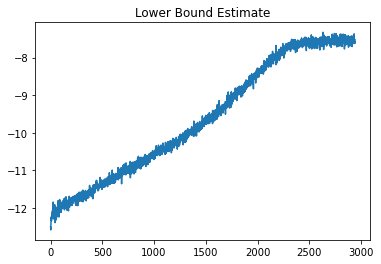

In [83]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

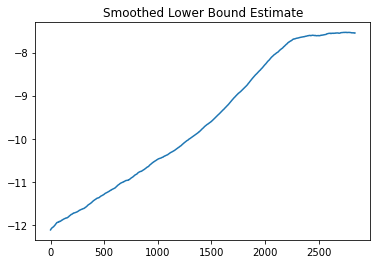

In [84]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [85]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([1.82311574, 0.44547341, 0.94500882, 0.05703595])

In [ ]:
best_mu_untransformed = best_lambda_untransformed[0]
best_vech_l_untransformed = list(best_lambda_untransformed[1])
best_l_untransformed = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l_untransformed[i:num_coeffs,i] = best_vech_l_untransformed[:num_coeffs - i]
    del best_vech_l_untransformed[:num_coeffs-i]
best_Sigma_untransformed =  np.linalg.inv(best_l_untransformed @ best_l_untransformed.T)

best_theta_tilde_untransformed = multivariate_normal.rvs(mean = best_mu_untransformed, cov = best_Sigma_untransformed, size = 1000)
best_alpha_untransformed = (2 * np.exp(best_theta_tilde_untransformed[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_untransformed[:,0]))
best_beta_untransformed = (np.exp(best_theta_tilde_untransformed[:,1]) - 1) / (np.exp(best_theta_tilde_untransformed[:,1]) + 1)
best_gamma_untransformed = np.exp(best_theta_tilde_untransformed[:,2])
best_delta_untransformed = best_theta_tilde_untransformed[:,3]
best_theta_untransformed = np.array([best_alpha_untransformed, best_beta_untransformed, best_gamma_untransformed, best_delta_untransformed])
posterior_mean_estimate_untransformed = np.mean(best_theta_untransformed, axis = 1)
posterior_mean_estimate_untransformed

In [ ]:
best_mu_wass = best_lambda_wass[0]
best_vech_l_wass = list(best_lambda_wass[1])
best_l_wass = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l_wass[i:num_coeffs,i] = best_vech_l_wass[:num_coeffs - i]
    del best_vech_l_wass[:num_coeffs-i]
best_Sigma_wass =  np.linalg.inv(best_l_wass @ best_l_wass.T)

best_theta_tilde_wass = multivariate_normal.rvs(mean = best_mu_wass, cov = best_Sigma_wass, size = 1000)
best_alpha_wass = (2 * np.exp(best_theta_tilde_wass[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_wass[:,0]))
best_beta_wass = (np.exp(best_theta_tilde_wass[:,1]) - 1) / (np.exp(best_theta_tilde_wass[:,1]) + 1)
best_gamma_wass = np.exp(best_theta_tilde_wass[:,2])
best_delta_wass = best_theta_tilde_wass[:,3]
best_theta_wass = np.array([best_alpha_wass, best_beta_wass, best_gamma_wass, best_delta_wass])
posterior_mean_estimate_wass = np.mean(best_theta_wass, axis = 1)
posterior_mean_estimate_wass

Text(0.5, 1.0, 'Posterior density of alpha')

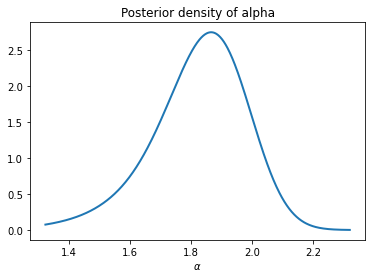

In [90]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_alpha_untransformed)-4*np.std(best_alpha_untransformed),np.mean(best_alpha)-4*np.std(best_alpha)), max(np.mean(best_alpha_untransformed)+4*np.std(best_alpha_untransformed), np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0055, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_vb_untransformed.fit(best_alpha_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

kde_vb_wass = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_vb_wass.fit(best_alpha_wass.reshape(-1, 1))
y_plot_vb_wass = kde_vb_wass.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb_wass), '-', linewidth=2.0, label = 'WG - VB - BSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')
# only one line may be specified; full height
plt.axvline(x = 1.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

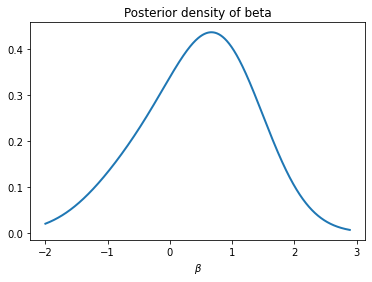

In [96]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

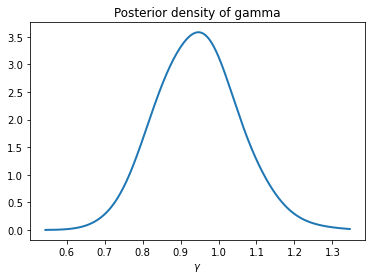

In [97]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

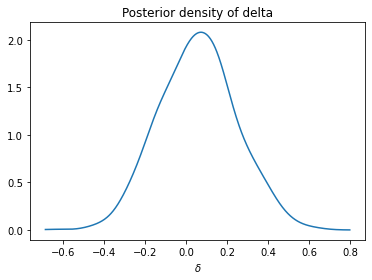

In [99]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.06, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [ ]:
num_samples = 50000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((1.8-1.1)/(2-1.8)),np.log((0.5+1)/(1-0.5)),np.log(1),0])

    alpha = (2 * np.exp(theta_tilde[0]) + 1.1) / (1 + np.exp(theta_tilde[0]))
	beta = (np.exp(theta_tilde[1]) - 1) / (np.exp(theta_tilde[1]) + 1)
	gamma = np.exp(theta_tilde[2])
	delta = theta_tilde[3]

    theta = np.array([alpha, beta, gamma, delta])

    ss = summary_statistics(theta, n_samples, num_datasets, mixture_obj_seq)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # Nuissance mean and variance
    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(sample_variance))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets, num_coeffs, num_latent, actual_summary_statistics, mixture_obj_seq)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde, sigma_theta, num_coeffs)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.05:
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
            else:
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)

        alpha_prop = (2 * np.exp(theta_proposal_tilde[0]) + 1.1) / (1 + np.exp(theta_proposal_tilde[0]))
        beta_prop = (np.exp(theta_proposal_tilde[1]) - 1) / (1 + np.exp(theta_proposal_tilde[1]))
        gamma_prop = np.exp(theta_proposal_tilde[2])
        delta_prop = theta_tilde_q[3]

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        ss = summary_statistics(theta_proposal, num_samples, num_datasets, mixture_obj_seq)
        sample_mean = ss[0]
        sample_variance = ss[1]
        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(sample_variance))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))


        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets, num_coeffs, num_latent, actual_summary_statistics, mixture_obj_seq)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)       
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

In [ ]:
pos_w = np.loadtxt('mcmc_w_varobust.txt')
pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.075, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.155, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


In [ ]:
plt.figure()

pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

In [ ]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


In [ ]:
plt.figure()

pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

In [ ]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.0375, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


In [ ]:
plt.figure()

pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
x_plot = np.arange((pos_delta_mean-4*pos_delta_std), (pos_delta_mean+4*pos_delta_std), 0.002)
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

In [ ]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-4*pos_delta_std,np.mean(best_delta)-4*np.std(best_delta)), max(pos_delta_mean+4*pos_delta_std, np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')


In [ ]:
alpha_trace = pos_w[int(num_burnin):,0]
beta_trace = pos_w[int(num_burnin):,1]
gamma_trace = pos_w[int(num_burnin):,2]
delta_trace = pos_w[int(num_burnin):,3]

x = np.arange(len(alpha_trace))
plt.figure(facecolor = 'white')
plt.plot(x, alpha_trace, label='Alpha')  
plt.plot(x, beta_trace, label='Beta')  
plt.plot(x, gamma_trace, label='Gamma')  
plt.plot(x, delta_trace, label='Delta')  
plt.xlabel('Number of samples')
plt.ylabel('Theta')
plt.legend()
plt.title("Trace Plot for Theta")
plt.show()